# LCA of urban biochar products

Perform LCI, LCIA & contribution analysis calculations for various biochar products, with different biochar supply chains, in different energy context (heat, electricity, transportation fuel).

If you already have a bw2 project with the proper foreground and background databases, and the project parameters, then you can simply: 
- 1) edit some constants in Section 1 Default variables, and
- 2) run calculations with Section 4 Comparative LCA of 5 biochar products with 7 supply-chains.


In [1]:
import brightway2 as bw2
import numpy as np
import pandas as pd
import itertools
import json, datetime, pickle
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
from lca_algebraic import newActivity, newFloatParam, getActByCode, persistParams
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group

from bw2helpers import *

from matplotlib import style
style.available
style.use('seaborn')

## Default variables

In [2]:
pro = 'cs_Uppsala' # project name
bw2.projects.set_current(pro)
afp = 'C:/Users/eazzi/Box Sync/KTH_PhD_HeavyData/P5_uppsala' # absolute folder path

export2Excel_rawData = 'img/LCA_rawData.xlsx'# rawData i.e. dataframes as they come out from graph_traversal, useful for quick reload of LCA computations without re-running them
export2Excel_figureData = 'img/LCA_figureData.xlsx' #figureData i.e. dataframe as they appear in the figures

IPCC = [method for method in bw2.methods if "IPCC 2013" in str(method) 
        and "GWP 100" in str(method) 
        and "LT" not in str(method)
        and "V1" not in str(method)]
IPCC_unit = [r'kg $CO_2$-eq']

EcoScarEnergy = [method for method in bw2.methods
        if "ecological scarcity" in str(method) 
        and "2013" in str(method)
        and "energy" in str(method)
        and "no LT" not in str(method)]

EcoScarEnergy_unit = [bw2.methods[method]['unit'] for method in EcoScarEnergy]

CExD = [method for method in bw2.methods
        if "cumulative exergy demand" in str(method) ]
CExD_units = [bw2.methods[method]['unit'] for method in CExD]

ILCD = [method for method in bw2.methods if "ILCD 2.0" in str(method) 
        and "LT" not in str(method)
        and "V1" not in str(method)
        and "climate change" not in str(method)] # excluding climate change

ILCD_units = [bw2.methods[method]['unit'] for method in ILCD]
# correct some units, with chemical symbols
ILCD_units[0] = r'mol $H^{+}$-Eq'
ILCD_units[6] = r'kg $U_235$-Eq'
ILCD_units[-5] = r'$m^3$ water'

all_methods= IPCC + ILCD + CExD
all_methods_units= IPCC_unit + ILCD_units + CExD_units

slt = [0, 4, 14, 15]
subset_methods = [all_methods[i] for i in slt]
subset_methods_units = [all_methods_units[i] for i in slt]
#for i,j in zip(subset_methods, subset_methods_units):
#    print(i, j)

## Tagging of LCA foreground databases

**Thoughts on tagging**
- Max 10 categories, for colormaps
- Small contributions, below x% grouped under label "other" when plotting
- What about + and - contributions of a same tag: should we show the net value? or distinghuish + and - (sometimes they may be equal and cancel each other: e.g. transport in ref product and biochar product being equal)
- biochar C-sink: show only net value 
- Do not tag everything in all fg databases... otherwise, too many tags

- Find commong tags per biochar application (fu), starting from high level

**Tagging in practice per database**
- background-system: Transport by road, Transport by sea, Electricity in SE, District heat, Machinery
- material: *material names* ... so here, transport of pumice will be placed separately from pumice mining - not problematic
- pro_biochar:
- biomass: ** so here, again, RLU energy penalty will go under bg-system tags, unless I don't tag it 

***For stand-alone plots***

**Level 1**  Manufacturing, Use, Disposal

**Level 2** Split M, U, D into its components of interest
- M: Net C-sink, Provision of biochar, Provision of other elements, Transportation, Machinery and energy inputs
- U: depends
- D: depends


Then, we can work on "tagged" stand-alone results, and make the diff biochar-ref 

**Recommendation when developing LCA model in LCA:** Over-use empty shell activities in fg-databases, to avoid direct referencing to "background-system" (which is my Swedish flexible background"). For instance, transportation, rather can have empty shell activities any time it is used, so later it can be either tagged as 'transportation' or distinguish between 'biomass transport', 'biochar transport', 'other material transport' 

### Biochar Benchmark



#### Tagging

Biochar benchmark i.e. comparison of 8 biochar supply chains, with different biomass, different reactors, different reference land use, with also 2 background energy systems (rather decarbonised, rather fossil) 






Tag traversal:

- label (which tags to look for): 
    - gr_bc = grouping for biochar benchmark
    - gr_mat = grouping for material benchmark
    - gr_lca = grouping for product lca (manufacturingw with sub assemblies, disposal, use, phase, + c-sink on its own)
    
    
- for biochar benchmark, what grouping do I want on the graphs? and short names
    1. initial C-sink (only relevant for cc) >> C-sink0
    - reference land/biomass use or 'land use change' >> RLU 
    - biomass cultivation >> 
    - biomass transport to pyrolysis plant
    - pyrolysis reactor, manuf + disposal
    - pyrolysis use (elec + direct emissions)
    - energy substitution >> from pyrolysis or net from RLU when relevant
    
   
- biochar supply chains are based on the databases:
    - pro_biochar
    - biomass 
    - background-system 
    - (biosphere3 + ecoinvent)
    

In [269]:
## Step 1 - Convenient tagging
label = 'gr_bc'
new_pro_biochar = conveniently_tag_database_v2('pro_biochar', label)

There are 39 items to be tagged, one by one
Do you want to proceed (Y/N) ? Y
Lets proceed! Type 'skip' or in order to not tag the given activity or remove existing tag
Activity:  manufacturing and disposal of pyrolysis reactor biogreen
...to be in the group called... ? Reactor
Activity:  manufacturing and disposal of pyrolysis reactor australian
...to be in the group called... ? Reactor
Activity:  production of biochar, in el-heated pyrolysis, from urban garden waste
Current group:  Pyrolysis
...to be in the group called... ? Pyrolysis
Activity:  production of biochar, in syngas-heated pyrolysis, from urban garden waste
Current group:  Pyrolysis
...to be in the group called... ? Pyrolysis
Activity:  production and supply of landscaping soil A, biochar Z
...to be in the group called... ? skip
Activity:  production and supply of soil-macadam B, reference
...to be in the group called... ? skip
Activity:  biochar CO2 sequestration, at production
Current group:  C-sink
...to be in the group

In [28]:
label = 'gr_bc'
new_biomass= conveniently_tag_database_v2('biomass', label)

There are 27 items to be tagged, one by one
Do you want to proceed (Y/N) ? Y
Lets proceed! Type 'skip' or in order to not tag the given activity or remove existing tag
Activity:  RLU, logging residues, non-harvest, for MRG heat
Current group:  RLBU
...to be in the group called... ? skip
Activity:  production of wood pellets, RLU combustion in HOB
Current group:  Biomass production
...to be in the group called... ? Biomass production
Activity:  RLU, willow, fallow land
Current group:  RLBU
...to be in the group called... ? RLBU
Activity:  production and supply of logging residues, RLU non-harvest
Current group:  Biomass production
...to be in the group called... ? Biomass production
Activity:  production of logging residues, RLU non-harvest
Current group:  Biomass production
...to be in the group called... ? Biomass production
Activity:  production of district heat, avoided burden
...to be in the group called... ? skip
Activity:  RLU, logging residues, non-harvest
Current group:  RLBU
.

In [ ]:
new_background = conveniently_tag_database('background-system', label)

In [ ]:
new_background = conveniently_tag_database('background-system', label)

In [ ]:
## Step 2 - Check the created dictionnary
new_pro_biochar

In [ ]:
new_biomass

In [ ]:
## Step 3 - Re-write the database
rewrite_tagged_database('pro_biochar', new_pro_biochar)

In [ ]:
rewrite_tagged_database('biomass', new_biomass)

In [ ]:
rewrite_tagged_database('background-system', new_background)

#### Figure - with Clean energy system

In [45]:
act = searchActivity(ins=['production of b'],
                    outs=['market', 'flame', 'from woodchips', 'biochar Z'],
                    db='pro_biochar')

act.sort(reverse=True)
re_order = [4, 5, 3, 2, 1, 0, 7, 6]#[]# [1, 2, 0] [4, 5, 3, 2, 0, 1, 7, 6]
if len(re_order)>0:
    act = [ act[i] for i in re_order] 
act

['production of biochar, in syngas-heated pyrolysis, from wood pellets' (kilogram, SE, None),
 'production of biochar, in el-heated pyrolysis, from wood pellets' (kilogram, SE, None),
 'production of biochar, in syngas-heated pyrolysis, from urban garden waste' (kilogram, SE, None),
 'production of biochar, in el-heated pyrolysis, from urban garden waste' (kilogram, SE, None),
 'production of biochar, in syngas-heated pyrolysis, from logging residues' (kilogram, SE, None),
 'production of biochar, in mobile syngas-heated pyrolysis, from logging residues' (kilogram, SE, None),
 'production of biochar, in syngas-heated pyrolysis, from willow chips' (kilogram, SE, None),
 'production of biochar, in syngas-heated pyrolysis, from agricultural residues' (kilogram, SE, None)]

In [46]:
# let's add, once and for all a custom key with the density of the biochar to the producing activity
#searchParameters('bc_density')
mapping_densities = {'wood pellets': 0.500,
                    'garden waste': 0.242,
                    'logging residues': 0.194,
                    'willow chips': 0.270,
                    'agricultural residues':0.376}
for a in act:
    for key, val in mapping_densities.items():
        if key in a['name']:
            a['bc_density']=val
    a.save() # save to peewee    
    print(a['bc_density'], a['name'])

0.5 production of biochar, in syngas-heated pyrolysis, from wood pellets
0.5 production of biochar, in el-heated pyrolysis, from wood pellets
0.242 production of biochar, in syngas-heated pyrolysis, from urban garden waste
0.242 production of biochar, in el-heated pyrolysis, from urban garden waste
0.194 production of biochar, in syngas-heated pyrolysis, from logging residues
0.194 production of biochar, in mobile syngas-heated pyrolysis, from logging residues
0.27 production of biochar, in syngas-heated pyrolysis, from willow chips
0.376 production of biochar, in syngas-heated pyrolysis, from agricultural residues


In [47]:
## Switch params and re-do benchmark of biochars
mrg_el = [0,1,2] # 0 = average, 1 = csq mix, 2 = natural gas CC
mrg_heat = [0,1,2] # 0 = wood chips, 1 = fuel oil, 2 = natural gas 
mrg_fuel = [0.7, 1] # share of fossil-fuel in diesel market

# update parameters - ELECTRICITY
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_el') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted)
bw2.parameters.new_project_parameters(wanted, overwrite=True)

# update parameters - HEAT
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_heat') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted)
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...

# update parameters - BIOFUEL
wanted = []
wanted = searchParameters('mrg_fuel_1')
wanted[0]['amount'] = mrg_fuel[0] # 0 : average, 1: fossil system
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...


bw2.parameters.recalculate() # needed, for all relationships to be recalculated 

[{'name': 'mrg_el_1', 'amount': 1.0}, {'name': 'mrg_el_2', 'formula': '', 'amount': 1.0}, {'name': 'mrg_el_3', 'amount': 0.0}]
[{'name': 'mrg_heat_1', 'amount': 1.0}, {'name': 'mrg_heat_2', 'amount': 1.0}, {'name': 'mrg_heat_3', 'amount': 0.0}]
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urba

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_

In [48]:
fus_tonne = [ {x.key:1000} for x in act] # 1 tonne biochar
fus_m3 = [ {x.key:1000*x['bc_density']} for x in act] # m3 biochar

fus = fus_tonne + fus_m3 # list of FUs
fg_dbs = ['biomass', 'pro_biochar', 'background-system']
label = 'gr_bc'
default_tag = 'Other'
meth = IPCC
meth_unit = IPCC_unit
result_df_bcc = run_graphTaggedTraversal(fus, meth, meth_unit, label,default_tag, fg_dbs,
                                     bio2tech=True, parent4other=True,)
# save rawData to Excel
append_df_to_excel(export2Excel_rawData, result_df_bcc, sheet_name='biochar_SC_CCclean'+label)

production of biochar, in syngas-heated pyrolysis, from wood pellets 1000
graphs/gr_bc_production of biochar, in syngas-heated pyrolysis, from wood pellets_0_2021-09-13_at_11-20.pickle
production of biochar, in el-heated pyrolysis, from wood pellets 1000
graphs/gr_bc_production of biochar, in el-heated pyrolysis, from wood pellets_0_2021-09-13_at_11-20.pickle
production of biochar, in syngas-heated pyrolysis, from urban garden waste 1000
graphs/gr_bc_production of biochar, in syngas-heated pyrolysis, from urban garden waste_0_2021-09-13_at_11-20.pickle
production of biochar, in el-heated pyrolysis, from urban garden waste 1000
graphs/gr_bc_production of biochar, in el-heated pyrolysis, from urban garden waste_0_2021-09-13_at_11-20.pickle
production of biochar, in syngas-heated pyrolysis, from logging residues 1000
graphs/gr_bc_production of biochar, in syngas-heated pyrolysis, from logging residues_0_2021-09-13_at_11-20.pickle
production of biochar, in mobile syngas-heated pyrolysis, f

In [74]:
# reload rawData from Excel
result_df_bcc = pd.read_excel(export2Excel_rawData,sheet_name='biochar_SC_CCclean'+label,
                              index_col=[0,1,2,3], converters={'Impact':eval})
result_df_bcc.fillna(0, inplace=True)

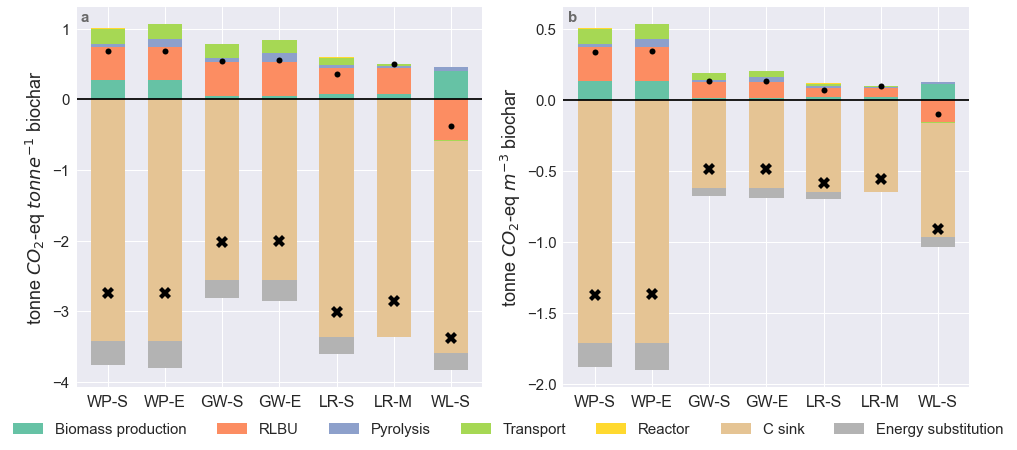

In [76]:
figname = 'SA_biochar_'+'CC'+'_clean'
names = ['bc1', 'bc2', 'bc3', 'bc4', 'bc5', 'bc6', 'bc7', 'bc8'] # check from act 
## names = ['LR-M', 'LR-S',  'GW-E', 'GW-S', 'WP-S', 'WP-E', 'AGR-S', 'WI-S'] # check from act 
names = ['WP-S', 'WP-E', 'GW-S','GW-E', 'LR-S', 'LR-M', 'WL-S',] # check from act  'AGR-S'

col_reordered = ['Biomass production',
                 'RLBU',
                 'Pyrolysis',
                 'Transport',
                 'Reactor',
    #             'Other',
                 'C-sink',
                 'Energy substitution'
                 ]

yname = r'kg $CO_2$-eq $tonne^{-1}$ biochar'
ytitle = 'Biochar supply chains'

tmp = result_df_bcc.copy() # df copy
tmp.fillna(value=0.0, inplace=True) # fill nan with 0
tmp = tmp.loc[:, (tmp != 0).any(axis=0)] # drop 0 colums

# select impact assessment method , xs = cross-section in df, via index levels
tmp = tmp.xs(tmp.index[0][2], axis=0, level=2, drop_level=True)
tmp = tmp[ col_reordered ]

# remove the agr res
tmp = tmp.query("FU != 'production of biochar, in syngas-heated pyrolysis, from agricultural residues' ")

#re-scale kg ton tonnes CO2-eq
tmp = tmp / 1000

# select via xs, the correct FU
sub_tmp = tmp.query("FU_amount == '1000'")
sub_tmp2 = tmp.query("FU_amount != '1000'")

fig, ax = plt.subplots(nrows=1, ncols=2, 
                        figsize=(16,7),
                        sharex=False)

sub_annotation = ['a', 'b']

i = 0
barv_toAxes(ax[i], sub_tmp, names, 
            '', r'tonne $CO_2$-eq $tonne^{-1}$ biochar', 16,
            'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
            0.6)
ax[i].annotate(sub_annotation[i], xy=(0.01,0.96), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold')
ax[i].tick_params(axis='y', which='major', labelsize=15)

i = 1
barv_toAxes(ax[i], sub_tmp2, names, 
            '', r'tonne $CO_2$-eq $m^{-3}$ biochar', 16,
            'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
            0.6)
ax[i].annotate(sub_annotation[i], xy=(0.01,0.96), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 
ax[i].tick_params(axis='y', which='major', labelsize=15)


# get overall legend, from one of the axes, be sure that all axes have same columns (i.e. from same orginal df)
handles, labels = ax[i].get_legend_handles_labels()
labels =['Biomass production',
 'RLBU',
 'Pyrolysis',
 'Transport',
 'Reactor',
 'C sink',
 'Energy substitution']
fig.legend(handles, labels, 
           #bbox_to_anchor=(0.06, 0.79, 0.75, 0.1), 
           loc='lower center',         
           ncol=7, 
           #mode="expand", 
           borderaxespad=0.5,
           fontsize=15)

#fig.tight_layout(h_pad=2, w_pad=3)
#plt.subplots_adjust(top=0.99, right=0.99)

# annotates sub_plots a, b

#save img to disk
fig.savefig('img/'+figname+'.png', dpi=600, bbox_inches='tight')

# save figureData to Excel 
tmp['Chart names'] = names+names
tmp.set_index('Chart names', append=True, inplace=True)
append_df_to_excel(export2Excel_figureData, tmp.T, sheet_name=figname)

#### Figure - with Dirty energy system

In [77]:
## Switch params and re-do benchmark of biochars
mrg_el = [0,1,2]
mrg_heat = [0,1,2]
mrg_fuel = [0.7, 1] # share of fossil-fuel in diesel market

# update parameters - ELEC
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_el') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(2, wanted) # 2: natural gas combi cycle
bw2.parameters.new_project_parameters(wanted, overwrite=True)

# update parameters - HEAT
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_heat') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(2, wanted) # 1: heavy-fuel oil, 2: natural gas
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...


# update parameters - BIOFUEL
wanted = []
wanted = searchParameters('mrg_fuel_1')
wanted[0]['amount'] = mrg_fuel[1] # 0 : average, 1: fossil system
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...

bw2.parameters.recalculate() # needed, for all relationships to be recalculated 

[{'name': 'mrg_el_1', 'amount': 0.0}, {'name': 'mrg_el_2', 'formula': '', 'amount': 1.0}, {'name': 'mrg_el_3', 'amount': 1.0}]
[{'name': 'mrg_heat_1', 'amount': 0.0}, {'name': 'mrg_heat_2', 'amount': 1.0}, {'name': 'mrg_heat_3', 'amount': 1.0}]
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urba

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatme

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504

In [78]:
fus_tonne = [ {x.key:1000} for x in act] # 1 tonne biochar
fus_m3 = [ {x.key:1000*x['bc_density']} for x in act] # m3 biochar

fus = fus_tonne + fus_m3 # list of FUs
fg_dbs = ['biomass', 'pro_biochar', 'background-system']
label = 'gr_bc'
default_tag = 'Other'
meth = IPCC
meth_unit = IPCC_unit
result_df_bcd = run_graphTaggedTraversal(fus, meth, meth_unit, label,default_tag, fg_dbs,
                                     bio2tech=True, parent4other=True, )
# save rawData to Excel
append_df_to_excel(export2Excel_rawData, result_df_bcd, sheet_name='biochar_SC_CCdirty'+label)

production of biochar, in syngas-heated pyrolysis, from wood pellets 1000
graphs/gr_bc_production of biochar, in syngas-heated pyrolysis, from wood pellets_0_2021-09-13_at_11-36.pickle
production of biochar, in el-heated pyrolysis, from wood pellets 1000
graphs/gr_bc_production of biochar, in el-heated pyrolysis, from wood pellets_0_2021-09-13_at_11-36.pickle
production of biochar, in syngas-heated pyrolysis, from urban garden waste 1000
graphs/gr_bc_production of biochar, in syngas-heated pyrolysis, from urban garden waste_0_2021-09-13_at_11-36.pickle
production of biochar, in el-heated pyrolysis, from urban garden waste 1000
graphs/gr_bc_production of biochar, in el-heated pyrolysis, from urban garden waste_0_2021-09-13_at_11-36.pickle
production of biochar, in syngas-heated pyrolysis, from logging residues 1000
graphs/gr_bc_production of biochar, in syngas-heated pyrolysis, from logging residues_0_2021-09-13_at_11-36.pickle
production of biochar, in mobile syngas-heated pyrolysis, f

In [79]:
# reload rawData from Excel
result_df_bcd = pd.read_excel(export2Excel_rawData,sheet_name='biochar_SC_CCdirty'+label,
                              index_col=[0,1,2,3], converters={'Impact':eval})
result_df_bcd.fillna(0, inplace=True)

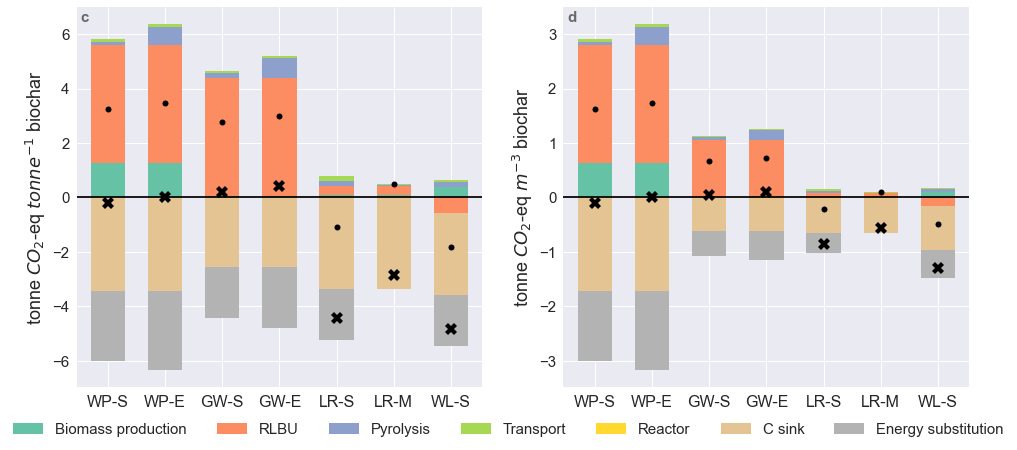

In [80]:
figname = 'SA_biochar_'+'CC'+'_dirty'
names = ['bc1', 'bc2', 'bc3', 'bc4', 'bc5', 'bc6', 'bc7', 'bc8'] # check from act 
## names = ['LR-M', 'LR-S',  'GW-E', 'GW-S', 'WP-S', 'WP-E', 'AGR-S', 'WI-S'] # check from act 
names = ['WP-S', 'WP-E', 'GW-S','GW-E', 'LR-S', 'LR-M', 'WL-S', ] # check from act  'AGR-S'

col_reordered = ['Biomass production',
                 'RLBU',
                 'Pyrolysis',
                 'Transport',
                 'Reactor',
#                 'Other',
                 'C-sink',
                 'Energy substitution'
                 ]

yname = r'kg $CO_2$-eq $tonne^{-1}$ biochar'
ytitle = 'Biochar supply chains'

tmp = result_df_bcd.copy() # df copy
tmp.fillna(value=0.0, inplace=True) # fill nan with 0
tmp = tmp.loc[:, (tmp != 0).any(axis=0)] # drop 0 colums

# select impact assessment method , xs = cross-section in df, via index levels
tmp = tmp.xs(tmp.index[0][2], axis=0, level=2, drop_level=True)
tmp = tmp[ col_reordered ]

# remove the agr res
tmp = tmp.query("FU != 'production of biochar, in syngas-heated pyrolysis, from agricultural residues' ")
tmp = tmp / 1000

# select via xs, the correct FU
sub_tmp = tmp.query("FU_amount == '1000'")
sub_tmp2 = tmp.query("FU_amount != '1000'")

fig, ax = plt.subplots(nrows=1, ncols=2, 
                        figsize=(16,7),
                        sharex=False)

sub_annotation = ['c', 'd']


i = 0
barv_toAxes(ax[i], sub_tmp, names, 
            '', r'tonne $CO_2$-eq $tonne^{-1}$ biochar', 16,
            'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
            0.6)
ax[i].annotate(sub_annotation[i], xy=(0.01,0.96), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 
ax[i].tick_params(axis='y', which='major', labelsize=15)

i = 1
barv_toAxes(ax[i], sub_tmp2, names, 
            '', r'tonne $CO_2$-eq $m^{-3}$ biochar', 16,
            'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
            0.6)
ax[i].annotate(sub_annotation[i], xy=(0.01,0.96), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 
ax[i].tick_params(axis='y', which='major', labelsize=15)

# get overall legend, from one of the axes, be sure that all axes have same columns (i.e. from same orginal df)
handles, labels = ax[i].get_legend_handles_labels()
labels =['Biomass production',
 'RLBU',
 'Pyrolysis',
 'Transport',
 'Reactor',
 'C sink',
 'Energy substitution']
fig.legend(handles, labels, 
           #bbox_to_anchor=(0.06, 0.79, 0.75, 0.1), 
           loc='lower center',         
           ncol=7, 
           #mode="expand", 
           borderaxespad=0.5,
           fontsize=15)


#plt.subplots_adjust(top=0.99, right=0.99)

#save img to disk
fig.savefig('img/'+figname+'.png', dpi=600, bbox_inches='tight')
# save df to Excel 
fp = 'img/biochar_supply_chains_data_behind_figs.xlsx'
tmp['Chart names'] = names+names
tmp.set_index('Chart names', append=True, inplace=True)
append_df_to_excel(export2Excel_figureData, tmp.T, sheet_name=figname)

### Tagging of product lifecycles, default

Tag traversal:

- label (which tags to look for): 
    - gr_lca = grouping for product lca (manufacturing with sub assemblies, disposal, use, phase, + c-sink on its own)
    
    
- what grouping do I want on the graphs? and short names
    1. net C-sink (at production - decay) >> C-sink 
    - Manufacturing:
        - Supply of Biochar 
        - Supply of Other material
        - Installation work (energy, fuel, for installing the product)
        - Transports
        - OBS: not sure this actually works for all life cycles... 
    - Use phase
    - Disposal
    
   
- based on the foreground databases:
    - pro_biochar >> for C-sink & Supply of Biochar
    - background-system >> for Machinery use & Transport, but ideally have other dummy activities for that heat/elec
    - use_x >> for Supply of Other Material
    
    
Does it work? Let's check with an example?  
- Vegetation planted and established in a 15 m3 constructed soil (with a surface of xx m2) and a lifetime of 50  years
- Have a look at the graph in AB
-

In [ ]:
label = 'gr_lca'
conveniently_tag_database_v2(fg_db_to_tag='material', label=label)

#### Product: Tree planting

In [ ]:
## Step 1 - Convenient tagging
label = 'gr_lca'
new_pro_biochar = conveniently_tag_database('pro_biochar', label)

In [ ]:
label = 'gr_lca'
new_use1 = conveniently_tag_database('use_1_tree-planting', label) 

In [ ]:
label = 'gr_lca'
new_background = conveniently_tag_database('background-system', label)

In [ ]:
## Step 2 - Check the created dictionnary
new_pro_biochar

In [ ]:
new_use1

In [ ]:
new_background

In [ ]:
## Step 3 - Re-write the database
rewrite_tagged_database('pro_biochar', new_pro_biochar)

In [ ]:
rewrite_tagged_database('use_1_tree-planting', new_use1)

In [ ]:
rewrite_tagged_database('background-system', new_background)

#### Product: Green roofs

In [ ]:
label = 'gr_lca'
new_use2 = conveniently_tag_database('use_2_green-roof', label) 

In [ ]:
new_use2

In [ ]:
rewrite_tagged_database('use_2_green-roof', new_use2)

#### Product: Landscaping soils

In [ ]:
# none additional tagging

#### Product: Charcrete

In [ ]:
label = 'gr_lca'
new_use3 = conveniently_tag_database('use_3_charcrete', label) 

In [ ]:
rewrite_tagged_database('use_3_charcrete', new_use3)

In [ ]:
label = 'gr_lca'
new_material = conveniently_tag_database('material', label) 

In [ ]:
rewrite_tagged_database('material', new_material)

#### Product: Biofilm carrier

In [ ]:
label = 'gr_lca'
new_use4 = conveniently_tag_database('use_4_filter', label)

In [ ]:
rewrite_tagged_database('use_4_filter', new_use4)

#### Product: Bio-coal for pig iron

In [ ]:
label = 'gr_lca'
new_use7 = conveniently_tag_database('use_7_benchmark', label)

In [ ]:
rewrite_tagged_database('use_7_benchmark', new_use7)

In [21]:
# select biochar market activity
act = searchActivity(ins=['use', 'Z'],
                    outs=['ranking'],
                    db='ranking')

act.sort(reverse=True)
re_order = [1,0,3,2,5,4]# [1, 2, 0]
if len(re_order)>0:
    act = [ act[i] for i in re_order] 
act

['use_1Z_tree-planting-macadam' (unit biochar, GLO, None),
 'use_2Z_green-roof' (unit biochar, GLO, None),
 'use_3Z_pavingstone' (unit biochar, GLO, None),
 'use_4Z_waterbiofilter' (unit biochar, GLO, None),
 'use_6Z_landscaping-soil' (unit biochar, GLO, None),
 'use_7Z_pig-iron' (unit biocoal, GLO, None)]

In [22]:
# calculate how much biochar there is in each of these activities
how_much = []
for a in act:
    val, df = how_much_biochar(a, 1)
    how_much.append(float(val))

how_much # in kg
# for 1 tree planted, 1m2*year green roof, 1 paving stone, 1 tree pit,  1m3 of water treated, 1 m3 of landscaping soil

[509.40168824697264,
 0.40221122245974095,
 0.7168601381405895,
 0.007857142918510363,
 72.15057373046875,
 0.47826826572418213]

In [23]:
# define adjusted fus
fus = [ {x.key:1000/how_much[i]} for i,x in enumerate(act)] # list of FUs
fus

[{('ranking', '374d05293d2d4093929af502e15c8e91_copy2'): 1.9630873298464042},
 {('ranking', '374d05293d2d4093929af502e15c8e91_copy3'): 2486.255838125189},
 {('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy3'): 1394.9722502269774},
 {('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy4'): 127272.72627867512},
 {('ranking', '08adca5f39ab4b7ca8004b04de610a1d_copy1'): 13.85990364727628},
 {('ranking', '11b75675805e4ed7aa45b45bb76729fc_copy1'): 2090.876756135648}]

### Tagging with RLBU separate from biochar production

In [18]:
## Dupplicate the tag for all activities, with new label
all_fg_dbs = ['use_1_tree-planting', 'use_2_green-roof', 'use_3_charcrete', 'use_4_filter',
             'use_6_soil private', 'use_7_benchmark',
             'pro_biochar','material','biomass','background-system']
label_old = 'gr_lca'
label_new = 'gr_lca_rbu'

## loop on all activities in fg db
for db in all_fg_dbs:
    for a in bw2.Database(db):
        if label_old in a: # then we copy it 
            a[label_new] = a[label_old]
            a.save()

In [22]:
## Edit tag for biomass foreground db, and add biomass to graph traversal
label = 'gr_lca_rbu'
conveniently_tag_database_v2(fg_db_to_tag='biomass', label=label)

There are 27 items to be tagged, one by one
Do you want to proceed (Y/N) ? Y
Lets proceed! Type 'skip' or in order to not tag the given activity or remove existing tag
Activity:  softwood forestry, spruce, sustainable forest management
...to be in the group called... ? skip
Activity:  production of willow woodchips, RLU fallow land
...to be in the group called... ? skip
Activity:  production and supply of wood pellets, RLU combustion in HOB
...to be in the group called... ? skip
Activity:  sawing, hardwood
...to be in the group called... ? skip
Activity:  production and supply of logging residues, RLU non-harvest
...to be in the group called... ? skip
Activity:  RLU, logging residues, non-harvest
...to be in the group called... ? RLBU
Activity:  RLU, logging residues, non-harvest, for MRG heat
...to be in the group called... ? RLBU
Activity:  RLU, willow, fallow land
...to be in the group called... ? RLBU
Activity:  production and supply of wood pellets, RLU not valorised
...to be in t

In [34]:
# for all biochar Z types 
usesZ_all = pd.DataFrame({})

for key in biochar_types:
    
    updateBiocharZ(to=key) # update the biochar types, and recalculate all formulas

    fg_dbs = ['use_1_tree-planting',
          'use_2_green-roof',
          'use_3_charcrete', 
          'use_4_filter', 
          'use_6_soil private',
          'use_7_benchmark',
          'pro_biochar', 'material', 'background-system','biomass']
    
    label = 'gr_lca_rbu'
    default_tag = 'Other'
    
    fus = [ {x.key:1} for x in all_acts_Z ] # list of FUs
    uZ_df = run_graphTaggedTraversal(fus, IPCC, IPCC_unit, label, default_tag, fg_dbs)
    
    usesZ_all = usesZ_all.append(uZ_df, sort=False)

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
lifecycle_water_pre_treatment_plastic_b

disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_macadam___mm_948d531d5ffbd69c657aeedc6188c483
production_and_supply_of_macadam___mm_948d531d5ffbd69c657aeedc6188c483
production_and_supply_of_macad

Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of material X' (kilogram, SE, None) 0
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 72.15057306547271 'production of biochar Z' (kilogram, SE, None) 0
production of paving stone, charcrete Z 1
lifecycle, water pre-treatment, biochar Z biofilter 1
Other 1 'lifecycle, water pre-treatment, biochar Z biofilter' (cubic meter, SE, None) 0
Other 1.0 'operation of water treatment process' (cubic meter, SE, None) 0
Other 1.5714285714285715e-05 'production of biochar matrix for water biofilter, biochar Z' (cubic meter, SE, None) 0
Other 0.007857142857142858 'production of biochar Z' (kilogram, SE, None) 0
Other 1.5714285714285715e-05 'disposal of biochar matrix for water biofi

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatme

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

Other 0.02 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 1e-05 'MRG electricity production' (kilowatt hour, SE, None) 5.384950618118517e-07
Other 4e-05 'production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None) 0
Other 0.000804457014968685 'production of biochar Z' (kilogram, SE, None) 0
Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of material X' (kilogram, SE, None) 0
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 72.15057306547271 'production of biochar Z' (kilogram, SE, None) 0
production of paving stone, charcrete Z 1
lifecycle, water pre-treatment, biochar Z biofilter 1
Other 1 'lifecycle, water pre-treatment, biochar Z biofilte

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_

Other 1408.4000000000003 'production and supply of macadam 8-16 mm' (kilogram, SE, None) 0
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter year, SE, None) 0
Other 0.02 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 1e-05 'MRG electricity production' (kilowatt hour, SE, None) 5.384950618118529e-07
Other 4e-05 'production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None) 0
Other 0.0003893571952448436 'production of biochar Z' (kilogram, SE, None) 0
Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of material X' (kilogram, SE, None) 0
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatme

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_

lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter year, SE, None) 0
Other 0.02 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 1e-05 'MRG electricity production' (kilowatt hour, SE, None) 5.384950618118546e-07
Other 4e-05 'production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None) 0
Other 0.0003893571952448436 'production of biochar Z' (kilogram, SE, None) 0
Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of material X' (kilogram, SE, None) 0
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 34.92087736368879 'production of biochar Z' (kilogram, SE, None) 0
prod

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_

Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1349.8411999999994 'disposal of spent constructed soil' (ton kilometer, GLO, None) 0
Other 4158.0 'production and supply of macadam 32-64 mm' (kilogram, SE, None) 0
Other 1408.4000000000003 'production and supply of macadam 8-16 mm' (kilogram, SE, None) 0
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter year, SE, None) 0
Other 0.02 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 1e-05 'MRG electricity production' (kilowatt hour, SE, None) 5.384950618118566e-07
Other 4e-05 'production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None) 0
Other 0.00031212932180784986 'production of biochar Z' (kilogram, SE, None) 0
Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of mate

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504

Other 4158.0 'production and supply of macadam 32-64 mm' (kilogram, SE, None) 0
Other 1408.4000000000003 'production and supply of macadam 8-16 mm' (kilogram, SE, None) 0
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter year, SE, None) 0
Other 0.02 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 1e-05 'MRG electricity production' (kilowatt hour, SE, None) 5.384950618118521e-07
Other 4e-05 'production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None) 0
Other 0.00031212932180784986 'production of biochar Z' (kilogram, SE, None) 0
Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of material X' (kilogram, SE, None) 0
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, Non

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd07130

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504

Other 4158.0 'production and supply of macadam 32-64 mm' (kilogram, SE, None) 0
Other 1408.4000000000003 'production and supply of macadam 8-16 mm' (kilogram, SE, None) 0
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter year, SE, None) 0
Other 0.02 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 1e-05 'MRG electricity production' (kilowatt hour, SE, None) 5.384950618118495e-07
Other 4e-05 'production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None) 0
Other 0.00043440678808308997 'production of biochar Z' (kilogram, SE, None) 0
Other 0.017094711568084536 'production and supply of macadam 2-4-8 mm' (kilogram, SE, None) 0
Other 0.017094711568084536 'production of material X' (kilogram, SE, None) 0
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, Non

In [35]:
usesZ_all
fp = 'img/hotspot_data_behind_figs.xlsx'
append_df_to_excel(fp, usesZ_all, sheet_name='raw_usesZ_all_rbu')

In [36]:
usesNZ_all = pd.DataFrame({})

fg_dbs = ['use_1_tree-planting',
      'use_2_green-roof',
      'use_3_charcrete', 
      'use_4_filter', 
      'use_6_soil private',
      'use_7_benchmark',
      'pro_biochar', 'material', 'background-system', 'biomass']
label = 'gr_lca_rbu'
default_tag = 'Other'

fus = [ {x.key:1} for x in all_acts_nZ ] # list of FUs
uZ_df = run_graphTaggedTraversal(fus, IPCC, IPCC_unit, label, default_tag, fg_dbs)

usesNZ_all = usesNZ_all.append(uZ_df, sort=False)

establishment of new tree, in hard surface area, in soil-makadam 1
Other 1 'establishment of new tree, in hard surface area, in soil-makadam' (unit, SE, None) 0
Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1476.3559416352662 'disposal of spent constructed soil' (ton kilometer, GLO, None) 0
Other 1408.4000000000003 'production and supply of macadam 8-16 mm' (kilogram, SE, None) 0
Other 4158.0 'production and supply of macadam 32-64 mm' (kilogram, SE, None) 0
Other 0.01666 'production and supply of planting soil B, reference' (cubic meter, SE, None) 0
Other 12.540000000000001 'production and supply of soil-macadam B, reference' (cubic meter, SE, None) 0
establishment of new tree, in hard surface area, in biochar-makadam X 1
Other 1 'establishment of new tree, in hard surface area, in biochar-makadam X' (unit, SE, None) 0
Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1354.3958504370187 'disposal of spent constructe

In [37]:
usesNZ_all
fp = 'img/hotspot_data_behind_figs.xlsx'
append_df_to_excel(fp, usesNZ_all, sheet_name='raw_usesNZ_all_rbu')

skip_X = True
if skip_X:
    usesNZ_all = usesNZ_all[::2]

#### Product lifecycles: Climate

In [42]:
# save & load df
fp='img/hotspot_data_behind_figs.xlsx'
usesNZ_all = pd.read_excel(fp, index_col=[0,1,2,3], sheet_name='raw_usesNZ_all_rbu', engine='openpyxl')
usesZ_all = pd.read_excel(fp, index_col=[0,1,2,3], sheet_name='raw_usesZ_all_rbu', engine='openpyxl')

skip_X = True
if skip_X:
    usesNZ_all = usesNZ_all[::2]

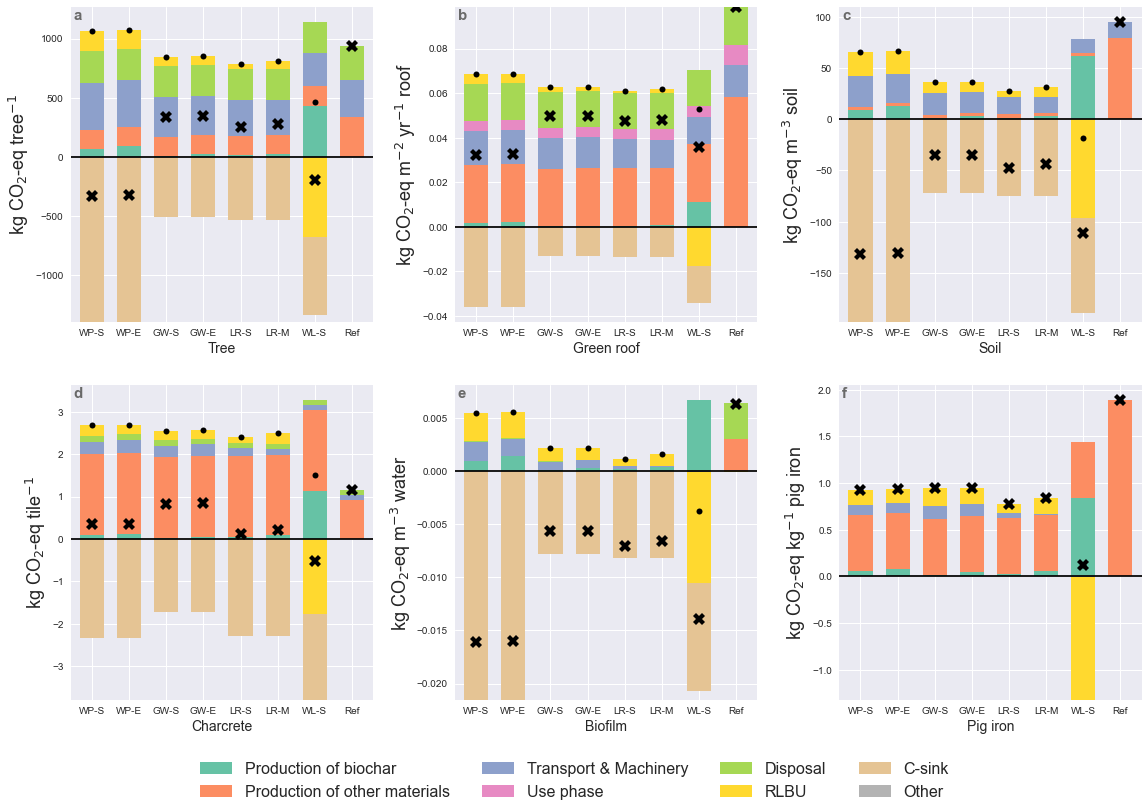

In [44]:
list_dfs = [usesZ_all, usesNZ_all]

# merge df in one, to have same columns everywhere
result_dfAllOne = pd.DataFrame()
for d in list_dfs:
    result_dfAllOne = result_dfAllOne.append(d)
    #print(list(d.columns))
    continue
result_dfAllOne.fillna(0, inplace=True)

col_reordered = ['Supply of biochar',
                 'Supply of other material',
                 'Machinery',
                 'Transport',
                 'Use phase',
                 'Disposal',
                 'Disposal of other material',
                 'Disposal of other material - avoided energy',
                 'RLBU',
                 'Other',
                'C-sink',]
result_dfAllOne = result_dfAllOne[ col_reordered ]

# aggregate columns old col: new col
aggr_map = {
    'Supply of biochar':'Production of biochar',
    'Supply of other material':'Production of other materials',
    'Machinery':'Transport & Machinery',
    'Transport':'Transport & Machinery',
    'Use phase':'Use phase',
    'Disposal':'Disposal',
    'Disposal of other material':'Disposal',
    'Disposal of other material - avoided energy':'Disposal',
    'RLBU':'RLBU',
    'C-sink':'C-sink',
    
    'Other':'Other',
}
result_dfAllOne_agg = pd.DataFrame()
for key, val in aggr_map.items():
    if val in result_dfAllOne_agg.columns:
        result_dfAllOne_agg[val] += result_dfAllOne[key]
    else:
        result_dfAllOne_agg[val] = result_dfAllOne[key] 
result_dfAllOne = result_dfAllOne_agg


result_dfAllOne.sort_index(sort_remaining=False, inplace=True)


# init figure
figAllOne, axAllOne = plt.subplots(nrows=2, ncols=3, 
                        figsize=(17,5.5*2),
                        sharex=False)
axAllOne_line = axAllOne.ravel()
# names
name_series = [key for key in biochar_types] + ['Ref'] # ['X'] + 
name_products = ['Tree', 'Green roof', 'Soil', 'Charcrete', 'Biofilm', 'Pig iron']
unit_products = [r'kg CO$_2$-eq tree$^{-1}$', r'kg CO$_2$-eq m$^{-2}$ yr$^{-1}$ roof', r'kg CO$_2$-eq m$^{-3}$ soil',
                 r'kg CO$_2$-eq tile$^{-1}$', r'kg CO$_2$-eq m$^{-3}$ water', r'kg CO$_2$-eq kg$^{-1}$ pig iron']
sub_annotation = ['a', 'b', 'c', 'd', 'e', 'f']

ii = [0, 1, 4, 2, 3, 5] # re-order plots with df sroted products: df_prod i > goes to > ax ii
n = len(name_series)
for i in range(result_dfAllOne.shape[0]//n ):
    sub_tmp = result_dfAllOne.iloc[i*n:(i+1)*n]
    sub_tmp = sub_tmp.xs(result_dfAllOne.index[0][2], axis=0, level=2, drop_level=True) # select impact category
    sub_tmp = sub_tmp.query("FU_amount == '1'")
    barv_toAxes(axAllOne_line[ii[i]], sub_tmp, name_series, 
            name_products[ii[i]], unit_products[ii[i]], 10,
            'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
            0.65)
    axAllOne_line[i].annotate(sub_annotation[i], xy=(0.01,0.96), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 


# get overall legend, from one of the axes, be sure that all axes have same columns (i.e. from same orginal df)
handles, labels = axAllOne_line[0].get_legend_handles_labels()
figAllOne.legend(handles, labels, loc='lower center', ncol=4, borderaxespad=-0,fontsize=16,)

#figAllOne.tight_layout()
plt.subplots_adjust(top=1, right=1, wspace=0.27, hspace=0.20)

#save img to disk
figname = 'AllInOneZNZ'+'_CC_rbu'
figAllOne.savefig('img/hotspot_'+figname+'.png', dpi=600, bbox_inches='tight')
# save df to Excel 
fp = 'img/hotspot_data_behind_figs.xlsx'
#result_dfAllOne['Chart names'] = name_series*6
#result_dfAllOne.set_index('Chart names', append=True, inplace=True)

append_df_to_excel(fp, result_dfAllOne.T, sheet_name=figname)


There are 31 items to be tagged, one by one
Do you want to proceed (Y/N) ? Y
Lets proceed! Type 'skip' or in order to not tag the given activity or remove existing tag
Activity:  production of macadam 2-4-8 mm
Current group:  Supply of other material
...to be in the group called... ? Supply of other material
Activity:  production and supply of macadam 32-64 mm
...to be in the group called... ? Supply of other material
Activity:  production and supply of mineral soil type B
...to be in the group called... ? Supply of other material
Activity:  production of sand
Current group:  Supply of other material
...to be in the group called... ? Supply of other material
Activity:  production and supply of sand
Current group:  Supply of other material
...to be in the group called... ? Supply of other material
Activity:  production of scoria
Current group:  Supply of other material
...to be in the group called... ? Supply of other material
Activity:  production and supply of peat for horticulture
Cu

## Definition of parametrized activities for biochar products with 7 supply-chains

### Definition of parametrized biochar Z activity

The activities called "biochar Z" are used to easily swithc between biochar supply-chains without creating manually separate activities for each biochar product for the different biochar supply-chains. Formulas are used to update what matters in each product supply-chain based on the properties of the biochar Z. This includes mass to be transported, bulk density, other material requirement, etc..

USER_DB = 'pro_biochar'
BCZ = newActivity(
    USER_DB, # DB
    "production of biochar Z", # Name of the activity
    "kilogram", # Unit
    exchanges= {},
    code='pro-bcz',
    location='SE')

BCZ.addExchanges( {BCX : {'amount': 1 ,
                          'type':'technosphere'},
                   BCZ : {'amount':1,
                          'type':'production'}
                  })

In [3]:
BCX = searchActivity(ins=['wood pellet', 'syngas'],
                     outs=[],
                     db='pro_biochar')[0]
BCX
BCX_C = searchParameters('bc_C_1')[0]
BCX_C['amount']

BCZ = searchActivity(ins=['production of biochar Z'],
                    db='pro_biochar')[0]
BCZ

Z_c = newFloatParam('BCZ_C',
                    default= BCX_C['amount'], # 0..1
                    description='Carbon content of biochar Z')

Z_bd = newFloatParam('BCZ_bd',
                    default= BCX['bc_density'], # t/m3
                    description='Bulk density of biochar Z')

Z_pd = newFloatParam('BCZ_pd',
                    default= 1.80, # t/m3 #TO DO: define dynamically, from other biochar types
                    description='Particle density of biochar Z')

Z_bp = newFloatParam('BCZ_bp',
                    default= 0.45, # t/m3 #TO DO: define dynamically, from other biochar types
                    description='Bulk porosity (without internal pores) of biochar Z')

Z_LHV = newFloatParam('BCZ_lhv',
                     default=29.6,
                     description='LHV in MJ/kg of dry biochar')

dist2proc = newFloatParam('dist2proc',
                         default = searchParameters('dist2proc')[0]['amount'],
                         description='Distance for transport of intermediary products between processing steps')

soilBlending = newFloatParam('soilBlending',
                         default = 5,
                         description='Volume in m3 for soil blending and on-site hauling')


### SoilMixer - Class definition & activity creation [not needed if bw2data already loaded]

In [4]:
class SoilMixer:
    '''
    SoilMixer is a class to caculate mass requirements & final mixed bulk density of products that are blends of several materials
    It requires some recipe input and an assumption on the final mix. Several calculation options are available depending on the data available.
    See details below.
    '''
    def __init__(self):
        #initialise attributes
        self.mass_composition = None
        self.bulk_volume_composition = None
        self.mass_requirement = None
        self.parts_volume = None
        
        self.bulk_density_wet = None
        self.bulk_density_dry = None
        
        self.porosity_total = None
        self.porosity_inter = None
        self.porosity_intra = None
        
        self.calculation_type = None
    
    def calc_SoilMix(self, compo=dict(), b=None, compo_type='m-b', datafile='lci/LCI_SoilMixes2.xlsx', eps = 1e-4, iters = 10):
        '''
        # Replicate calculations in Excel file

        Three calculations setups, defined in compo_type:
        - mass composition, with bulk density dry   >> compo_type = 'm-b'
        - volume parts, with bulk density wet       >> compo_type = 'v-b'
        - volume parts, with total porosity         >> compo_type = 'v-p'
        - volume parts, with interparticle porosity >> compo_type = 'v-pi'

        Provide either bulk density b (wet weight or dry weight) 
        or total porosity b, 
        or inter particule porosity b
        of the final mix

        # Reference data collected in Excel file
        # compo is defined as a dictionnary,

        '''
        
        def sum_dico(dic):
            s=0
            for k,v in dic.items():
                s=s+v
            return s
        
        def check_mass_compo(self, compo):
            s=0
            for k,v in ex_compo.items():
                s = s + v
            if np.abs(s-100.) < 1e-7:
                return True
            else:
                raise Exception('Mass composition does not add up to 100%, instead {}'.format(s))

        ref_df = pd.read_excel(datafile, sheet_name='SoilMixes', usecols='A:J', engine='openpyxl')
        ref_df.set_index('Material', inplace=True)
        
        # Add biochar Z to the df
        biochar_Z = {'Material':['Biochar Z'],
                    'Bulk density, at use': [Z_bd*1000/(1-0.15)],
                    'Moisture content, at use': [0.15],
                    'Bulk density, dry':[Z_bd*1000],
                    'Particle density, dry': [Z_pd*1000],
                    'Total porosity': [(1-Z_bd/Z_pd)],
                    'Bulk porosity': [Z_bp],
                    'Internal porosity': [(1-Z_bd/Z_pd)-Z_bp],
                    'Biochar C content': [Z_c] ,
                    'key':[str(BCZ.key)]}
        
        ref_df = ref_df.append( pd.DataFrame.from_dict(biochar_Z).set_index('Material') )
        
        if compo_type == 'm-b':
            # mass composition & bulk density
            self.calculation_type = compo_type
            self.bulk_density_dry = b # kg/m3
    
            self.mass_composition = compo # %mass, dry
            self.mass_requirement = {k:v*b/100 for k,v in compo.items()} # kg, dry
            self.bulk_volume_composition = {k:v/ref_df.loc[k]['Bulk density, dry'] for k,v in self.mass_requirement.items()} # m3 bulk material                
            
            self.sum_bulk_volumes = sum_dico(self.bulk_volume_composition) # m3
            
            self.parts_volume = {k:v/self.sum_bulk_volumes for k,v in self.bulk_volume_composition.items()} # parts volume, sum to 1
            self.porosity_total = 1- sum_dico({k:v*(1.-ref_df.loc[k]['Total porosity']) for k,v in self.bulk_volume_composition.items()})
            self.porosity_intra = sum_dico({k:v*ref_df.loc[k]['Internal porosity'] for k,v in self.bulk_volume_composition.items()})
            self.porosity_inter = self.porosity_total - self.porosity_intra
            
        if compo_type == 'v-p':
            # volume parts & porosity
            self.calculation_type = compo_type
            self.parts_volume = compo
            self.porosity_total = b
            
            aux_term = sum_dico({k:v*(1.-ref_df.loc[k]['Total porosity']) for k,v in self.parts_volume.items()})
            self.auxilary_term = aux_term
            # print(aux_term, type(aux_term))
           # for k,v in self.parts_volume.items():
           #     print('k:', k, ' - v:', v, 'types: ', type(k), type(v))
            self.bulk_volume_composition = {k:v*(1.-self.porosity_total)/aux_term for k,v in self.parts_volume.items()}
            self.mass_requirement = {k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()}
            self.bulk_density_dry = sum_dico(self.mass_requirement)
            self.bulk_density_wet = sum_dico( {k:v*ref_df.loc[k]['Bulk density, at use'] for k,v in self.bulk_volume_composition.items()} )
            self.mass_composition = {k:v/self.bulk_density_dry for k,v in self.mass_requirement.items()}
            self.porosity_intra = sum_dico({k:v*ref_df.loc[k]['Internal porosity'] for k,v in self.bulk_volume_composition.items()})
            self.porosity_inter = self.porosity_total - self.porosity_intra

        if compo_type == 'v-b':
            # volume parts & bulk density
            self.calculation_type = compo_type
            
            self.parts_volume = compo
            self.bulk_density_wet = b
            
            aux_term = sum_dico({k:v*ref_df.loc[k]['Bulk density, at use'] for k,v in self.parts_volume.items()})
            self.auxilary_term = aux_term
            self.bulk_volume_composition = {k:v*self.bulk_density_wet/aux_term for k,v in self.parts_volume.items()}
            self.mass_requirement = {k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()}
            self.bulk_density_dry = sum_dico({k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()})
            self.mass_composition = {k:v/self.bulk_density_dry for k,v in self.mass_requirement.items()}
            

            self.porosity_total = 1- sum_dico({k:v*(1-ref_df.loc[k]['Total porosity']) for k,v in self.bulk_volume_composition.items()})
            self.porosity_intra = sum_dico({k:v*ref_df.loc[k]['Internal porosity'] for k,v in self.bulk_volume_composition.items()})
            self.porosity_inter = self.porosity_total - self.porosity_intra

        if compo_type == 'v-pi-old':
            # volume parts & porosity interparticule - circular reference
            self.porosity_inter = b
            self.parts_volume = compo
            aux_term = sum_dico({k:v*(1.-ref_df.loc[k]['Total porosity']) for k,v in self.parts_volume.items()})
            self.auxilary_term = aux_term
            # circular reference in Excel need a while loop in python
            i = 0 # iteration counter
            err = 1 # variation in bulk density between two iterations [measuring convergence]
            total_porosity = self.porosity_inter # initial value of total porosity, set to target inter porosity

            # the loop will determine: the bulk density, the bulk volumes of material, and the internal porosity
            if 'Biochar Z' in compo:
                condition1 = True
            else:
                condition1 = np.abs(err) > eps
            while condition1 and i < iters:
                bulk_volumes = {k: v * (1-total_porosity)/aux_term for k,v in self.parts_volume.items()}
                #print('iter: ',i, 'BV: ', bulk_volumes['Macadam 32-64'])
                porosity_intra =  sum_dico( {k:v*ref_df.loc[k]['Internal porosity'] for k,v in bulk_volumes.items()} ) # depends on bulk volumes
                err = (total_porosity - ( self.porosity_inter + porosity_intra ))/total_porosity # change in total porosity between 2 iterations
                #print('err', err)
                total_porosity = self.porosity_inter + porosity_intra # new value, used in next iteration to calculate bulk volumes
                i+=1 # increment iteration counter

            else: # with test recipe, converges in less than 10 iterations (needed: to not do 100 iterations with biochar Z algebraic)
                if 'Biochar Z' in compo:
                    print('iteration', i)
                else:
                    print('iteration', i, 'delta', err)
            self.bulk_volume_composition = bulk_volumes
            self.porosity_intra = porosity_intra
            self.porosity_total = total_porosity
            
            self.mass_requirement = {k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()}
            self.bulk_density_dry = sum_dico({k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()})
            self.bulk_density_wet = sum_dico({k:v*ref_df.loc[k]['Bulk density, at use'] for k,v in self.bulk_volume_composition.items()})
        
        if compo_type == 'v-pi':
            # volume parts & porosity interparticule - circular reference
            self.porosity_inter = b
            self.parts_volume = compo
            aux_term = sum_dico({k:v*(1.-ref_df.loc[k]['Bulk porosity']) for k,v in self.parts_volume.items()})
            self.auxilary_term = aux_term
            # simplified equation:
            self.bulk_volume_composition = {k:v*(1-self.porosity_inter)/aux_term for k,v in self.parts_volume.items()}
            
            self.porosity_intra = porosity_intra =  sum_dico( {k:v*ref_df.loc[k]['Internal porosity'] for k,v in self.bulk_volume_composition.items()} ) # depends on bulk volumes
            self.total_porosity = self.porosity_inter + self.porosity_intra
            self.mass_requirement = {k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()}
            self.bulk_density_dry = sum_dico({k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in self.bulk_volume_composition.items()})
            self.bulk_density_wet = sum_dico({k:v*ref_df.loc[k]['Bulk density, at use'] for k,v in self.bulk_volume_composition.items()})
        
def add_IntermediaryProducts(to_create, withDecay=False, withTransport=False, withBlending=False, datafile='lci/LCI_SoilMixes2.xlsx'):
    '''
    to_create : a list of dict, or a single dict, with following structure 
    {'name': 'production and supply of kolmakadam 32-64, biochar Z',
               'slug': 'km3264_Z',
               'reference product': 'kolmakadam 32-64, biochar Z',
               'unit': 'cubic meter',
               'location': 'SE',
               'database':'material',
               'code':'',
               'withDecay':True,
               'withTransport':{'mode': (dd,dd), # key to activity
                                'distance': 150 }, #km distance transported

               'compo-type': 'v-p',
               'compo-value': '0.4',
               'compo':{'Macadam 32-64':0.80,
                        'Biochar Z':0.10,
                        'Compost':0.10,}
              }
    
    ## OBS : because of peewee. Cross database group - Integrity error, all formula containing
                                exchanges MUST be in the same database, i.e. for this project pro_biochar
    
    '''
    created_activities = []
    
    ## Background data
    ref_df = pd.read_excel(datafile, sheet_name='SoilMixes', usecols='A:J', engine='openpyxl')
    ref_df.set_index('Material', inplace=True)

    # Add biochar Z to the df
    biochar_Z = {'Material':['Biochar Z'],
                'Bulk density, at use': [Z_bd*1000/(1-0.15)],
                'Moisture content, at use': [0.15],
                'Bulk density, dry':[Z_bd*1000],
                'Particle density, dry': [Z_pd*1000],
                'Total porosity': [(1-Z_bd/Z_pd)],
                'Bulk porosity': [Z_bp],
                'Internal porosity': [(1-Z_bd/Z_pd)-Z_bp],
                'Biochar C content': [Z_c] ,
                'key':[str(BCZ.key)]}

    ref_df = ref_df.append( pd.DataFrame.from_dict(biochar_Z).set_index('Material') )

    # check if single item, or several ones
    if isinstance(to_create, dict):
        data = [to_create]
    else:
        data = to_create
    
    # loop on each activity to create
    for item in data:
        # create activity
        new_activity = newActivity(
                        item['database'], # DB
                        item['name'], # Name of the activity
                        item['unit'], # Unit
                        exchanges= {},
                        code=item['slug'],
                        location= item['location'])
                        # missing: reference product 
        
        # add production exchange
        new_activity.addExchanges({new_activity:{'amount':1, 'type':'production'}})
        
        # add other exchanges, based on recipe calculator
        recipe = item['compo']
        r_type = item['compo-type']
        r_value = item['compo-value']
        
        ## calculate & save mass requirement
        SM = SoilMixer()
        SM.calc_SoilMix(compo=recipe, b = r_value, compo_type=r_type)
        
        ## add exchanges from mass_requirement
        mass_carbon_content = 0.0
        exchanges = {}
        for k, val in SM.mass_requirement.items():
            if ref_df.loc[k]['key'] == 'NA':
                pass
            else:
                key_code = eval(ref_df.loc[k]['key']) # tuple from Excel, evaluated
                if key_code[0] == 'biosphere3':
                    # add biosphere exchange
                    bioAct = getActByCode(key_code[0], key_code[1])
                    if bioAct not in exchanges: # to handle case where same biosphere exchange appear several times
                        exchanges[bioAct] ={'type': 'biosphere', 'amount': val,}
                    else: 
                        exchanges[bioAct]['amount'] = exchanges[bioAct]['amount'] + val  
                else:
                    # add technosphere exchange
                    techAct = getActByCode(key_code[0], key_code[1])
                    if techAct not in exchanges:
                        exchanges[techAct] = {'type': 'technosphere', 'amount': val,}
                    else:
                        exchanges[techAct]['amount'] = exchanges[techAct]['amount'] + val
                    
                    # count amount of biochar and biochar average carbon content
                    if 'Biochar' in k:
                        mass_carbon_content = mass_carbon_content + val*ref_df.loc[k]['Biochar C content']
        
        # add biochar decay in soil
        # equation: mass biochar * C% * 44/12, stability level managed by the activity called (80%) for given biochar in soil
        if withDecay:            
            # add technosphere exchange
            techAct = getActByCode('pro_biochar', '0068dd8d111d48e386041cc98d642dd5_copy1')
            exchanges[techAct] = {'type': 'technosphere', 'amount': mass_carbon_content*44/12,}
        
        new_activity.addExchanges( exchanges )
        
        #bw2.parameters.recalculate() # needed to get AB to display values
        
        # Save bw2 Param with BulkDensityWET of the product for transport terms
        expr = SM.bulk_density_wet
        PZ_bd = {'name': item['slug']+'_bd', #name of variable (unique),
                #'amount': ,#numeric value of variable (optional),
                'formula': expr,#formula in Python as string (optional),
                }
        bw2.parameters.new_project_parameters([PZ_bd])
        
        # add transportation term... to site of next use
        if withTransport:
            if item['unit'] == 'cubic meter': # scale for 1 cubic meter
                tkm = expr * item['withTransport']['distance'] / 1000
                trsp = getActByCode(item['withTransport']['mode'][0], item['withTransport']['mode'][1])
                trsp_ex = {}
                trsp_ex[trsp] = {'type':'technosphere', 'amount': tkm}
                new_activity.addExchanges( trsp_ex )
        
        # add blending term
        if withBlending:
                trsp = getActByCode(item['withBlending']['machine'][0], item['withBlending']['machine'][1])
                trsp_ex = {}
                trsp_ex[trsp] = {'type':'technosphere', 'amount': item['withBlending']['volume']}
                new_activity.addExchanges( trsp_ex )     
    
        created_activities.append(new_activity)
        
    bw2.parameters.recalculate() # needed to get AB to display values
        
    return created_activities

In [5]:
# input data
to_create_Hasselfors = [ 
   {'name': 'production and supply of kolmakadam 32-64, biochar Z',
   'slug': 'km3264_Z',
   'reference product': 'kolmakadam 32-64, biochar Z',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-pi',
   'compo-value': 0.344544911287925, # based on calibration of kolmakadam from Hasselfors with biochar LR - should have a dry bulk density around 1700 kg/m3
   'compo':{'Macadam 32-64':1/1.15,
            'Biochar Z':0.075/1.15,
            'Compost':0.075/1.15}
  },
 {'name': 'production and supply of kolmakadam 2-4-8, biochar Z',
   'slug': 'km248_Z',
   'reference product': 'kolmakadam 2-4-8, biochar Z',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-pi',
   'compo-value': 0.416957624516386, # based on calibration of kolmakadam from Hasselfors with biochar LR - should have a dry bulk density around 1400 kg/m3
   'compo':{'Macadam 2-11':0.8,
            'Biochar Z':0.10,
            'Compost':0.10,}
  },

 {'name': 'production and supply of planting soil E, biochar Z',
   'slug': 'soil_E_Z',
   'reference product': 'planting soil E, biochar Z',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-pi',
   'compo-value': 0.608034941009802,
   'compo':{'Biochar Z':0.20,
            'Horticultural peat':0.20,
            'Sand':0.30,
            'Clay':0.30,
           }
  },
 {'name': 'production and supply of planting soil E, reference',
   'slug': 'soil_E_ref',
   'reference product': 'planting soil E, reference',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-b',
   'compo-value': 1250,
   'compo':{
            'Horticultural peat':0.40,
            'Sand':0.30,
            'Clay':0.30,
           }
  },
 {'name': 'production and supply of planting soil A, biochar Z',
   'slug': 'soil_A_Z',
   'reference product': 'planting soil A, biochar Z',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-pi',
   'compo-value': 0.604387869034262,
   'compo':{'Biochar Z':0.20,
            'Sand':0.30,
            'Clay':0.30,
            'Compost':0.15,
           }
  },
 {'name': 'production and supply of planting soil A, reference',
   'slug': 'soil_A_ref',
   'reference product': 'planting soil A, reference',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-b',
   'compo-value': 1250,
   'compo':{
            'Horticultural peat':0.35,
            'Sand':0.35,
            'Clay':0.30,
           }
  },
    
 {'name': 'production and supply of planting soil B, reference',
   'slug': 'soil_B_ref',
   'reference product': 'planting soil B, reference',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-b',
   'compo-value': 1250,
   'compo':{
            'Horticultural peat':0.35,
            'Sand':0.65,
           }
  },
    
 {'name': 'production and supply of soil-macadam B, reference',
   'slug': 'soilmacadam_B_ref',
   'reference product': 'soil-macadam B, reference',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-p',
   'compo-value': 0.344544911287925,
   'compo':{
            'Horticultural peat':0.0456521739130,
            'Sand':0.0847826086957,
            'Macadam 32-64':0.87,
           }
  },  
]

In [28]:
to_create_VegTech = [
 {'name': 'production and supply of mineral soil substrate, biochar Z', # VegTech product
   'slug': 'minsoil_Z',
   'reference product': 'mineral soil substrate, biochar Z',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },

   'compo-type': 'v-pi',
   'compo-value': 0.515848849225012, # based on calibration for WP leading to 1200 kg/m3 based on VegTech data
   'compo':{'Horticultural peat':0.20,
            'Sand':0.25,
            'Crushed rock 0-16/25':0.20,
            'Scoria granules 2-8':0.25,
            'Clay granules 2-6':0.0375,
            'Biochar Z':0.025,
            'Compost':0.0375,
           }
  },
 {'name': 'production and supply of mineral soil substrate, reference', # VegTech product
   'slug': 'minsoil_ref',
   'reference product': 'mineral soil substrate',
   'unit': 'cubic meter',
   'location': 'SE',
   'database':'pro_biochar',
   'withDecay':True,
   'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                     'distance':dist2proc},
   'withBlending': {'machine':('background-system', '55cd06ce91bd41e2cd65400f471327a5_copy1'), # skid-steer
                    'volume': soilBlending, # cubic meters based on estimate from all products from Hasselfors 
                    },
  
   'compo-type': 'v-b', 
   'compo-value': 1200, # based on VegTech data
   'compo':{'Horticultural peat':0.25,
            'Sand':0.25,
            'Crushed rock 0-16/25':0.25,
            'Scoria granules 2-8':0.20,
            'Clay granules 2-6':0.05,
           }
  }
]

In [29]:
# check if single item, or several ones
data = to_create_Hasselfors+to_create_VegTech
data_output_df = pd.DataFrame({})

# loop on each activity to create
for item in data:
   # print(item['compo'])
   # print('')
    if 'Biochar Z' in item['compo']:
        for bc in biochar_types:
            # add other exchanges, based on recipe calculator
            recipe = item['compo'].copy()
            recipe['Biochar '+bc] = item['compo']['Biochar Z'] if 'Biochar Z' in recipe else 0
            recipe.pop('Biochar Z', None)
        #    print(bc)
            r_type = item['compo-type']
            r_value = item['compo-value']

            ## calculate & save mass requirement
            SM = SoilMixer()
            SM.calc_SoilMix(compo=recipe, b = r_value, compo_type=r_type, iters=30)
          #  print('BD_dry', SM.bulk_density_dry)
          #  print('BD_wet', SM.bulk_density_wet)
          #  print('Mass bc', SM.mass_requirement['Biochar '+bc])
            mass_req = SM.mass_requirement.copy()
            mass_req['Biochar'] = mass_req['Biochar '+bc]
            mass_req.pop('Biochar '+bc, None)

            row = pd.DataFrame.from_dict(mass_req, orient='index').T
            row['BD_dry']= SM.bulk_density_dry
            row['BD_wet']= SM.bulk_density_wet
            row['Porosity Total']= SM.porosity_total
            row['Porosity Inter']= SM.porosity_inter
            row['Product'] = item['reference product']
            row['SC'] = bc
           # row['AUX'] = SM.auxilary_term
           # row['BV_Maca'] = SM.bulk_volume_composition['Macadam 32-64'] if 'Macadam 32-64' in SM.bulk_volume_composition else 0
            data_output_df = data_output_df.append(row)

    else: # product without biochar
        recipe = item['compo'].copy()
        r_type = item['compo-type']
        r_value = item['compo-value']
        
        ## calculate & save mass requirement
        SM = SoilMixer()
        SM.calc_SoilMix(compo=recipe, b = r_value, compo_type=r_type, iters=15)
        mass_req = SM.mass_requirement.copy()

        row = pd.DataFrame.from_dict(mass_req, orient='index').T
        row['BD_dry']= SM.bulk_density_dry
        row['BD_wet']= SM.bulk_density_wet
        row['Porosity Total']= SM.porosity_total
        row['Porosity Inter']= SM.porosity_inter
        row['Product'] = item['reference product']
        row['SC'] = '-'
       # row['AUX'] = SM.auxilary_term
        data_output_df = data_output_df.append(row)
            
data_output_df.set_index(['Product', 'SC'], inplace=True)
cols_new_order = ['BD_dry', 'BD_wet', 'Porosity Total', 'Porosity Inter','Biochar', 'Macadam 32-64', 'Compost','Macadam 2-11',
 'Horticultural peat', 'Crushed rock 0-16/25', 'Sand', 'Clay', 'Scoria granules 2-8', 'Clay granules 2-6']
data_output_df = data_output_df[cols_new_order]
data_output_df.fillna(0, inplace=True)
data_output_df

BD_dry       BD_wet  \
Product                           SC                               
kolmakadam 32-64, biochar Z       WP-S  1619.041642  1729.191402   
                                  WP-E  1619.041642  1729.191402   
                                  GW-S  1598.121137  1704.579043   
                                  GW-E  1598.121137  1704.579043   
                                  LR-S  1594.228950  1700.000000   
                                  LR-M  1594.228950  1700.000000   
                                  WL-S  1600.391579  1707.250152   
kolmakadam 2-4-8, biochar Z       WP-S  1335.892484  1442.559407   
                                  WP-E  1335.892484  1442.559407   
                                  GW-S  1305.391576  1406.675985   
                                  GW-E  1305.391576  1406.675985   
                                  LR-S  1299.716989  1400.000000   
                                  LR-M  1299.716989  1400.000000   
                                  WL-S  1308.701752  1410.570310   
planting soil E, biochar Z        WP-S   866.311629  1049.584509   
                                  WP-E   866.311629  1049.584509   
                                  GW-S   824.377596  1000.250351   
                                  GW-E   824.377596  1000.250351   
                                  LR-S   816.575915   991.071903   
                                  LR-M   816.575915   991.071903   
                                  WL-S   828.928576  1005.604446   
planting soil E, reference        -      991.003063  1250.000000   
planting soil A, biochar Z        WP-S   786.441246   939.052715   
                                  WP-E   786.441246   939.052715   
                                  GW-S   749.211551   895.253073   
                                  GW-E   749.211551   895.253073   
                                  LR-S   742.285096   887.104302   
                                  LR-M   742.285096   887.104302   
                                  WL-S   753.251983   900.006522   
planting soil A, reference        -     1009.821265  1250.000000   
planting soil B, reference        -     1075.971377  1250.000000   
soil-macadam B, reference         -     1788.681710  1901.977180   
mineral soil substrate, biochar Z WP-S  1019.586849  1200.000000   
                                  WP-E  1019.586849  1200.000000   
                                  GW-S  1012.807176  1192.023915   
                                  GW-E  1012.807176  1192.023915   
                                  LR-S  1011.545842  1190.539992   
                                  LR-M  1011.545842  1190.539992   
                                  WL-S  1013.542955  1192.889536   
mineral soil substrate            -     1028.732157  1200.000000   

                                        Porosity Total  Porosity Inter  \
Product                           SC                                     
kolmakadam 32-64, biochar Z       WP-S        0.000000        0.344545   
                                  WP-E        0.000000        0.344545   
                                  GW-S        0.000000        0.344545   
                                  GW-E        0.000000        0.344545   
                                  LR-S        0.000000        0.344545   
                                  LR-M        0.000000        0.344545   
                                  WL-S        0.000000        0.344545   
kolmakadam 2-4-8, biochar Z       WP-S        0.000000        0.416958   
                                  WP-E        0.000000        0.416958   
                                  GW-S        0.000000        0.416958   
                                  GW-E        0.000000        0.416958   
                                  LR-S        0.000000        0.416958   
                                  LR-M        0.000000        0.416958   
                                  WL-S        0.000000        0.416958   
plan

In [43]:
pd.set_option("display.precision", 1)
veg = ['mineral soil substrate', 'mineral soil substrate, biochar Z']
data_output_df.query('Product in @ veg')[['BD_dry', 'BD_wet', 'Biochar', 'Compost',
 'Horticultural peat', 'Crushed rock 0-16/25', 'Sand', 'Scoria granules 2-8', 'Clay granules 2-6']]

BD_dry  BD_wet  Biochar  Compost  \
Product                           SC                                       
mineral soil substrate, biochar Z WP-S  1019.6  1200.0     13.1     15.8   
                                  WP-E  1019.6  1200.0     13.1     15.8   
                                  GW-S  1012.8  1192.0      6.4     15.8   
                                  GW-E  1012.8  1192.0      6.4     15.8   
                                  LR-S  1011.5  1190.5      5.1     15.8   
                                  LR-M  1011.5  1190.5      5.1     15.8   
                                  WL-S  1013.5  1192.9      7.1     15.8   
mineral soil substrate            -     1028.7  1200.0      0.0      0.0   

                                        Horticultural peat  \
Product                           SC                         
mineral soil substrate, biochar Z WP-S                37.8   
                                  WP-E                37.8   
                                  GW-S                37.8   
                                  GW-E                37.8   
                                  LR-S                37.8   
                                  LR-M                37.8   
                                  WL-S                37.8   
mineral soil substrate            -                   45.4   

                                        Crushed rock 0-16/25   Sand  \
Product                           SC                                  
mineral soil substrate, biochar Z WP-S                 357.4  394.2   
                                  WP-E                 357.4  394.2   
                                  GW-S                 357.4  394.2   
                                  GW-E                 357.4  394.2   
                                  LR-S                 357.4  394.2   
                                  LR-M                 357.4  394.2   
                                  WL-S                 357.4  394.2   
mineral soil substrate            -                    428.5  378.1   

                                        Scoria granules 2-8  Clay granules 2-6  
Product                           SC                                            
mineral soil substrate, biochar Z WP-S                157.7               43.6  
                                  WP-E                157.7               43.6  
                                  GW-S                157.7               43.6  
                                  GW-E                157.7               43.6  
                                  LR-S                157.7               43.6  
                                  LR-M                157.7               43.6  
                                  WL-S                157.7               43.6  
mineral soil substrate            -                   121.0               55.8

In [20]:
g = ['production_and_supply_of_kolmakadam___biochar_Z_066dd225ae47f1b05b66de71566ea74c',
    'production_and_supply_of_kolmakadam____biochar_Z_12bd32239d9d52930e7c9c9b667faeff',
    'production_and_supply_of_mineral_soil_substrate_biochar_Z_04211b3cb957f6c86b098dd5fd9cc500',
    'production_and_supply_of_landscaping_soil_A_biochar_Z_67fa674bf6cd7f0420e628ce91a684c0',
    'production_and_supply_of_charcrete_recipe__biochar_Z_81a369bdc287cbda6ee58ab3742bc8f5',
     
    'production_and_supply_of_mineral_soil_substrate_reference_2ae32bd6d589d749daeb3717c0ce44ac']

for gg in range(len(g)):
    data = [
        {'name':'FixParam',
        'database':'pro_biochar',
        'code':g[gg],
        'amount':'1',
        'formula':''}]
    bw2.parameters.new_activity_parameters(data=data, 
                                           group=g[gg], 
                                           overwrite=True)

bw2.parameters.recalculate()

add_IntermediaryProducts(to_create_VegTech, withDecay=True, withTransport=True, withBlending=True)

production_and_supply_of_kolmakadam___biochar_Z_066dd225ae47f1b05b66de71566ea74c
production_and_supply_of_kolmakadam___biochar_Z_066dd225ae47f1b05b66de71566ea74c
production_and_supply_of_kolmakadam___biochar_Z_066dd225ae47f1b05b66de71566ea74c
production_and_supply_of_kolmakadam____biochar_Z_12bd32239d9d52930e7c9c9b667faeff
production_and_supply_of_kolmakadam____biochar_Z_12bd32239d9d52930e7c9c9b667faeff
production_and_supply_of_kolmakadam____biochar_Z_12bd32239d9d52930e7c9c9b667faeff
production_and_supply_of_mineral_soil_substrate_biochar_Z_04211b3cb957f6c86b098dd5fd9cc500
production_and_supply_of_mineral_soil_substrate_biochar_Z_04211b3cb957f6c86b098dd5fd9cc500
production_and_supply_of_mineral_soil_substrate_biochar_Z_04211b3cb957f6c86b098dd5fd9cc500
production_and_supply_of_landscaping_soil_A_biochar_Z_67fa674bf6cd7f0420e628ce91a684c0
production_and_supply_of_landscaping_soil_A_biochar_Z_67fa674bf6cd7f0420e628ce91a684c0
production_and_supply_of_landscaping_soil_A_biochar_Z_67fa674bf6

production_and_installation_of_extensive_green_roof_XMS___reference_faeefd3b2d891508ee966d9ef6868246
production_and_installation_of_extensive_green_roof_XMS___reference_faeefd3b2d891508ee966d9ef6868246
production_and_supply_of_makadam___01cdc6c1ab634dd1477efdcc7237a253
production_and_supply_of_makadam___01cdc6c1ab634dd1477efdcc7237a253
production_and_supply_of_makadam___01cdc6c1ab634dd1477efdcc7237a253
production_and_supply_of_soil_makadam___ae5d43feb8080925d57f0c7a2c933700
production_and_supply_of_soil_makadam___ae5d43feb8080925d57f0c7a2c933700
production_and_supply_of_soil_makadam___ae5d43feb8080925d57f0c7a2c933700
use__tree_planting_macadam_4edc11053234af1442c444e551b97295
use__tree_planting_macadam_4edc11053234af1442c444e551b97295
use__tree_planting_macadam_4edc11053234af1442c444e551b97295
use__tree_pit_6ce539f480ca0dab28456fc3eb8a0dfe
use__tree_pit_6ce539f480ca0dab28456fc3eb8a0dfe
use__tree_pit_6ce539f480ca0dab28456fc3eb8a0dfe
production_of_paving_stone_charcrete_X_ad4122c161e473e

lifecycle_extensive_green_roof_XMS___reference_9e421f7d3e4e8ed6aec9f098edb70ad1
lifecycle_extensive_green_roof_XMS___reference_9e421f7d3e4e8ed6aec9f098edb70ad1
lifecycle_extensive_green_roof_XMS___reference_9e421f7d3e4e8ed6aec9f098edb70ad1
lifecycle_extensive_green_roof_XMS___biochar_X_3d5322b880823d072798235a2dc31bd4
lifecycle_extensive_green_roof_XMS___biochar_X_3d5322b880823d072798235a2dc31bd4
lifecycle_extensive_green_roof_XMS___biochar_X_3d5322b880823d072798235a2dc31bd4
lifecycle_extensive_green_roof_XMS___biochar_Z_bbd8951e9179b956d1fafdb4479864ee
lifecycle_extensive_green_roof_XMS___biochar_Z_bbd8951e9179b956d1fafdb4479864ee
lifecycle_extensive_green_roof_XMS___biochar_Z_bbd8951e9179b956d1fafdb4479864ee
disposal_of_extensive_green_roof_XMS___biochar_cc920b37f028d759e590c14b8da1205f
disposal_of_extensive_green_roof_XMS___biochar_cc920b37f028d759e590c14b8da1205f
disposal_of_extensive_green_roof_XMS___biochar_cc920b37f028d759e590c14b8da1205f
disposal_of_extensive_green_roof_XMS___r

Activity 'minsoil_Z' was already in 'pro_biochar'. Overwriting it


acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv
acv


Activity 'minsoil_ref' was already in 'pro_biochar'. Overwriting it


acv
acv
acv
acv
acv
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combusti

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
dis

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_

['production and supply of mineral soil substrate, biochar Z' (cubic meter, SE, None),
 'production and supply of mineral soil substrate, reference' (cubic meter, SE, None)]

In [21]:
## Find And delete __dummy__ ActivityParameters
for ap in ActivityParameter.select():
    if '_dummy_' in ap.name:
        print(ap.name, ap.amount)
        ap.delete_instance()

data = [
    {'name':'FixParam',
    'database':'pro_biochar',
    'code':'acv',
    'amount':'1',
    'formula':''}]
bw2.parameters.new_activity_parameters(data=data, 
                                       group='acv', 
                                       overwrite=True)

bw2.parameters.recalculate()

__dummy_19746738069c44e1b62725e1371e7aa6__ 0.0
__dummy_665c513223124f1fad3471398152667c__ 0.0
acv
acv
acv


### CharcreteMixer - Class definition


In [6]:
class CharcreteMixer():
    ''' Reproduce Excel caculations for charcrete mixing '''
    def __init__(self):
        #initialise attributes
        self.mass_ratios = {
            'cem:agg': None, # cement to aggregates (biochar+cement+sand) ratio
            'wat:cem': None, # water to cement ratio
            'bc:sdgr': None, # biochar to sand-gravel ratio
            'sd:gr': None, # sand to gravel ratio
        }
        
        self.biochar_type = None
        
        self.bulk_density = None
        self.porosity_total = None
        self.porosity_inter = None
        self.porosity_intra = None
        
        #self.calc_all_match = None
        
    def calc_compo(self, recipe, eps = 1e-4, iters = 10):
        ''' Performs the calculations (with loop until convergence) '''
        
        def sum_dico(dic):
            s=0
            for k,v in dic.items():
                s=s+v
            return s
        
        fp = 'lci/LCI_CharcreteMixes.xlsx'
        ref_df = pd.read_excel(fp, sheet_name='CharcreteMixes', usecols='A:G', engine='openpyxl')
        ref_df.set_index('Material', inplace=True)
        
        # Add biochar Z to the df
        biochar_Z = {'Material':['Biochar Z'],
                    'Bulk density, dry': [Z_bd*1000],
                    'Particle density, dry': [Z_pd*1000],
                    'Total porosity': [(1-Z_bd/Z_pd)],
                    'Internal porosity': [(1-Z_bd/Z_pd)-Z_bp],
                    'Biochar C content': [Z_c] ,
                    'key':[str(BCZ.key)]}
        ref_df = ref_df.append( pd.DataFrame.from_dict(biochar_Z).set_index('Material') )
        
        # biochar type
        self.biochar_type = recipe['biochar_type']
        self.mass_ratios = recipe['mass_ratios']
        
        # calculate mass % composition from ratios
        m_cem = 1 / (1 + self.mass_ratios['wat:cem'] + 1/self.mass_ratios['cem:agg'])
        mass_compo = {
            'Cement, Portland': m_cem,
            'Water': m_cem * self.mass_ratios['wat:cem'],
            'Sand':  m_cem / self.mass_ratios['cem:agg'] / ( 1 + self.mass_ratios['bc:sdgr']) / ( 1 + self.mass_ratios['sd:gr']),
            'Gravel': m_cem / self.mass_ratios['cem:agg'] / ( 1 + self.mass_ratios['bc:sdgr']) / ( 1 + 1/self.mass_ratios['sd:gr']),
            self.biochar_type: m_cem / self.mass_ratios['cem:agg'] / (1 + 1/self.mass_ratios['bc:sdgr'] ) ,
            
        }
        if sum_dico(mass_compo) < 1.0:
            print("Composition not equal to 100%, instead: ", sum_dico(mass_compo))
        
        self.mass_compo = mass_compo
        
        # estimate of the bulk density 
        self.porosity_inter = recipe['porosity_inter']
        
        ## parts volume
        rhox = sum_dico( {k: v / ref_df.loc[k]['Bulk density, dry'] for k,v in mass_compo.items()} ) # auxiliary rho 
        self.parts_volume = {k: 100* v / ref_df.loc[k]['Bulk density, dry'] / rhox for k,v in mass_compo.items()}
        aux = sum_dico( {k:v*(1-ref_df.loc[k]['Total porosity']) for k,v in self.parts_volume.items() if k != 'Water'} ) # exluding the WATER term
        #print(aux)
        # circular reference in Excel need a for loop or while loop here
        i = 0 # iteration counter
        err = 1 # variation in bulk density between two iterations [measuring convergence]
        total_porosity = self.porosity_inter # initial value of total porosity, set to target inter porosity
        
        # the loop will determine: the bulk density, the bulk volumes of material, and the internal porosity
        if self.biochar_type == 'Biochar Z':
            condition1 = True
        else:
            condition1 = np.abs(err) > eps
        while condition1 and i < iters:
            
            bulk_volumes = {k: v * (1-total_porosity)/aux for k,v in self.parts_volume.items()}
            porosity_intra =  sum_dico( {k:v*ref_df.loc[k]['Internal porosity'] for k,v in bulk_volumes.items()} ) # depends on bulk volumes
            err = (total_porosity - ( self.porosity_inter + porosity_intra ))/total_porosity # change in total porosity between 2 iterations
            #print('err', err)
            total_porosity = self.porosity_inter + porosity_intra # new value, used in next iteration to calculate bulk volumes
            i+=1 # increment iteration counter
        
        else: # with test recipe, converges in less than 10 iterations (needed: to not do 100 iterations with biochar Z algebraic)
            if self.biochar_type == 'Biochar Z':
                print('iteration', i)
            else:
                print('iteration', i, 'delta', err)
        self.bulk_volumes = bulk_volumes
        self.porosity_intra = porosity_intra
        self.porosity_total = total_porosity
        self.mass_material = {k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in bulk_volumes.items()}
        self.bulk_density = sum_dico({k:v*ref_df.loc[k]['Bulk density, dry'] for k,v in bulk_volumes.items()})
        
        
def add_Charcrete(to_create, withDecay=False, withTransport=False):
    '''
    to_create : a list of dict, or a single dict, with following structure 
    {'name': 'production and supply of kolmakadam 32-64, biochar Z',
               'slug': 'km3264_Z',
               'reference product': 'kolmakadam 32-64, biochar Z',
               'unit': 'cubic meter',
               'location': 'SE',
               'database':'pro_biochar',
               'withDecay':True,
               'withTransport':{'mode': (dd,dd), # key to activity
                                'distance': 150 }, #km distance transported

            'biochar_type':'Biochar Z',
            'mass_ratios':{
                'cem:agg': 0.19, # cement to aggregates (biochar+cement+sand) ratio
                'wat:cem': 0.50, # water to cement ratio
                'bc:sdgr': 0.065, # biochar to sand-gravel ratio
                'sd:gr': 1.0, # sand to gravel ratio
                },
            'porosity_inter': 0.12 # inter-particule porosity in %
    }
    
    ## OBS : because of peewee. Cross database group - Integrity error, all formula containing
                                exchanges MUST be in the same database, i.e. for this project pro_biochar
    
    '''
    created_activities = []
    
    ## Background data
    fp = 'lci/LCI_CharcreteMixes.xlsx'
    ref_df = pd.read_excel(fp, sheet_name='CharcreteMixes', usecols='A:G', engine='openpyxl')
    ref_df.set_index('Material', inplace=True)

    # Add biochar Z to the df
    biochar_Z = {'Material':['Biochar Z'],
                'Bulk density, dry': [Z_bd*1000],
                'Particle density, dry': [Z_pd*1000],
                'Total porosity': [(1-Z_bd/Z_pd)],
                'Internal porosity': [(1-Z_bd/Z_pd)-Z_bp],
                'Biochar C content': [Z_c] ,
                'key':[str(BCZ.key)]}
    ref_df = ref_df.append( pd.DataFrame.from_dict(biochar_Z).set_index('Material') )

    # check if single item, or several ones
    if isinstance(to_create, dict):
        data = [to_create]
    else:
        data = to_create
    
    # loop on each activity to create
    for item in data:
        # create activity
        new_activity = newActivity(
                        item['database'], # DB
                        item['name'], # Name of the activity
                        item['unit'], # Unit
                        exchanges= {},
                        code=item['slug'],
                        location= item['location'])
                        # missing: reference product 
        
        # add production exchange
        new_activity.addExchanges({new_activity:{'amount':1, 'type':'production'}})
        
        # add other exchanges, based on recipe calculator        
        ## calculate & save mass requirement
        CM = CharcreteMixer()
        CM.calc_compo(item, eps = 1e-4, iters = 10)
        
        ## add exchanges from mass_requirement
        mass_carbon_content = 0.0
        exchanges = {}
        for k, val in CM.mass_material.items():
            if ref_df.loc[k]['key'] == 'NA':
                pass
            else:
                key_code = eval(ref_df.loc[k]['key']) # tuple from Excel, evaluated
                if key_code[0] == 'biosphere3':
                    # add biosphere exchange
                    bioAct = getActByCode(key_code[0], key_code[1])
                    if bioAct not in exchanges: # to handle case where same biosphere exchange appear several times
                        exchanges[bioAct] ={'type': 'biosphere', 'amount': val,}
                    else: 
                        exchanges[bioAct]['amount'] = exchanges[bioAct]['amount'] + val  
                else:
                    # add technosphere exchange
                    techAct = getActByCode(key_code[0], key_code[1])
                    if techAct not in exchanges:
                        exchanges[techAct] = {'type': 'technosphere', 'amount': val,}
                    else:
                        exchanges[techAct]['amount'] = exchanges[techAct]['amount'] + val
                    
                    # count amount of biochar and biochar average carbon content
                    if 'Biochar' in k:
                        mass_carbon_content = mass_carbon_content + val*ref_df.loc[k]['Biochar C content']
        
        # add biochar decay in soil
        # equation: mass biochar * C% * 44/12, stability level managed by the activity called (80%) for given biochar in soil
        if withDecay:            
            # add technosphere exchange
            techAct = getActByCode('pro_biochar', '0068dd8d111d48e386041cc98d642dd5_copy2') # for charcrete
            exchanges[techAct] = {'type': 'technosphere', 'amount': mass_carbon_content*44/12,}
        
        new_activity.addExchanges( exchanges )
        
        #bw2.parameters.recalculate() # needed to get AB to display values
        
        # Save bw2 Param with BulkDensity of the product for transport terms
        expr = CM.bulk_density
        PZ_bd = {'name': item['slug']+'_bd', #name of variable (unique),
                #'amount': ,#numeric value of variable (optional),
                'formula': expr,#formula in Python as string (optional),
                }
        bw2.parameters.new_project_parameters([PZ_bd])
        
        # add transportation term... to site of next use
        if withTransport:
            if item['unit'] == 'cubic meter': # scale for 1 cubic meter
                tkm = expr * item['withTransport']['distance'] / 1000
                trsp = getActByCode(item['withTransport']['mode'][0], item['withTransport']['mode'][1])
                trsp_ex = {}
                trsp_ex[trsp] = {'type':'technosphere', 'amount': tkm}
                new_activity.addExchanges( trsp_ex )
            
        bw2.parameters.recalculate() # needed to get AB to display values     
    
    
        created_activities.append(new_activity)
        
    return created_activities

In [523]:
recipes = [{   'name': 'production and supply of charcrete, recipe 1, biochar Z',
               'slug': 'charcrete_Z',
               'reference product': 'charcrete, biochar Z',
               'unit': 'cubic meter',
               'location': 'SE',
               'database':'pro_biochar',
               'withDecay':True,
               'withTransport': {'mode': ('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'), # >32t
                                 'distance':dist2proc},
    
                'biochar_type':'Biochar Z',
                'mass_ratios':{
                    'cem:agg': 0.19, # cement to aggregates (biochar+cement+sand) ratio
                    'wat:cem': 0.50, # water to cement ratio
                    'bc:sdgr': 0.065, # biochar to sand-gravel ratio
                    'sd:gr': 1.0, # sand to gravel ratio
                    },
                'porosity_inter': 0.12 # inter-particule porosity in %
               }
          ]

#charcrete = CharcreteMixer()
#charcrete.calc_compo(recipes[0], iters=5)

add_Charcrete(recipes, withDecay=True, withTransport=True) # add to bw2 project

Activity 'charcrete_Z' was already in 'pro_biochar'. Overwriting it


iteration 10
acv
acv
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
production_and_installation_of_extensive_green_roof_XMS___f8cab06fd4d4e85b5f279102335c90d1
production_and_installation_of_extensive_green_roof_XMS___f8cab06fd4d4e85b5f279102335c90d1
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_willow_woodchips_RLU_fallow_land_89833170725d402bf8bc82d3f81cf856
production_and_supply_of

production_of_pig_iron_bio_coal_Z_ffaf552212dff40a13f7715a68f9d1f0
production_of_pig_iron_bio_coal_Z_ffaf552212dff40a13f7715a68f9d1f0
establishment_of_new_tree_in_hard_surface_area_in_biochar_makadam_X_1640b80a562fad97d292b98ec8930ae2
establishment_of_new_tree_in_hard_surface_area_in_biochar_makadam_X_1640b80a562fad97d292b98ec8930ae2
establishment_of_new_tree_in_hard_surface_area_in_biochar_makadam_Z_fcb3ea0d8341f27937b40e8bb0679d8a
establishment_of_new_tree_in_hard_surface_area_in_biochar_makadam_Z_fcb3ea0d8341f27937b40e8bb0679d8a
establishment_of_new_tree_in_hard_surface_area_in_soil_makadam_569a084fbc874d2629939f4d4cc459e3
establishment_of_new_tree_in_hard_surface_area_in_soil_makadam_569a084fbc874d2629939f4d4cc459e3
production_and_installation_of_extensive_green_roof_XMS___Z_4b1bb6ca54eef352263a9865b8781b1c
production_and_installation_of_extensive_green_roof_XMS___Z_4b1bb6ca54eef352263a9865b8781b1c
cultivation_and_harvesting_of_sedum_mats_biochar_Z_bf73b2c46986ccc0c3f6d7f4303f6bc7


['production and supply of charcrete, recipe 1, biochar Z' (cubic meter, SE, None)]

### Switch between biochar Z

The equations that have been generated in the above section for the biochar intermediary products include only parameters relative to biochar Z, namely:
- BCZ_C : carbon content
- BCZ_bd : bulk density
- BCZ_pd : particle density

All the other parameters (volume composition, properties of other materials, target density/porosity of the mix) are static. If we want to change them, we have to re-create the activities with the code above (it's quick).

The rationale behind that: we wanted to easily swithc between biochar types for a given recipe. So, changing these 3 parameters should change everything else - properly.


In [7]:
# Nice dictionnary with all biochar types and their properties, retrieved from project
biochar_types = {
    'WP-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy5'),
        'BCZ_C': searchParameters('bc_C_1')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy5')['bc_density'],
        'BCZ_pd': 1.8, # set as is     
        'BCZ_bp': 0.45, # set as is
        'BCZ_lhv':searchParameters('wps_LHV_bc_dry')[0]['amount'],
    },
    'WP-E': {
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy4'),
        'BCZ_C': searchParameters('bc_C_2')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy4')['bc_density'],
        'BCZ_pd': 1.8, # set as is
        'BCZ_bp': 0.45, # set as is    
        'BCZ_lhv':searchParameters('wpe_LHV_bc_dry')[0]['amount'],
        
    },
    'GW-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy6'),
        'BCZ_C': searchParameters('bc_C_3')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy6')['bc_density'],
        'BCZ_pd': 1.660, # set as is
        'BCZ_bp': 0.45, # set as is  
        'BCZ_lhv':searchParameters('gws_LHV_bc_dry')[0]['amount'],
    },
    
    'GW-E':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy7'),
        'BCZ_C': searchParameters('bc_C_4')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy7')['bc_density'],
        'BCZ_pd': 1.660, # set as is
        'BCZ_bp': 0.45, # set as is 
        'BCZ_lhv':searchParameters('gwe_LHV_bc_dry')[0]['amount'],
    },
    
    'LR-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy8'),
        'BCZ_C': searchParameters('bc_C_5')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy8')['bc_density'],
        'BCZ_pd': 1.7, # set as is
        'BCZ_bp': 0.45, # set as is  
        'BCZ_lhv':searchParameters('lrs_LHV_bc_dry')[0]['amount'],
    },
    
    'LR-M':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy9'),
        'BCZ_C': searchParameters('bc_C_6')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy9')['bc_density'],
        'BCZ_pd': 1.7, # set as is
        'BCZ_bp': 0.45, # set as is  
        'BCZ_lhv':searchParameters('lrm_LHV_bc_dry')[0]['amount'],
    },
    
    'WL-S':{
        'key':('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy10'),
        'BCZ_C': searchParameters('bc_C_7')[0]['amount'],
        'BCZ_bd': getActByCode('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy10')['bc_density'],
        'BCZ_pd': 1.660, # set as is
        'BCZ_bp': 0.45, # set as is 
        'BCZ_lhv':searchParameters('wls_LHV_bc_dry')[0]['amount'],
    },
}

# function to update 
def updateBiocharZ(to='GW-S'):
    '''
    to: refers to one of the keys of the dictionary above
    
    '''
    # update the exchange
    BCZ = getActByCode('pro_biochar', 'pro-bcz')
    BCX = getActByCode(biochar_types[to]['key'][0], biochar_types[to]['key'][1])
    updates = {"production of biochar*#!RoW" : BCX }
    BCZ.updateExchanges(updates)
    
    # update the parameters
    Z_c = newFloatParam('BCZ_C',
                    default = biochar_types[to]['BCZ_C'], # 0..1
                    description='Carbon content of biochar Z')
    Z_bd = newFloatParam('BCZ_bd',
                    default = biochar_types[to]['BCZ_bd'], # t/m3
                    description='Bulk density of biochar Z')
    Z_pd = newFloatParam('BCZ_pd',
                    default = biochar_types[to]['BCZ_pd'], # t/m3
                    description='Particle density of biochar Z')
    Z_bp = newFloatParam('BCZ_bp',
                    default = biochar_types[to]['BCZ_bp'], # t/m3
                    description='Bulk porosity (without internal pores) of biochar Z')
    
    
    
    bw2.parameters.recalculate()

In [25]:
updateBiocharZ(to='WP-S')

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0

## Comparative LCA of 5 biochar products with 7 supply chains

### Define FUs for product LCA

In [8]:
act11 = searchActivity(ins=['establishment of new tree', 'hard surf'],
                    outs=['skell', 'diff'],
                    db='use_1_tree-planting')
act11.sort(reverse=True)
act11

re_order = [1, 2, 0]# [1, 2, 0]
if len(re_order)>0:
    act11 = [ act11[i] for i in re_order] 
act11

['establishment of new tree, in hard surface area, in soil-makadam' (unit, SE, None),
 'establishment of new tree, in hard surface area, in biochar-makadam X' (unit, SE, None),
 'establishment of new tree, in hard surface area, in biochar-makadam Z' (unit, SE, None)]

In [9]:
act22 = searchActivity(ins=['life'],
                    outs=['diff'],
                    db='use_2_green-roof')

act22.sort(reverse=False)
re_order = [1, 0, 2]
if len(re_order)>0:
    act22 = [ act22[i] for i in re_order] 
act22

['lifecycle, extensive green roof, XMS 2-27, reference' (square meter, SE, None),
 'lifecycle, extensive green roof, XMS 2-27, biochar X' (square meter year, SE, None),
 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None)]

In [10]:
act33 = searchActivity(ins=['production', 'soil', 'A'],
                    outs=['diff'],
                    db='use_6_soil private')

act33.sort(reverse=False)
re_order = [0,2,1]# [1, 2, 0]
if len(re_order)>0:
    act33 = [ act33[i] for i in re_order] 
act33

['production and supply of planting soil A, reference' (cubic meter, SE, None),
 'production and supply of landscaping soil A, biochar X' (cubic meter, SE, None),
 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None)]

In [11]:
act44 = searchActivity(ins=['production of', 'paving stone'],
                    outs=['diff'],
                    db='use_3_charcrete')

act44.sort(reverse=False)
re_order = [1,0,2]# [1, 2, 0]
if len(re_order)>0:
    act44 = [ act44[i] for i in re_order] 
act44

['production of paving stone, normal concrete' (unit, SE, None),
 'production of paving stone, charcrete X' (unit, SE, None),
 'production of paving stone, charcrete Z' (unit, SE, None)]

In [12]:
act55 = searchActivity(ins=['lifecycle', 'water'],
                    outs=['diff'],
                    db='use_4_filter')

act55.sort(reverse=False)
re_order = [1,0,2]# [1, 2, 0]
if len(re_order)>0:
    act55 = [ act55[i] for i in re_order] 
act55

['lifecycle, water pre-treatment, plastic biofilter' (cubic meter, SE, None),
 'lifecycle, water pre-treatment, biochar X biofilter' (cubic meter, SE, None),
 'lifecycle, water pre-treatment, biochar Z biofilter' (cubic meter, SE, None)]

In [13]:
act66 = searchActivity(ins=['production of pig',],
                    outs=['diff'],
                    db='use_7_benchmark')

act66.sort(reverse=False)
re_order = [2,0,1]# [1, 2, 0]
if len(re_order)>0:
    act66 = [ act66[i] for i in re_order] 
act66

['production of pig iron, fossil-coal' (kilogram, RoW, None),
 'production of pig iron, bio-coal X' (kilogram, RoW, None),
 'production of pig iron, bio-coal Z' (kilogram, SE, None)]

In [14]:
all_acts = act11+act22+act33+act44+act55+act66
all_acts

['establishment of new tree, in hard surface area, in soil-makadam' (unit, SE, None),
 'establishment of new tree, in hard surface area, in biochar-makadam X' (unit, SE, None),
 'establishment of new tree, in hard surface area, in biochar-makadam Z' (unit, SE, None),
 'lifecycle, extensive green roof, XMS 2-27, reference' (square meter, SE, None),
 'lifecycle, extensive green roof, XMS 2-27, biochar X' (square meter year, SE, None),
 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None),
 'production and supply of planting soil A, reference' (cubic meter, SE, None),
 'production and supply of landscaping soil A, biochar X' (cubic meter, SE, None),
 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None),
 'production of paving stone, normal concrete' (unit, SE, None),
 'production of paving stone, charcrete X' (unit, SE, None),
 'production of paving stone, charcrete Z' (unit, SE, None),
 'lifecycle, water pre-treatment, plastic biofilter

In [15]:
all_acts_Z = [a for i,a in enumerate(all_acts) if (i+1) % 3 == 0 ]
all_acts_nZ = [a for a in all_acts if a not in all_acts_Z]
all_acts_Z, all_acts_nZ # biochar & non-biochar products 


(['establishment of new tree, in hard surface area, in biochar-makadam Z' (unit, SE, None),
  'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None),
  'production and supply of planting soil A, biochar Z' (cubic meter, SE, None),
  'production of paving stone, charcrete Z' (unit, SE, None),
  'lifecycle, water pre-treatment, biochar Z biofilter' (cubic meter, SE, None),
  'production of pig iron, bio-coal Z' (kilogram, SE, None)],
 ['establishment of new tree, in hard surface area, in soil-makadam' (unit, SE, None),
  'establishment of new tree, in hard surface area, in biochar-makadam X' (unit, SE, None),
  'lifecycle, extensive green roof, XMS 2-27, reference' (square meter, SE, None),
  'lifecycle, extensive green roof, XMS 2-27, biochar X' (square meter year, SE, None),
  'production and supply of planting soil A, reference' (cubic meter, SE, None),
  'production and supply of landscaping soil A, biochar X' (cubic meter, SE, None),
  'production of paving 

### Run Z-loop for Climate

In [88]:
## Switch params and re-do benchmark of biochars
mrg_el = [0,1,2]
mrg_heat = [0,1,2]
mrg_fuel = [0.7, 1] # share of fossil-fuel in diesel market

# update parameters - ELEC
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_el') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted) # 2: natural gas combi cycle
bw2.parameters.new_project_parameters(wanted, overwrite=True)

# update parameters - HEAT
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_heat') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted) # 1: heavy-fuel oil, 2: natural gas
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...

# update parameters - BIOFUEL
wanted = []
wanted = searchParameters('mrg_fuel_1')
wanted[0]['amount'] = mrg_fuel[0] # 0 : average, 1: fossil system
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...

bw2.parameters.recalculate() # needed, for all relationships to be recalculated 

[{'name': 'mrg_el_1', 'amount': 1.0}, {'name': 'mrg_el_2', 'formula': '', 'amount': 1.0}, {'name': 'mrg_el_3', 'amount': 0.0}]
[{'name': 'mrg_heat_1', 'amount': 1.0}, {'name': 'mrg_heat_2', 'amount': 1.0}, {'name': 'mrg_heat_3', 'amount': 0.0}]
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urba

production_of_paving_stone_normal_concrete_827297bb5e8df0f20a821201ad3fe543
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_f

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_

In [89]:
# for all biochar Z types 
usesZ_all = pd.DataFrame({})

for key in biochar_types:
    
    updateBiocharZ(to=key) # update the biochar types, and recalculate all formulas

    fg_dbs = ['use_1_tree-planting',
          'use_2_green-roof',
          'use_3_charcrete', 
          'use_4_filter', 
          'use_6_soil private',
          'use_7_benchmark',
          'pro_biochar', 'material', 'background-system','biomass']
    
    label = 'gr_lca'
    default_tag = 'Other'
    
    fus = [ {x.key:1} for x in all_acts_Z ] # list of FUs
    uZ_df = run_graphTaggedTraversal(fus, IPCC, IPCC_unit, label, default_tag, fg_dbs)
    
    usesZ_all = usesZ_all.append(uZ_df, sort=False)
append_df_to_excel(export2Excel_rawData, usesZ_all, sheet_name='raw_usesZ_all')

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
dis

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-32.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-27, biochar Z_0_2021-09-13_at_13-32.pickle
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 72.15057306547271 'production of biochar Z' (kilogram, SE, None) 0
graphs/gr_lca_production and supply of planting soil A, biochar Z_0_2021-09-13_at_13-32.pickle
production of paving stone, charcrete Z 1
graphs/gr_lca_production of pav

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504

Other 12.540000000000001 'production and supply of kolmakadam 32-64, biochar Z' (cubic meter, SE, None) 0
Other 508.41691623398447 'production of biochar Z' (kilogram, SE, None) 0
Other 0.01666 'production and supply of kolmakadam 2-4-8, biochar Z' (cubic meter, SE, None) 0
Other 0.9847773800103885 'production of biochar Z' (kilogram, SE, None) 0
Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1368.179660970103 'disposal of spent constructed soil' (ton kilometer, GLO, None) 0
graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-33.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-34.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-27, biochar Z_0_2021-09-13_at_13-34.pickle
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 34.92087736368879 'production of biochar Z' (kilogram, SE, None) 0
graphs/gr_lca_production and supply of planting soil A, biochar Z_0_2021-09-13_at_13-34.pickle
production of paving stone, charcrete Z 1
graphs/gr_lca_production of pav

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504

Other 12.540000000000001 'production and supply of kolmakadam 32-64, biochar Z' (cubic meter, SE, None) 0
Other 246.07378745724844 'production of biochar Z' (kilogram, SE, None) 0
Other 0.01666 'production and supply of kolmakadam 2-4-8, biochar Z' (cubic meter, SE, None) 0
Other 0.9847773800103885 'production of biochar Z' (kilogram, SE, None) 0
Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1352.717821328643 'disposal of spent constructed soil' (ton kilometer, GLO, None) 0
graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-35.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_pla

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5

graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-36.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-27, biochar Z_0_2021-09-13_at_13-36.pickle
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 27.99442234940341 'production of biochar Z' (kilogram, SE, None) 0
graphs/gr_lca_production and supply of planting soil A, biochar Z_0_2021-09-13_at_13-36.pickle
production of paving stone, charcrete Z 1
graphs/gr_lca_production of pav

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_plastic_matrix_

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-37.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-27, biochar Z_0_2021-09-13_at_13-37.pickle
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 27.99442234940341 'production of biochar Z' (kilogram, SE, None) 0
graphs/gr_lca_production and supply of planting soil A, biochar Z_0_2021-09-13_at_13-37.pickle
production of paving stone, charcrete Z 1
graphs/gr_lca_production of pav

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatme

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5

graphs/gr_lca_establishment of new tree, in hard surface area, in biochar-makadam Z_0_2021-09-13_at_13-38.pickle
lifecycle, extensive green roof, XMS 2-27, biochar Z 1
Other 1 'lifecycle, extensive green roof, XMS 2-27, biochar Z' (square meter, SE, None) 0
Other 1.0 'production and installation of extensive green roof, XMS 2-27, Z' (square meter, SE, None) 0
Other 0.0 'MRG electricity production' (kilowatt hour, SE, None) 0.0
graphs/gr_lca_lifecycle, extensive green roof, XMS 2-27, biochar Z_0_2021-09-13_at_13-38.pickle
production and supply of planting soil A, biochar Z 1
Other 1 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 1.0 'production and supply of planting soil A, biochar Z' (cubic meter, SE, None) 0
Other 38.96130945535527 'production of biochar Z' (kilogram, SE, None) 0
graphs/gr_lca_production and supply of planting soil A, biochar Z_0_2021-09-13_at_13-38.pickle
production of paving stone, charcrete Z 1
graphs/gr_lca_production of pav

In [90]:
usesNZ_all = pd.DataFrame({})

fg_dbs = ['use_1_tree-planting',
      'use_2_green-roof',
      'use_3_charcrete', 
      'use_4_filter', 
      'use_6_soil private',
      'use_7_benchmark',
      'pro_biochar', 'material', 'background-system', 'biomass']
label = 'gr_lca'
default_tag = 'Other'

fus = [ {x.key:1} for x in all_acts_nZ ] # list of FUs
uZ_df = run_graphTaggedTraversal(fus, IPCC, IPCC_unit, label, default_tag, fg_dbs)

usesNZ_all = usesNZ_all.append(uZ_df, sort=False)
append_df_to_excel(export2Excel_rawData, usesNZ_all, sheet_name='raw_usesNZ_all')

establishment of new tree, in hard surface area, in soil-makadam 1
Other 1 'establishment of new tree, in hard surface area, in soil-makadam' (unit, SE, None) 0
Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1476.3559416352662 'disposal of spent constructed soil' (ton kilometer, GLO, None) 0
Other 0.01666 'production and supply of planting soil B, reference' (cubic meter, SE, None) 0
Other 12.540000000000001 'production and supply of soil-macadam B, reference' (cubic meter, SE, None) 0
graphs/gr_lca_establishment of new tree, in hard surface area, in soil-makadam_0_2021-09-13_at_13-39.pickle
establishment of new tree, in hard surface area, in biochar-makadam X 1
Other 1 'establishment of new tree, in hard surface area, in biochar-makadam X' (unit, SE, None) 0
Other 15.0 'excavation of spent constructed soil' (cubic meter, GLO, None) 0
Other 1354.3958504370187 'disposal of spent constructed soil' (ton kilometer, GLO, None) 0
graphs/gr_lca_establishmen

### Figure - Product lifecycles: Climate

In [91]:
# save & load df
usesNZ_all = pd.read_excel(export2Excel_rawData, index_col=[0,1,2,3], sheet_name='raw_usesNZ_all',)
usesZ_all = pd.read_excel(export2Excel_rawData, index_col=[0,1,2,3], sheet_name='raw_usesZ_all',)

skip_X = True
if skip_X:
    usesNZ_all = usesNZ_all[::2]

C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\core\frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\li

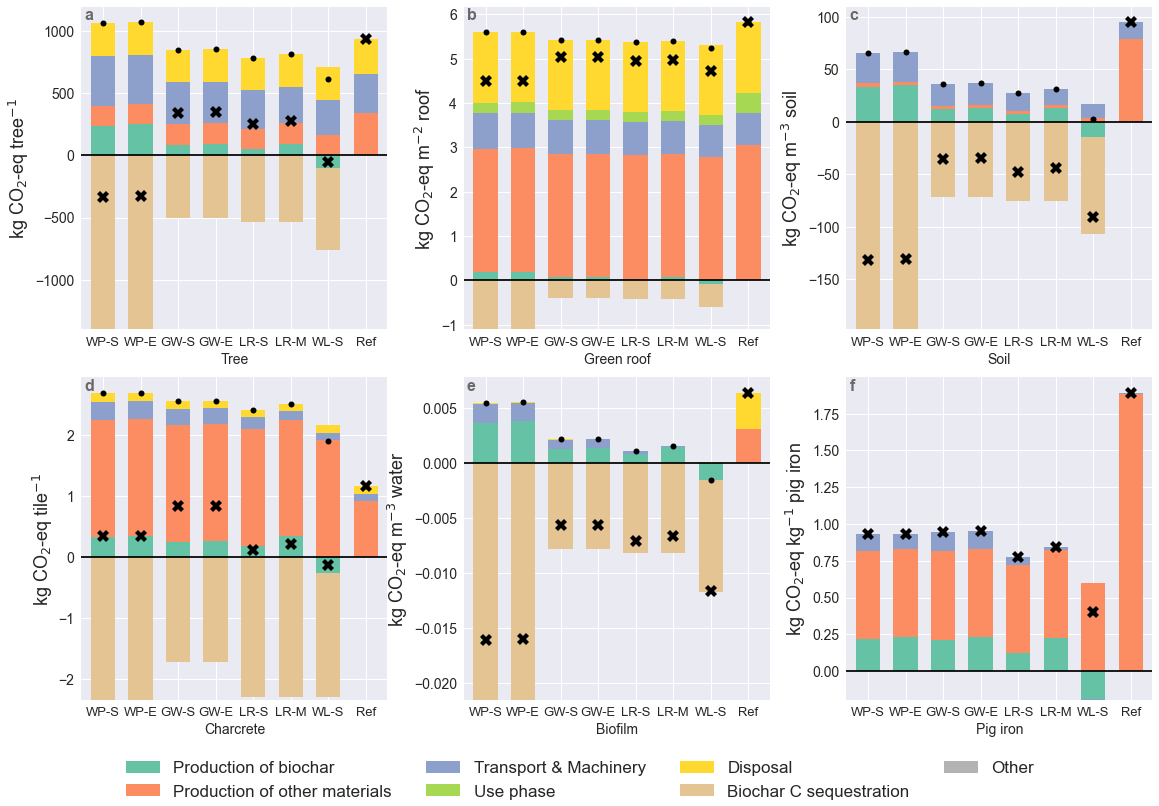

In [92]:
list_dfs = [usesZ_all, usesNZ_all]

# merge df in one, to have same columns everywhere
result_dfAllOne = pd.DataFrame()
for d in list_dfs:
    result_dfAllOne = result_dfAllOne.append(d)
    #print(list(d.columns))
    continue
result_dfAllOne.fillna(0, inplace=True)

col_reordered = ['Supply of biochar',
                 'Supply of other material',
                 'Machinery',
                 'Transport',
                 'Use phase',
                 'Disposal',
                 'Disposal of other material',
                 'Disposal of other material - avoided energy',
                 'Other',
                'C-sink',]
result_dfAllOne = result_dfAllOne[ col_reordered ]

# aggregate columns old col: new col
aggr_map = {
    'Supply of biochar':'Production of biochar',
    'Supply of other material':'Production of other materials',
    'Machinery':'Transport & Machinery',
    'Transport':'Transport & Machinery',
    'Use phase':'Use phase',
    'Disposal':'Disposal',
    'Disposal of other material':'Disposal',
    'Disposal of other material - avoided energy':'Disposal',
    'C-sink':'Biochar C sequestration',
    'Other':'Other',
}
result_dfAllOne_agg = pd.DataFrame()
for key, val in aggr_map.items():
    if val in result_dfAllOne_agg.columns:
        result_dfAllOne_agg[val] += result_dfAllOne[key]
    else:
        result_dfAllOne_agg[val] = result_dfAllOne[key] 
result_dfAllOne = result_dfAllOne_agg


result_dfAllOne.sort_index(sort_remaining=False, inplace=True)


# init figure
figAllOne, axAllOne = plt.subplots(nrows=2, ncols=3, 
                        figsize=(17,5.5*2),
                        sharex=False)
axAllOne_line = axAllOne.ravel()
# names
name_series = [key for key in biochar_types] + ['Ref'] # ['X'] + 
name_products = ['Tree', 'Green roof', 'Soil', 'Charcrete', 'Biofilm', 'Pig iron']
unit_products = [r'kg CO$_2$-eq tree$^{-1}$', r'kg CO$_2$-eq m$^{-2}$ roof', r'kg CO$_2$-eq m$^{-3}$ soil',
                 r'kg CO$_2$-eq tile$^{-1}$', r'kg CO$_2$-eq m$^{-3}$ water', r'kg CO$_2$-eq kg$^{-1}$ pig iron']
sub_annotation = ['a', 'b', 'c', 'd', 'e', 'f']

ii = [0, 1, 4, 2, 3, 5] # re-order plots with df sroted products: df_prod i > goes to > ax ii
n = len(name_series)
for i in range(result_dfAllOne.shape[0]//n ):
    sub_tmp = result_dfAllOne.iloc[i*n:(i+1)*n]
    sub_tmp = sub_tmp.xs(result_dfAllOne.index[0][2], axis=0, level=2, drop_level=True) # select impact category
    sub_tmp = sub_tmp.query("FU_amount == '1'")
    barv_toAxes(axAllOne_line[ii[i]], sub_tmp, name_series, 
            name_products[ii[i]], unit_products[ii[i]], 10,
            'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
            0.65)
    axAllOne_line[i].annotate(sub_annotation[i], xy=(0.01,0.96), xycoords='axes fraction',
                              fontsize=16, color='dimgrey',fontweight='bold')
    
    axAllOne_line[ii[i]].tick_params(axis='y', labelsize= 14)
    axAllOne_line[ii[i]].tick_params(axis='x', labelsize= 13)
    
# get overall legend, from one of the axes, be sure that all axes have same columns (i.e. from same orginal df)
handles, labels = axAllOne_line[0].get_legend_handles_labels()
figAllOne.legend(handles, labels, loc='lower center', ncol=4, borderaxespad=-0,fontsize=17,)

#figAllOne.tight_layout()
plt.subplots_adjust(top=1, right=1, wspace=0.25, hspace=0.15)


#save img to disk
figname = '3_ProductHotspot'+'_CC'
figAllOne.savefig('img/Figure_'+figname+'.png', dpi=600, bbox_inches='tight')
# save df to Excel 
append_df_to_excel(export2Excel_figureData, result_dfAllOne.T, sheet_name=figname)


### Run Z-loop for ILCD

In [117]:
usesZNZ_all_ILCD = pd.DataFrame({})

fg_dbs = ['use_1_tree-planting',
      'use_2_green-roof',
      'use_3_charcrete', 
      'use_4_filter', 
      'use_6_soil private',
      'use_7_benchmark',
      'pro_biochar', 'material', 'background-system','biomass']
label = 'gr_lca'
default_tag = 'Other'
    
meth = ILCD # all but CC
meth_unit = ILCD_units  # all but CC
    
# Z products
fus = [ {x.key:1} for x in all_acts_Z ] # list of FUs
for key in biochar_types:
    updateBiocharZ(to=key) # update the biochar types, and recalculate all formulas   
    uZ_df = run_graphTaggedTraversal(fus, meth, meth_unit, label, default_tag, fg_dbs, bio2tech=True, parent4other=True)  
    usesZNZ_all_ILCD = usesZNZ_all_ILCD.append(uZ_df, sort=False)

# Ref. products
all_ref_acts = [x for i,x in enumerate(all_acts_nZ) if not i % 2]
fus = [ {x.key:1} for x in all_ref_acts ] # list of FUs
uZ_df = run_graphTaggedTraversal(fus, meth, meth_unit, label, default_tag, fg_dbs, bio2tech=True, parent4other=True)  
usesZNZ_all_ILCD = usesZNZ_all_ILCD.append(uZ_df, sort=False)

# save & load df
append_df_to_excel(export2Excel_rawData, usesZNZ_all_ILCD, sheet_name='raw_usesZNZ_ILCD_all_clean')

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
lifecycle, water pre-treatment, biochar Z biofilter 1
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching t

Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method

Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatme

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method 

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method

Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method 

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_pla

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method

Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method 

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
production and supply of planting soil A, biochar Z 1
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching t

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
dis

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method 

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd07130

disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_macadam___mm_948d531d5ffbd69c657aeedc6188c483
production_

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method 

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method 

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  1

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  

Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method

Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  1

Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method

Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method

Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  1

Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method

Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14
Switching to method  0
Switching to method  1
Switching to method  2
Switching to method  3
Switching to method  4
Switching to method  5
Switching to method  6
Switching to method  7
Switching to method  8
Switching to method  9
Switching to method  10
Switching to method  11
Switching to method  12
Switching to method  13
Switching to method  14


In [118]:
# save & load df
usesZNZ_all_ILCD = pd.read_excel(export2Excel_rawData, sheet_name='raw_usesZNZ_ILCD_all_clean', index_col=[0,1,2,3])
usesZNZ_all_ILCD = usesZNZ_all_ILCD.reset_index()
usesZNZ_all_ILCD = usesZNZ_all_ILCD.set_index(['FU', 'FU_amount', 'Impact', 'Units'], append=True)
usesZNZ_all_ILCD.fillna(0, inplace=True)

In [119]:
# columns re-ordering # retrieved from list(result_dfAllOne.columns)
col_reordered = ['Supply of biochar',
                 'Supply of other material',
                 'Machinery',
                 'Transport',
                 'Use phase',
                 'Disposal',
                 'Disposal of other material',
                 'Disposal of other material - avoided energy',
                 'Other',
                'C-sink',]
usesZNZ_all_ILCD = usesZNZ_all_ILCD[ col_reordered ]

# aggregate columns old col: new col
aggr_map = {
    'Supply of biochar':'Production of biochar',
    'Supply of other material':'Production of other materials',
    'Machinery':'Transport & Machinery',
    'Transport':'Transport & Machinery',
    'Use phase':'Use phase',
    'Disposal':'Disposal',
    'Disposal of other material':'Disposal',
    'Disposal of other material - avoided energy':'Disposal',
    'C-sink':'C-sink',
    'Other':'Other',
}
usesZNZ_all_ILCD_agg = pd.DataFrame()
for key, val in aggr_map.items():
    if val in usesZNZ_all_ILCD_agg.columns:
        usesZNZ_all_ILCD_agg[val] += usesZNZ_all_ILCD[key]
    else:
        usesZNZ_all_ILCD_agg[val] = usesZNZ_all_ILCD[key] 
usesZNZ_all_ILCD = usesZNZ_all_ILCD_agg

In [120]:
# data preparation before plot
tmp = usesZNZ_all_ILCD # sum over grouping - we don't need the grouping
#tmp = tmp.pivot_table(index=['FU', 'FU_amount', 'Units'], columns=['Impact'], aggfunc=np.sum)
#tmp = tmp[0] # droping the 0 column level
#tmp = tmp.rename(eval, axis='columns') # needed after reload from Excel, cause tuple is str
#land_use_shortName = {('ILCD 2.0 2018 midpoint', 'resources', 'land use'):'land use'}
#tmp = tmp.rename(land_use_shortName, axis='columns') # short names
tmp = tmp.fillna(0) 
#tmp = tmp.groupby(['FU', 'FU_amount', 'Units'], sort=False).sum() # group rows, keep order 

bcs = ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR-S', 'LR-M', 'WL-S', 'R']
new_bcs = []
n_pro = 6
n_imp = 15
for x in bcs:
    for i in range(n_imp*n_pro):
        new_bcs.append(x)
new_bcs
if len(new_bcs) == len(tmp):
    tmp['SC'] = new_bcs
    tmp.set_index(['SC'], append=True, inplace=True)
tmp.head(3)

Production of biochar  \
  FU                                                 FU_amount Impact                                             Units          SC                            
0 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'ecosystem quality',... mol $H^{+}$-Eq WP-S              58.584870   
1 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'non... CTUh           WP-S              -0.000230   
2 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'car... CTUh           WP-S               0.000013   

                                                                                                                                       Production of other materials  \
  FU                                                 FU_amount Impact                                             Units          SC                                    
0 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'ecosystem quality',... mol $H^{+}$-Eq WP-S                     401.002304   
1 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'non... CTUh           WP-S                       0.000047   
2 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'car... CTUh           WP-S                       0.000026   

                                                                                                                                       Transport & Machinery  \
  FU                                                 FU_amount Impact                                             Units          SC                            
0 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'ecosystem quality',... mol $H^{+}$-Eq WP-S            1378.608371   
1 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'non... CTUh           WP-S               0.000345   
2 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'car... CTUh           WP-S               0.000007   

                                                                                                                                       Use phase  \
  FU                                                 FU_amount Impact                                             Units          SC                
0 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'ecosystem quality',... mol $H^{+}$-Eq WP-S        0.0   
1 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'non... CTUh           WP-S        0.0   
2 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'car... CTUh           WP-S        0.0   

                                                                                                                                         Disposal  \
  FU                                                 FU_amount Impact                                             Units          SC                 
0 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'ecosystem quality',... mol $H^{+}$-Eq WP-S  797.056263   
1 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'non... CTUh           WP-S    0.000222   
2 establishment of new tree, in hard surface area... 1         ('ILCD 2.0 2018 midpoint', 'human health', 'car... CTUh           WP-S    0.000005   

                                                                                                                                       C-sink  \
  FU                                                 FU_amou

In [121]:
name_products = ['Tree', 'Green roof', 'Soil', 'Charcrete', 'Biofilm', 'Pig iron']
sub_annotation = ['a', 'b', 'c', 'd', 'e', 'f']

product_list = [ [#'establishment of new tree, in hard surface area, difference',
                #'establishment of new tree, in hard surface area, in biochar-makadam X',
                'establishment of new tree, in hard surface area, in biochar-makadam Z',
                'establishment of new tree, in hard surface area, in soil-makadam',],
 
                [#'lifecycle, extensive green roof, XMS 2-27, biochar X',
                 'lifecycle, extensive green roof, XMS 2-27, biochar Z',
                 #'lifecycle, extensive green roof, XMS 2-27, difference',
                 'lifecycle, extensive green roof, XMS 2-27, reference',],

                [#'production and supply of landscaping soil A, biochar X',
                'production and supply of planting soil A, biochar Z',
                 #'production and supply of landscaping soil A, difference',
                 'production and supply of planting soil A, reference',],
                
                [#'production of paving stone, charcrete X',
                 'production of paving stone, charcrete Z',
                 #'production of paving stone, difference',
                 'production of paving stone, normal concrete',],    
    
                [#'lifecycle, water pre-treatment, biochar X biofilter',
                 'lifecycle, water pre-treatment, biochar Z biofilter',
                 #'lifecycle, water pre-treatment, difference',
                 'lifecycle, water pre-treatment, plastic biofilter',],          
     
                [#'production of pig iron, bio-coal X',
                 'production of pig iron, bio-coal Z',
                 #'production of pig iron, difference',
                 'production of pig iron, fossil-coal']]

# supply chains to select
SC_list = ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR-S', 'LR-M', 'WL-S', 'R']

### Figure - Product lifecycles: Resources

establishment of new tree, in hard surface area, in biochar-makadam Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

lifecycle, extensive green roof, XMS 2-27, biochar Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production and supply of planting soil A, biochar Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production of paving stone, charcrete Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

lifecycle, water pre-treatment, biochar Z biofilter


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production of pig iron, bio-coal Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

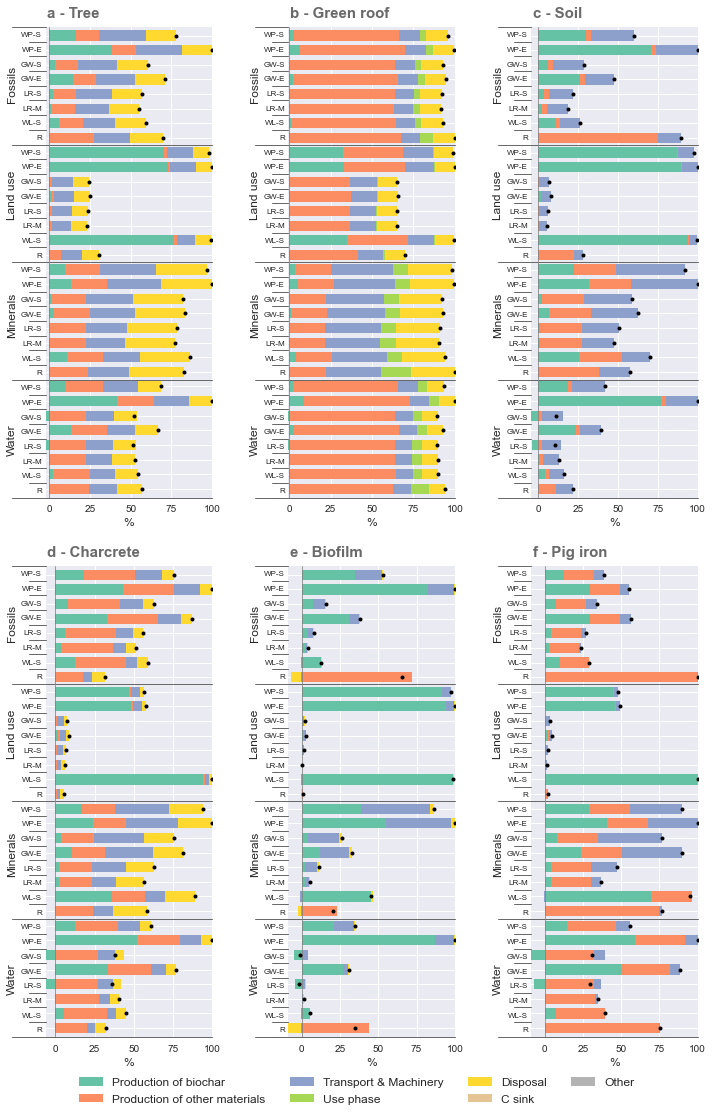

In [122]:
ILCD_res_fig, ILCD_res_ax = plt.subplots(nrows=2, ncols=3, figsize=(10,15))
ILCD_res_ax_line = ILCD_res_ax.ravel()

impact_list = ["('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals')",
               "('ILCD 2.0 2018 midpoint', 'resources', 'fossils')",
               "('ILCD 2.0 2018 midpoint', 'resources', 'land use')",
               "('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water')",   
                ]
impact_map = {"('ILCD 2.0 2018 midpoint', 'resources', 'minerals and metals')" : 'Minerals',
               "('ILCD 2.0 2018 midpoint', 'resources', 'fossils')" : 'Fossils',
               "('ILCD 2.0 2018 midpoint', 'resources', 'land use')" : 'Land use',
               "('ILCD 2.0 2018 midpoint', 'resources', 'dissipated water')": 'Water',    
}

for i, pro_l in enumerate(product_list):
    print(pro_l[0])
    # each product group, make tmp query
    sub_tmp = tmp.query('FU in @pro_l & Impact in @impact_list & SC in @SC_list').copy()
    #normalise
    sub_tmp = normalize_by_group(sub_tmp, level=3) # normalisation, to plot to 100% 
    sub_tmp = sub_tmp.droplevel(level = ['FU_amount', 'Units'], axis=0) # keeping the index number
    sub_tmp = sub_tmp.reorder_levels(['Impact','FU','SC',0]) # placing impact first, product name in second ... but .. we have
    
    sub_tmp = sub_tmp.droplevel(level = ['FU', 3], axis=0) # need only 2 levels, for the plot function
    
    # re-name 
    sub_tmp.rename(mapper=impact_map, level='Impact', inplace=True)
    #sub_tmp.rename(mapper=product_map, level=1, inplace=True) # no need to renme anymore
    sub_tmp.sort_index(level=0, sort_remaining=False, inplace=True)
    
    # reverse axis
    sub_tmp.iloc[::-1].plot(kind='barh', stacked=True, ax=ILCD_res_ax_line[i],
                        width=0.70,colormap='Set2', legend=None)
    typ = 'barh'
    if typ == 'barh':        
        ILCD_res_ax_line[i].set_xlabel('%', fontsize=12)
        ILCD_res_ax_line[i].set_yticklabels('')
        ILCD_res_ax_line[i].set_ylabel('')
        label_group_bar_table3(ILCD_res_ax_line[i], sub_tmp.iloc[::-1], font=[8, 12])
        ILCD_res_ax_line[i].set_xlim(left=None,right=100)
    else:
        ILCD_res_ax_line[i].set_ylabel('%', fontsize=12)
        ILCD_res_ax_line[i].set_xticklabels('')
        ILCD_res_ax_line[i].set_xlabel('')
        label_group_bar_table2(ILCD_res_ax_line[i], sub_tmp, font=[8, 12])

    # net score line
    total_score = sub_tmp.iloc[::-1].sum(axis=1)
    ILCD_res_ax_line[i].plot(total_score, np.arange(0,sub_tmp.shape[0],1) ,'.', color='black', markersize=8)
    
    # sub-fig annotations
    ILCD_res_ax_line[i].annotate(sub_annotation[i]+' - '+ name_products[i], xy=(+0.01,1.02), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 

# legend
handles, labels = ILCD_res_ax_line[0].get_legend_handles_labels()
labels = ['Production of biochar',
 'Production of other materials',
 'Transport & Machinery',
 'Use phase',
 'Disposal',
 'C sink',
 'Other']
ILCD_res_fig.legend(handles, labels, loc='lower center', ncol=4,fontsize=12, 
                    borderaxespad=-0.8, bbox_to_anchor=(0.5, -0.020))
ILCD_res_fig.tight_layout(h_pad=2, w_pad=3)

#save img to disk
figname = '3_ProductHotspot_Res'+'_clean'
ILCD_res_fig.savefig('img/Figure_'+figname+'.png', dpi=600, bbox_inches='tight')

# save df to Excel 
append_df_to_excel(export2Excel_figureData, tmp.T, sheet_name=figname)

### Figure - Product lifecycles: Human toxicity

establishment of new tree, in hard surface area, in biochar-makadam Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

lifecycle, extensive green roof, XMS 2-27, biochar Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production and supply of planting soil A, biochar Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production of paving stone, charcrete Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

lifecycle, water pre-treatment, biochar Z biofilter


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production of pig iron, bio-coal Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

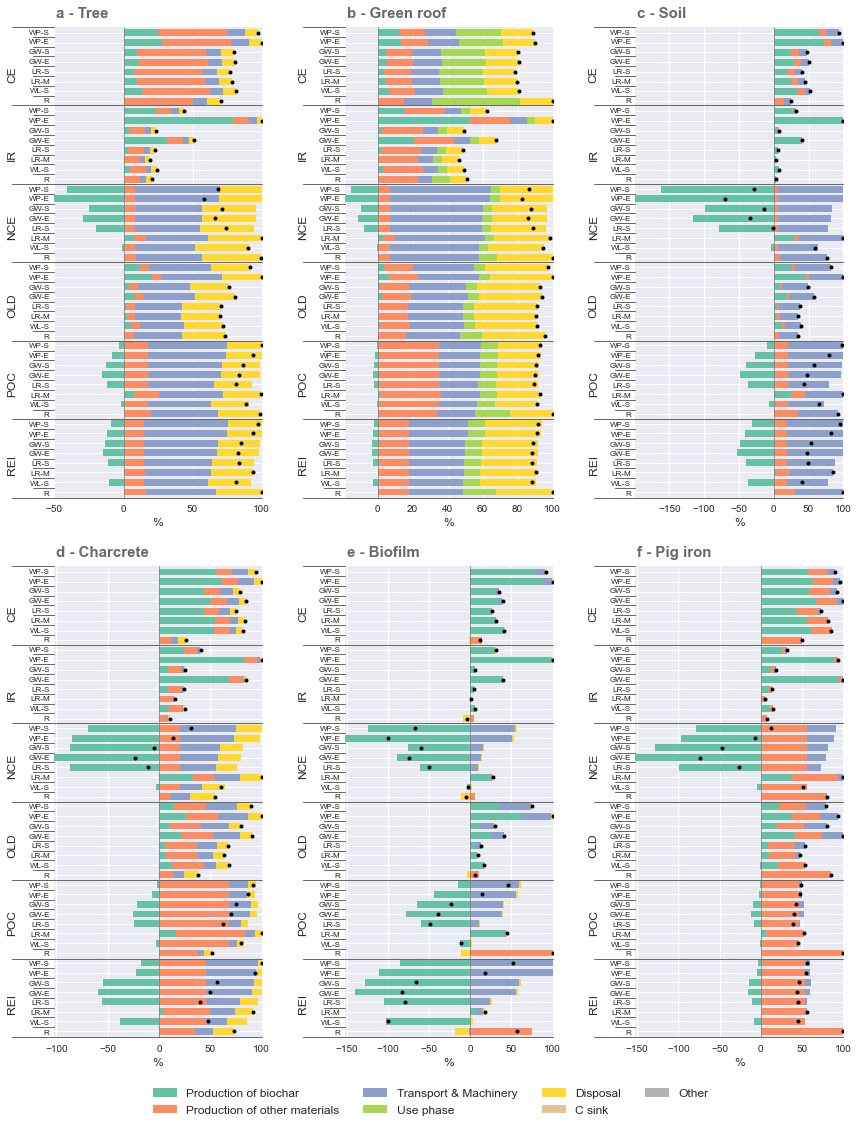

In [123]:
ILCD_tox_fig, ILCD_tox_ax = plt.subplots(nrows=2, ncols=3, figsize=(12,15))
ILCD_tox_ax_line = ILCD_tox_ax.ravel()

impact_list = [
 "('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation')",
 "('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion')",
 "('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation')",
 "('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics')",
 "('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects')",
 "('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects')",]

impact_map = {
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity')" : 'FT',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality','freshwater and terrestrial acidification')" : 'FTA',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication')" : 'FE',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication')" : 'ME',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication')" : 'TE',
 "('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation')" : 'IR',
 "('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion')" : 'OLD',
 "('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation')" : 'POC',
 "('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics')" : 'REI',
 "('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects')" : 'NCE',
 "('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects')" : 'CE',
}

for i, pro_l in enumerate(product_list):
    print(pro_l[0])
    # each product group, make tmp query
    sub_tmp = tmp.query('FU in @pro_l & Impact in @impact_list & SC in @SC_list').copy()
    #normalise
    sub_tmp = normalize_by_group(sub_tmp, level=3) # normalisation, to plot to 100% 
    sub_tmp = sub_tmp.droplevel(level = ['FU_amount', 'Units'], axis=0) # keeping the index number
    sub_tmp = sub_tmp.reorder_levels(['Impact','FU','SC',0]) # placing impact first, product name in second ... but .. we have
    
    sub_tmp = sub_tmp.droplevel(level = ['FU', 3], axis=0) # need only 2 levels, for the plot function
    
    # re-name 
    sub_tmp.rename(mapper=impact_map, level='Impact', inplace=True)
    #sub_tmp.rename(mapper=product_map, level=1, inplace=True) # no need to renme anymore
    sub_tmp.sort_index(level=0, sort_remaining=False, inplace=True)
    
    # reverse axis
    sub_tmp.iloc[::-1].plot(kind='barh', stacked=True, ax=ILCD_tox_ax_line[i],
                        width=0.70,colormap='Set2', legend=None)
    typ = 'barh'
    if typ == 'barh':        
        ILCD_tox_ax_line[i].set_xlabel('%', fontsize=12)
        ILCD_tox_ax_line[i].set_yticklabels('')
        ILCD_tox_ax_line[i].set_ylabel('')
        label_group_bar_table3(ILCD_tox_ax_line[i], sub_tmp.iloc[::-1], font=[8, 12])
        ILCD_tox_ax_line[i].set_xlim(left=None,right=100)
    else:
        ILCD_tox_ax_line[i].set_ylabel('%', fontsize=12)
        ILCD_tox_ax_line[i].set_xticklabels('')
        ILCD_tox_ax_line[i].set_xlabel('')
        label_group_bar_table2(ILCD_tox_ax_line[i], sub_tmp, font=[8, 12])

    # net score line
    total_score = sub_tmp.iloc[::-1].sum(axis=1)
    ILCD_tox_ax_line[i].plot(total_score, np.arange(0,sub_tmp.shape[0],1) ,'.', color='black', markersize=8)
    
    # sub-fig annotations
    ILCD_tox_ax_line[i].annotate(sub_annotation[i]+' - '+ name_products[i], xy=(+0.01,1.02), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 

# legend
handles, labels = ILCD_tox_ax_line[0].get_legend_handles_labels()
labels = ['Production of biochar',
 'Production of other materials',
 'Transport & Machinery',
 'Use phase',
 'Disposal',
 'C sink',
 'Other']
ILCD_tox_fig.legend(handles, labels, loc='lower center', ncol=4,fontsize=12, 
                    borderaxespad=-0.8, bbox_to_anchor=(0.5, -0.030))
ILCD_tox_fig.tight_layout(h_pad=2, w_pad=3)

#save img to disk
figname = '3_ProductHotspot_humtox'+'_clean'
ILCD_tox_fig.savefig('img/Figure_'+figname+'.png', dpi=600, bbox_inches='tight')

# save df to Excel 
append_df_to_excel(export2Excel_figureData, tmp.T, sheet_name=figname)

### Figure - Product lifecycles: Ecotoxicity

establishment of new tree, in hard surface area, in biochar-makadam Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

lifecycle, extensive green roof, XMS 2-27, biochar Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production and supply of planting soil A, biochar Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production of paving stone, charcrete Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

lifecycle, water pre-treatment, biochar Z biofilter


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

production of pig iron, bio-coal Z


C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eazzi\.conda\envs\bw2\lib\site-packages\pandas\plotting\_tools.py:313: 

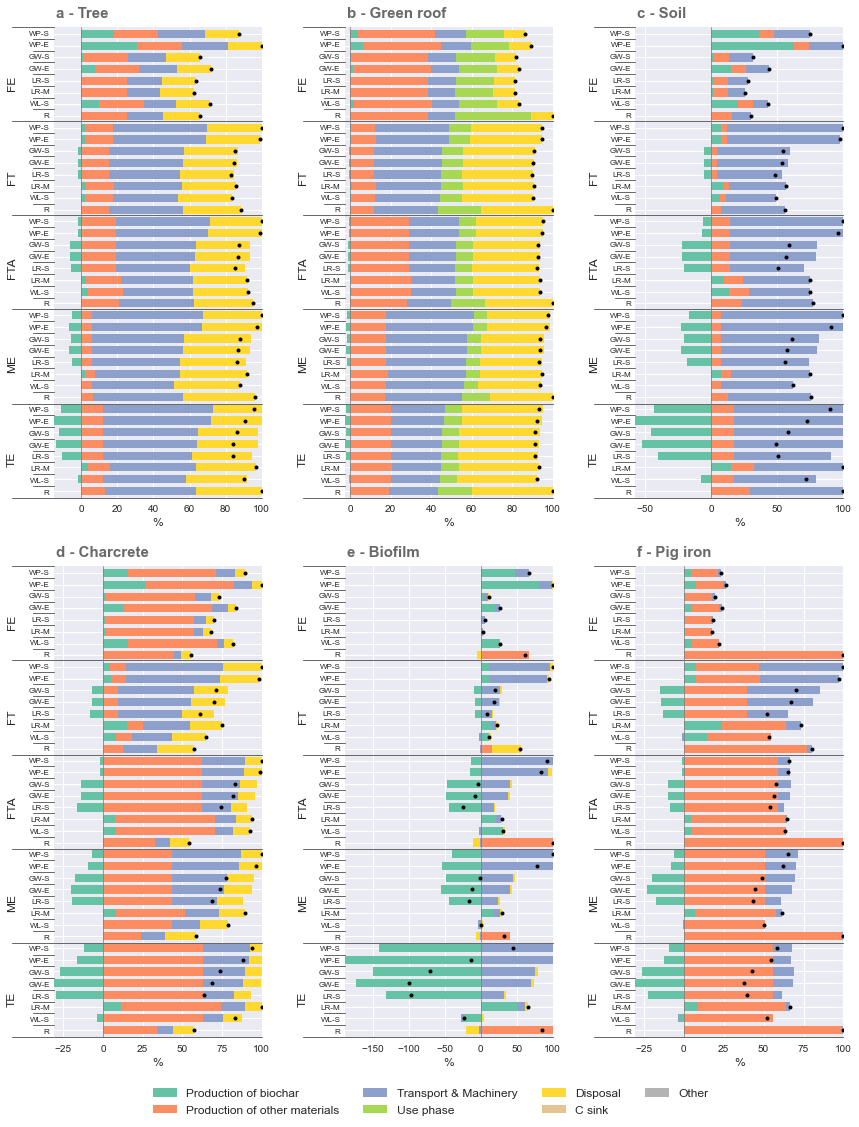

In [124]:
ILCD_ecotox_fig, ILCD_ecotox_ax = plt.subplots(nrows=2, ncols=3, figsize=(12,15))
ILCD_ecotox_ax_line = ILCD_ecotox_ax.ravel()

impact_list = [
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity')",
 str(ILCD[4]),
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication')",
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication')",
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication')",
]

impact_map = {
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater ecotoxicity')" : 'FT',
 str(ILCD[4]) : 'FTA',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'freshwater eutrophication')" : 'FE',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'marine eutrophication')" : 'ME',
 "('ILCD 2.0 2018 midpoint', 'ecosystem quality', 'terrestrial eutrophication')" : 'TE',
 "('ILCD 2.0 2018 midpoint', 'human health', 'ionising radiation')" : 'IR',
 "('ILCD 2.0 2018 midpoint', 'human health', 'ozone layer depletion')" : 'OLD',
 "('ILCD 2.0 2018 midpoint', 'human health', 'photochemical ozone creation')" : 'POC',
 "('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics')" : 'REI',
 "('ILCD 2.0 2018 midpoint', 'human health', 'non-carcinogenic effects')" : 'NCE',
 "('ILCD 2.0 2018 midpoint', 'human health', 'carcinogenic effects')" : 'CE',
}

for i, pro_l in enumerate(product_list):
    print(pro_l[0])
    # each product group, make tmp query
    sub_tmp = tmp.query('FU in @pro_l & Impact in @impact_list & SC in @SC_list').copy()
    #normalise
    sub_tmp = normalize_by_group(sub_tmp, level=3) # normalisation, to plot to 100% 
    sub_tmp = sub_tmp.droplevel(level = ['FU_amount', 'Units'], axis=0) # keeping the index number
    sub_tmp = sub_tmp.reorder_levels(['Impact','FU','SC',0]) # placing impact first, product name in second ... but .. we have
    
    sub_tmp = sub_tmp.droplevel(level = ['FU', 3], axis=0) # need only 2 levels, for the plot function
    
    # re-name 
    sub_tmp.rename(mapper=impact_map, level='Impact', inplace=True)
    #sub_tmp.rename(mapper=product_map, level=1, inplace=True) # no need to renme anymore
    sub_tmp.sort_index(level=0, sort_remaining=False, inplace=True)
    
    sub_tmp.iloc[::-1].plot(kind='barh', stacked=True, ax=ILCD_ecotox_ax_line[i],
                        width=0.70,colormap='Set2', legend=None)
    typ = 'barh'
    if typ == 'barh':        
        ILCD_ecotox_ax_line[i].set_xlabel('%', fontsize=12)
        ILCD_ecotox_ax_line[i].set_yticklabels('')
        ILCD_ecotox_ax_line[i].set_ylabel('')
        label_group_bar_table3(ILCD_ecotox_ax_line[i], sub_tmp.iloc[::-1], font=[8, 12])
        ILCD_ecotox_ax_line[i].set_xlim(left=None,right=100)
    else:
        ILCD_ecotox_ax_line[i].set_ylabel('%', fontsize=12)
        ILCD_ecotox_ax_line[i].set_xticklabels('')
        ILCD_ecotox_ax_line[i].set_xlabel('')
        label_group_bar_table2(ILCD_ecotox_ax_line[i], sub_tmp, font=[8, 12])

    # net score line
    total_score = sub_tmp.iloc[::-1].sum(axis=1)
    ILCD_ecotox_ax_line[i].plot(total_score, np.arange(0,sub_tmp.shape[0],1) ,'.', color='black', markersize=8)

    # sub-fig annotations
    ILCD_ecotox_ax_line[i].annotate(sub_annotation[i]+' - '+ name_products[i], xy=(+0.01,1.02), xycoords='axes fraction',
                              fontsize=15, color='dimgrey',fontweight='bold') 

# legend
handles, labels = ILCD_ecotox_ax_line[0].get_legend_handles_labels()
labels = ['Production of biochar',
 'Production of other materials',
 'Transport & Machinery',
 'Use phase',
 'Disposal',
 'C sink',
 'Other']
ILCD_ecotox_fig.legend(handles, labels, loc='lower center', ncol=4,fontsize=12, 
                    borderaxespad=-0.8, bbox_to_anchor=(0.5, -0.030))
ILCD_ecotox_fig.tight_layout(h_pad=2, w_pad=3)

#save img to disk
figname = '3_ProductHotspot_ecotox'+'_clean'
ILCD_ecotox_fig.savefig('img/hotspot_'+figname+'.png', dpi=600, bbox_inches='tight')

# save df to Excel 
append_df_to_excel(export2Excel_figureData, tmp.T, sheet_name=figname)

### Define FU for ranking & run Z-loop

In [16]:
# select biochar market activity
ract = searchActivity(ins=['use', 'Z'],
                    outs=['ranking'],
                    db='ranking')

ract.sort(reverse=True)
re_order = [1,0,5,3,2,4]# [1, 2, 0]
if len(re_order)>0:
    ract = [ ract[i] for i in re_order] 
ract

['use_1Z_tree-planting-macadam' (unit biochar, GLO, None),
 'use_2Z_green-roof' (unit biochar, GLO, None),
 'use_6Z_landscaping-soil' (unit biochar, GLO, None),
 'use_3Z_pavingstone' (unit biochar, GLO, None),
 'use_4Z_waterbiofilter' (unit biochar, GLO, None),
 'use_7Z_pig-iron' (unit biocoal, GLO, None)]

In [126]:
## Switch params and re-do benchmark of biochars
mrg_el = [0,1,2]
mrg_heat = [0,1,2]
mrg_fuel = [0.7, 1] # share of fossil-fuel in diesel market

# update parameters - ELEC
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_el') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted) # 2: natural gas combi cycle
bw2.parameters.new_project_parameters(wanted, overwrite=True)

# update parameters - HEAT
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_heat') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted) # 1: heavy-fuel oil, 2: natural gas
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...


# update parameters - BIOFUEL
wanted = []
wanted = searchParameters('mrg_fuel_1')
wanted[0]['amount'] = mrg_fuel[0] # 0 : average, 1: fossil system
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...


bw2.parameters.recalculate() # needed, for all relationships to be recalculated 

[{'name': 'mrg_el_1', 'amount': 0.0}, {'name': 'mrg_el_2', 'formula': '', 'amount': 1.0}, {'name': 'mrg_el_3', 'amount': 1.0}]
[{'name': 'mrg_heat_1', 'amount': 0.0}, {'name': 'mrg_heat_2', 'amount': 1.0}, {'name': 'mrg_heat_3', 'amount': 1.0}]
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urba

production_of_paving_stone_normal_concrete_827297bb5e8df0f20a821201ad3fe543
production_of_paving_stone_normal_concrete_827297bb5e8df0f20a821201ad3fe543
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_p

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_

In [127]:
fg_dbs = ['use_1_tree-planting',
          'use_2_green-roof',
          'use_3_charcrete', 
          'use_4_filter', 
          'use_6_soil private',
          'use_7_benchmark',
          'pro_biochar', 'material', 'background-system', 'biomass']
label = 'gr_lca' # gr_lca (default) gr_bc (explicit RLBU) or gr_kappa
default_tag = 'Other'

meth = IPCC #EcoScarEnergy #[subset_methods[3]]#IPCC
meth_unit = IPCC_unit #EcoScarEnergy_unit #[subset_methods_units[3]] #IPCC_unit

result_df_rZ = pd.DataFrame({})

for key in ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR-S', 'WL-S']:
    updateBiocharZ(to=key) # update the biochar types, and recalculate all formulas
    
    # calculate how much biochar there is in each of these activities
    how_much = []
    for a in ract:
        val, df = how_much_biochar(a, 1)
        how_much.append(float(val))
    # define adjusted fus
    fus = [ {x.key:1000/how_much[i]} for i,x in enumerate(ract)] # list of FUs
    fus
    
    result_df_rZd = run_graphTaggedTraversal(fus,meth,meth_unit, label,default_tag, fg_dbs, bio2tech=True, parent4other=True)
    result_df_rZd['SC'] = [key]*len(result_df_rZd)
    result_df_rZ = result_df_rZ.append(result_df_rZd)

result_df_rZ.set_index(keys=['SC'], append=True, inplace=True)
# save to Excel
append_df_to_excel(export2Excel_rawData, result_df_rZ, sheet_name='raw_ranking_Z_CC_clean_'+label)

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd07130

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_pla

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd07130

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504

use_3Z_pavingstone 1394.9722502269778
use_4Z_waterbiofilter 262960.1782617255
use_7Z_pig-iron 1601.4479950371692


Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd07130

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
dis

disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_macadam___mm_948d531d5ffbd69c657aeedc6188c483
production_

In [128]:
## Switch params and re-do benchmark of biochars
mrg_el = [0,1,2]
mrg_heat = [0,1,2]
mrg_fuel = [0.7, 1] # share of fossil-fuel in diesel market

# update parameters - ELEC
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_el') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(2, wanted) # 2: natural gas combi cycle
bw2.parameters.new_project_parameters(wanted, overwrite=True)

# update parameters - HEAT
wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_heat') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(2, wanted) # 1: heavy-fuel oil, 2: natural gas
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...


# update parameters - BIOFUEL
wanted = []
wanted = searchParameters('mrg_fuel_1')
wanted[0]['amount'] = mrg_fuel[1] # 0 : average, 1: fossil system
bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...


bw2.parameters.recalculate() # needed, for all relationships to be recalculated 

[{'name': 'mrg_el_1', 'amount': 0.0}, {'name': 'mrg_el_2', 'formula': '', 'amount': 1.0}, {'name': 'mrg_el_3', 'amount': 1.0}]
[{'name': 'mrg_heat_1', 'amount': 0.0}, {'name': 'mrg_heat_2', 'amount': 1.0}, {'name': 'mrg_heat_3', 'amount': 1.0}]
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urba

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_

In [129]:
fg_dbs = ['use_1_tree-planting',
          'use_2_green-roof',
          'use_3_charcrete', 
          'use_4_filter', 
          'use_6_soil private',
          'use_7_benchmark',
          'pro_biochar', 'material', 'background-system', 'biomass']
#label = 'gr_lca' ## commented away because supposed to be run with previous block code
default_tag = 'Other'

meth = IPCC #EcoScarEnergy #[subset_methods[3]]#IPCC
meth_unit = IPCC_unit #EcoScarEnergy_unit #[subset_methods_units[3]] #IPCC_unit

result_df_rZ_dirty = pd.DataFrame({})

for key in ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR-S', 'WL-S']:
    updateBiocharZ(to=key) # update the biochar types, and recalculate all formulas
    
    # calculate how much biochar there is in each of these activities
    how_much = []
    for a in ract:
        val, df = how_much_biochar(a, 1)
        how_much.append(float(val))
    # define adjusted fus
    fus = [ {x.key:1000/how_much[i]} for i,x in enumerate(ract)] # list of FUs
    fus
    
    result_df_rZd = run_graphTaggedTraversal(fus,meth,meth_unit, label,default_tag, fg_dbs, bio2tech=True, parent4other=True)
    result_df_rZd['SC'] = [key]*len(result_df_rZd)
    result_df_rZ_dirty = result_df_rZ_dirty.append(result_df_rZd)

result_df_rZ_dirty.set_index(keys=['SC'], append=True, inplace=True)

# save to Excel
append_df_to_excel(export2Excel_rawData, result_df_rZ_dirty, sheet_name='raw_ranking_Z_CC_dirty_'+label)


Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatme

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
disposal_of_plastic_matrix_for_water_biofilter_de1e0278ce8295919261fe763cfb47cb
disposal_of_pla

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd07130

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial

Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matri

use_1Z_tree-planting-macadam 5.044122568876303
use_2Z_green-roof 6407.875727608392
use_6Z_landscaping-soil 35.72140076336398
use_3Z_pavingstone 1394.9722502269774
use_4Z_waterbiofilter 328022.49040895654
use_7Z_pig-iron 2090.876756135648


Param BCZ_C was already defined : overriding
Param BCZ_bd was already defined : overriding
Param BCZ_pd was already defined : overriding
Param BCZ_bp was already defined : overriding


soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0a

production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
lifecycle_water_pre_treatment_biochar_X_biofilter_70282fd544f166222528cd071301a028
dis

disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_paving_stone_charcrete_Z_91932504df00d9f5ce9d3cf873f0285e
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_of_pig_iron_bio_coal_X_cdac0a3815743727c2bcaf7e5408455d
production_and_supply_of_compost_industrial_26ade2b031e22ae7cf6dcfaf5fd07d3d
production_and_supply_of_compost_industrial_26ade2b031e2

### Figure - Ranking: Climate, clean+dirty energy system

SC    FU       
GW-S  Pig iron    -1.515173
      Biofilm     -1.105762
      Charcrete    1.930610
      Soil        -1.681837
      Roof        -2.034539
      Tree        -0.359278
WP-S  Pig iron    -2.011886
      Biofilm     -0.111102
      Charcrete    2.108725
      Soil        -0.402226
      Roof        -0.556726
      Tree         0.249529
dtype: float64
SC    FU       
GW-S  Pig iron     0.719566
      Biofilm      1.424782
      Charcrete    4.201957
      Soil         0.546984
      Roof         0.204331
      Tree         1.843414
WP-S  Pig iron     0.550970
      Biofilm      2.596322
      Charcrete    4.714486
      Soil         2.157447
      Roof         2.009711
      Tree         2.798270
dtype: float64


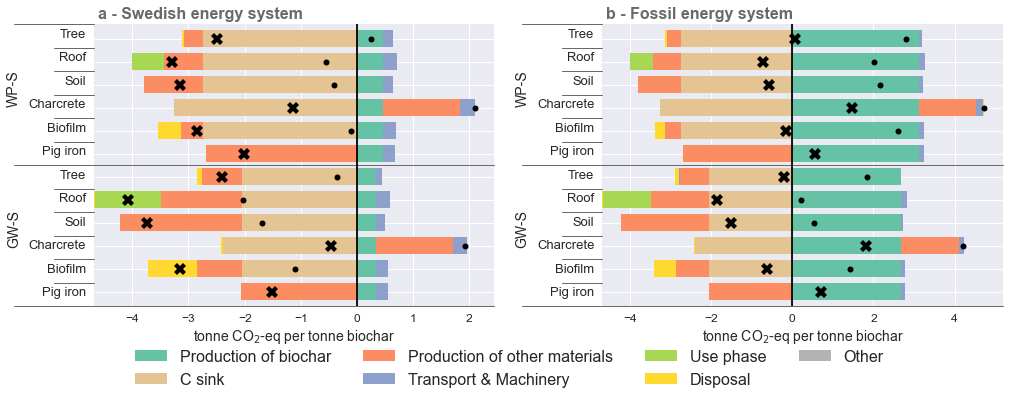

In [130]:
########################
### DATA PREPARATION ###
########################
from matplotlib import cm
import matplotlib.colors as mc
map3 = cm.get_cmap("Set2").colors
cmap2 = mc.ListedColormap(
     tuple((map3[0], map3[6],map3[1],map3[2],map3[4],map3[5],map3[7],  )) # with set2
    #tuple((map3[0], map3[1],map3[2],map3[3],map3[4],map3[5],map3[6],map3[7],map3[8],map3[9],  )) # with tab10
    )

label = 'gr_lca' # gr_lca (default) gr_bc (explicit RLBU) or gr_kappa
# load from disk
fp=export2Excel_rawData
result_df_rZ = pd.read_excel(fp, index_col=[0,1,2,3,4], sheet_name='raw_ranking_Z_CC_clean_'+label)
result_df_rZ_dirty = pd.read_excel(fp, index_col=[0,1,2,3,4], sheet_name='raw_ranking_Z_CC_dirty_'+label)

# aggregate, re-order, re-scale
def data_preparation(result_df_rZ_dirty, rescale=True):
    ''' All the data processing for a single df'''
    tmp = result_df_rZ_dirty.copy() # df copy
    tmp.fillna(value=0.0, inplace=True) # fill nan with 0
    #tmp = tmp.loc[:, (tmp != 0).any(axis=0)] # drop 0 colums
    sub_tmp = tmp.xs(tmp.index[0][2], axis=0, level=2, drop_level=True)  # select impact assessment method 'Climate' , xs = cross-section in df, via index levels
    # aggregate columns old col: new col
    aggr_map = { # for gr_kappa
        'Supply of biochar':'Production of biochar',
        'C-sink':'C-sink',
        'Pyrolysis energy substitution':'Pyrolysis energy substitution',
        'RLU':'RLU',
        'RBU':'RBU',
        
        'Supply of other material':'Production of other materials',
        'Machinery':'Transport & Machinery',
        'Transport':'Transport & Machinery',
        'Use phase':'Use phase',
        'Disposal':'Disposal',
        'Disposal of other material':'Disposal',
        'Disposal of other material - avoided energy':'Disposal',

        'Other':'Other',
    }
    aggr_map = { # for gr_lca
        'Supply of biochar':'Production of biochar',
        'C-sink':'C-sink',
        
        'Supply of other material':'Production of other materials',
        'Machinery':'Transport & Machinery',
        'Transport':'Transport & Machinery',
        'Use phase':'Use phase',
        'Disposal':'Disposal',
        'Disposal of other material':'Disposal',
        'Disposal of other material - avoided energy':'Disposal',

        'Other':'Other',
    }
    
    sub_tmp_agg = pd.DataFrame()
    for key, val in aggr_map.items():
        if val in sub_tmp_agg.columns:
            sub_tmp_agg[val] += sub_tmp[key]
        else:
            sub_tmp_agg[val] = sub_tmp[key] 
    sub_tmp = sub_tmp_agg

    # re-scale unit
    meth = IPCC #EcoScarEnergy #[subset_methods[3]]#IPCC
    meth_unit = IPCC_unit #EcoScarEnergy_unit #[subset_methods_units[3]] #IPCC_unit

    yname = meth_unit[0]+r' per tonne biochar'
    if rescale:
        sub_tmp = sub_tmp/1000
        sub_tmp = sub_tmp.droplevel('Units')
        sub_tmp['Units'] = [r't $CO_2$-eq']*len(sub_tmp)
        sub_tmp.set_index('Units', append=True, inplace=True)
        yname = r'tonne CO$_2$-eq per tonne biochar'

    sub_tmp = sub_tmp.droplevel(level = ['FU_amount', 'Units'], axis=0) # need only 2 levels, for the plot function

    FU_map = {
        'use_1Z_tree-planting-macadam':'Tree',
        'use_2Z_green-roof': 'Roof',
        'use_6Z_landscaping-soil': 'Soil',
        'use_3Z_pavingstone':'Charcrete',
        'use_4Z_waterbiofilter':'Biofilm',
        'use_7Z_pig-iron':'Pig iron',
    }
    sub_tmp.rename(mapper=FU_map, level='FU', inplace=True)
    #sub_tmp = sub_tmp.reorder_levels(['SC','FU'])
    pro_order = pd.CategoricalDtype(['Tree','Roof','Soil','Charcrete','Biofilm','Pig iron'],
                  ordered=True)

    group_by_product = False
    if group_by_product:
        sub_tmp.reset_index(level=['FU'], inplace=True)
        sub_tmp['FU'] = sub_tmp['FU'].astype(pro_order) 
        sub_tmp.sort_values('FU', inplace=True)
        sub_tmp.set_index('FU', append=True, inplace=True)
        sub_tmp = sub_tmp.reorder_levels(['FU','SC'])
    else:
        sub_tmp = sub_tmp.reorder_levels(['SC','FU'])

    return sub_tmp

SC_list_ranking = ['WP-S', 'GW-S'] # ['WP-S', 'WP-E', 'GW-S', 'GW-E', 'LR-S', 'LR-M','WL-S'] # 
sub_tmp1 = data_preparation(result_df_rZ.query('SC in @SC_list_ranking'))
sub_tmp2 = data_preparation(result_df_rZ_dirty.query('SC in @SC_list_ranking'))

########################
###     PLOTING      ###
########################
RKG_CC_fig, RKG_CC_ax = plt.subplots(nrows=1, ncols=2, figsize=(14,2.50*len(SC_list_ranking)))
RKG_CC_ax_line = RKG_CC_ax.ravel()

def plot_ranking_horizontal(sub_tmp, ax):
    reverseYaxis = True
    yname = r'tonne CO$_2$-eq per tonne biochar'
    if reverseYaxis:
        sub_tmp.iloc[::-1].plot(kind='barh', stacked=True, ax=ax,
             width=0.75,colormap=cmap2, legend=None)
        total_score = sub_tmp.iloc[::-1].sum(axis=1)
        ax.set_xlabel(yname, fontsize=14)
        ax.tick_params(axis='x', which='major', labelsize=12)
        ax.set_yticklabels('')
        ax.set_ylabel('')
        label_group_bar_table3(ax, sub_tmp.iloc[::-1], font=[13,14], color='dimgrey')
        ax.axvline(c='black')
        ax.plot(total_score,np.arange(0,sub_tmp.shape[0],1),'X', color='black', markersize=12)
       
        noCsink = True
        if noCsink:
            if 'C-sink' in sub_tmp.columns:
                total_score_noSink = total_score -  sub_tmp.iloc[::-1]['C-sink']
                print(total_score_noSink)
                ax.plot(total_score_noSink ,np.arange(0,sub_tmp.shape[0],1),'.', color='black', markersize=12)
                # https://matplotlib.org/stable/api/markers_api.html
    else:
        sub_tmp.plot(kind='barh', stacked=True, ax=ax,
             width=0.60,colormap=cmap2, legend=None)
        total_score = sub_tmp.sum(axis=1)
        ax.set_ylabel(yname, fontsize=14)
        ax.set_xticklabels('')
        ax.set_xlabel('')
        label_group_bar_table3(ax, sub_tmp, font=[13,14], color='dimgrey')
        ax.axhline(c='black')
        ax.plot(np.arange(0,sub_tmp.shape[0],1), total_score ,'X', color='black', markersize=12)

plot_ranking_horizontal(sub_tmp1, RKG_CC_ax_line[0])
plot_ranking_horizontal(sub_tmp2, RKG_CC_ax_line[1])

# sub plot annotations
RKG_CC_ax_line[0].annotate('a - Swedish energy system', xy=(+0.01,1.02), xycoords='axes fraction',
                              fontsize=16, color='dimgrey',fontweight='bold')
RKG_CC_ax_line[1].annotate('b - Fossil energy system', xy=(+0.01,1.02), xycoords='axes fraction',
                              fontsize=16, color='dimgrey',fontweight='bold')
# common legend & tight layout
handles, labels = RKG_CC_ax_line[0].get_legend_handles_labels()
labels = ['Production of biochar',
 'C sink',
 'Production of other materials',
 'Transport & Machinery',
 'Use phase',
 'Disposal',
 'Other']
RKG_CC_fig.legend(handles, labels, loc='lower center', ncol=4,fontsize=16, 
                    borderaxespad=-0.8, bbox_to_anchor=(0.5, -0.070))
RKG_CC_fig.tight_layout(h_pad=2, w_pad=3)

########################
###     SAVING       ###
########################

#save img to disk
figname = '5_Ranking'+'_CC_'+label #+'_allSC'
RKG_CC_fig.savefig('img/Figure_'+figname+'.png', dpi=600, bbox_inches='tight')
# save df to Excel 
append_df_to_excel(export2Excel_figureData, sub_tmp1.append(sub_tmp2), sheet_name=figname)

## Other graph analysis of supply-chain

### Graph of transport

In [35]:
_total, _breakdown = how_much_of_x_in_y(
                    x=[
('background-system', '2c18e376426f1ee6d40386412f195070_copy1'),
('background-system', '1b0de64bfd2841c954964a732c81566f_copy1'),
('background-system', 'c026d2daa59cf1c9b39d81591989eff9_copy1'),
('background-system', '54b1b234e1ee7969eee83577287ae5a3_copy1'),
('background-system', '9a8353163bc2be747f7e11af4f7f1b6a_copy1'),
('background-system', '9a8353163bc2be747f7e11af4f7f1b6a_copy2'),
('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'),
('background-system', 'dcf6fbd30f735ea5a93091b58218a94b_copy1'),
('background-system', 'b9bbf27802ab228a297bf10e06c93059_copy1'),
                     ],
                   y=('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy10') # willow biochar S
                    )
print(_total)
_breakdown

amount   -0.123029
dtype: float64


amount
name                                                        
MRG transport, freight train, diesel                0.000000
MRG transport, passenger car, large size, petro...  0.000000
MRG transport, freight, lorry 16-32 metric ton,... -0.129458
MRG transport, freight, lorry 7.5-16 metric ton...  0.000000
MRG disposal, transport, freight, lorry 7.5-16 ...  0.000000
MRG transport, freight, sea, container ship         0.000000
MRG transport, freight train, electricity           0.000000
MRG transport, freight, sea, bulk carrier for d...  0.000000
MRG transport, freight, lorry 32 metric ton, EURO6  0.006429

In [100]:
graph = recurse_for_search(activity=('use_6_soil private', 'landscapingsoil_Z'),
                           amount=1,
                           searched=[
('background-system', '26888049addc52291b57c2d59624e020_copy1'),
('background-system', '55257f0db0834355b95f4c3ae4cae63e'),

                           ],
                           fg_databases=['use_1_tree-planting',
                                         'use_2_green-roof',
                                         'use_3_charcrete',
                                         'use_4_filter',
                                         'use_6_soil private',
                                         'use_7_benchmark',
                                         'pro_biochar',
                                         'material',
                                         'biomass',
                                         'background-system',
                                         ])

cumprint_searched_graph(graph)

production and supply of planting soil A, biochar Z
|-------- production of district heat, avoided burden
|---------+ 2313.159 tkm MRG heat production
|
|----- co-production of district heat, in pyrolysis plant, avoided burden
|------+ -952.176 tkm MRG heat production
|


tkm
MRG heat production  1360.982994

In [214]:
transports = [
('background-system', '2c18e376426f1ee6d40386412f195070_copy1'),
('background-system', '1b0de64bfd2841c954964a732c81566f_copy1'),
('background-system', 'c026d2daa59cf1c9b39d81591989eff9_copy1'),
('background-system', '54b1b234e1ee7969eee83577287ae5a3_copy1'),
('background-system', '9a8353163bc2be747f7e11af4f7f1b6a_copy1'),
('background-system', '9a8353163bc2be747f7e11af4f7f1b6a_copy2'),
('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'),
('background-system', 'dcf6fbd30f735ea5a93091b58218a94b_copy1'),
('background-system', 'b9bbf27802ab228a297bf10e06c93059_copy1'),
                     ]

materials = [
    ('material', '4d1222652c73460ebc073db10653a50f_copy9'), # 0 cement
    ('material', '4d1222652c73460ebc073db10653a50f_copy25'),# 1 clay
    ('material', '4d1222652c73460ebc073db10653a50f_copy7'), # 2 compost
    ('material', '4d1222652c73460ebc073db10653a50f_copy5'), # 3 leca fossil
    ('material', '4d1222652c73460ebc073db10653a50f_copy8'), # 4 gravel
    ('material', '4d1222652c73460ebc073db10653a50f_copy16'),# 5 macadam 2-4-8
    ('material', '4d1222652c73460ebc073db10653a50f_copy1'), # 6 macadam 32-64
    ('material', '4d1222652c73460ebc073db10653a50f_copy2'), # 7 macadam 8-16
    ('material', '612b2866b5c109631a5a629c54c9e3fe_copy1'), # 8 peat
    ('material', '57802704acee9e524e4365da2ebb18c6_copy1'), # 9 pumice
    ('material', '4d1222652c73460ebc073db10653a50f_copy3'), # 10 sand
]
all_fg_dbs = ['use_1_tree-planting', 'use_2_green-roof', 'use_3_charcrete', 'use_4_filter',
             'use_6_soil private', 'use_7_benchmark',
             'pro_biochar','material','biomass','background-system',]

activities = [
    ('ranking', '374d05293d2d4093929af502e15c8e91_copy2'), # 0 tree
    ('ranking', '374d05293d2d4093929af502e15c8e91_copy3'), # 1 roof
    ('ranking', '08adca5f39ab4b7ca8004b04de610a1d_copy1'), # 2 soil
    ('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy3'), # 3 charcrete
    ('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy4'), # 4 biofilm
    ('ranking', '11b75675805e4ed7aa45b45bb76729fc_copy1'), # 5 pig iron
]

In [106]:
graph = recurse_for_search(activity=activities[4],
                           amount=1000,
                           searched= transports ,
                           fg_databases=all_fg_dbs)

cumprint_searched_graph(graph, transports, IPCC, unit=None)

use_4Z_waterbiofilter
|--- production of plastic matrix for water biofilter, polypropylene
|----+ -0.069 ton kilometer MRG transport, freight, lorry 16-32 metric ton, EURO6
|
|--- disposal of plastic matrix for water biofilter
|----+ -0.080 ton kilometer MRG disposal, transport, freight, lorry 7.5-16 metric ton, EURO6
|
|------- production of logging residues, RLU non-harvest, for MRG heat
|
|--- production of biochar matrix for water biofilter, biochar Z
|----+ 0.250 ton kilometer MRG transport, freight, lorry 16-32 metric ton, EURO6
|
|----- production of biochar, in syngas-heated pyrolysis, from willow chips
|------+ 0.025 ton kilometer MRG transport, freight, lorry 16-32 metric ton, EURO6
|
|------ production and supply of willow woodchips, RLU fallow land
|-------+ 1.697 ton kilometer MRG transport, freight, lorry 16-32 metric ton, EURO6
|
|------ manufacturing and disposal of pyrolysis reactor pyreg1500
|-------+ 0.027 ton kilometer MRG transport, freight, lorry 32 metric ton, EU

amount  unitary impact  \
MRG transport, freight train, diesel, ton kilom...  0.000000        0.057604   
MRG transport, freight train, electricity, ton ...  0.000000        0.036895   
MRG transport, freight, lorry 16-32 metric ton,...  1.903050        0.163102   
MRG transport, freight, lorry 7.5-16 metric ton...  0.000000        0.213805   
MRG disposal, transport, freight, lorry 7.5-16 ...  0.169160        0.213805   
MRG transport, freight, lorry 32 metric ton, EU...  0.027276        0.086934   
MRG transport, freight, sea, container ship, to...  0.000000        0.009415   

                                                    total impact  
MRG transport, freight train, diesel, ton kilom...      0.000000  
MRG transport, freight train, electricity, ton ...      0.000000  
MRG transport, freight, lorry 16-32 metric ton,...      0.310391  
MRG transport, freight, lorry 7.5-16 metric ton...      0.000000  
MRG disposal, transport, freight, lorry 7.5-16 ...      0.036167  
MRG transport, freight, lorry 32 metric ton, EU...      0.002371  
MRG transport, freight, sea, container ship, to...      0.000000

### Supply other materials

In [47]:
transports = [
('background-system', '2c18e376426f1ee6d40386412f195070_copy1'),
('background-system', '1b0de64bfd2841c954964a732c81566f_copy1'),
('background-system', 'c026d2daa59cf1c9b39d81591989eff9_copy1'),
('background-system', '54b1b234e1ee7969eee83577287ae5a3_copy1'),
('background-system', '9a8353163bc2be747f7e11af4f7f1b6a_copy1'),
('background-system', '9a8353163bc2be747f7e11af4f7f1b6a_copy2'),
('background-system', 'e070d1bbf7f78a1b5eaf1f2576904cdc_copy1'),
('background-system', 'dcf6fbd30f735ea5a93091b58218a94b_copy1'),
('background-system', 'b9bbf27802ab228a297bf10e06c93059_copy1'),
                     ]

materials = [
        ('material', '57802704acee9e524e4365da2ebb18c6_copy1'), # pumice
        ('material', '13b5adce3e324474b5ca220e56f6154b'), # peat
        ('material', '4d1222652c73460ebc073db10653a50f_copy3'), # sand
        ('material', '4d1222652c73460ebc073db10653a50f_copy8'), # gravel
        ('material', '4d1222652c73460ebc073db10653a50f_copy22'), # crushed rock
        ('material', '4d1222652c73460ebc073db10653a50f_copy16'), # macadam 2-11
        ('material', '4d1222652c73460ebc073db10653a50f_copy2'), # macadam 8-32
        ('material', '4d1222652c73460ebc073db10653a50f_copy1'), # macadam 32-64
        ('material', '57802704acee9e524e4365da2ebb18c6_copy2'), # scoria
        ('material', '4d1222652c73460ebc073db10653a50f_copy28'), # clay granules
        ('material', '4d1222652c73460ebc073db10653a50f_copy24'), # clay
        ('material', '4d1222652c73460ebc073db10653a50f_copy5'), # leca
        ('material', '4d1222652c73460ebc073db10653a50f_copy7'), # 2 compost

]
all_fg_dbs = ['use_1_tree-planting', 'use_2_green-roof', 'use_3_charcrete', 'use_4_filter',
             'use_6_soil private', 'use_7_benchmark',
             'pro_biochar','material','biomass','background-system',]

activities = [
    ('ranking', '374d05293d2d4093929af502e15c8e91_copy2'), # 0 tree
    ('ranking', '374d05293d2d4093929af502e15c8e91_copy3'), # 1 roof
    ('ranking', '08adca5f39ab4b7ca8004b04de610a1d_copy1'), # 2 soil
    ('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy3'), # 3 charcrete
    ('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy4'), # 4 biofilm
    ('ranking', '11b75675805e4ed7aa45b45bb76729fc_copy1'), # 5 pig iron
]

In [48]:
pd.set_option("display.precision", 5)

searched = materials# [materials[8]] + [materials[9]]

graph = recurse_for_search(activity= activities[1],
                           amount= 1,#157507.45394839716,
                           searched= searched,
                           fg_databases=all_fg_dbs)

cumprint_searched_graph(graph, searched, IPCC, unit=None)


use_2Z_green-roof
|--- production and installation of extensive green roof, XMS 2-27, reference
|----+ -1.200 kilogram production of scoria
|
|----- production and supply of mineral soil substrate, reference
|------+ -1.389 kilogram production and supply of peat for horticulture
|------+ -11.574 kilogram production of sand
|------+ -13.117 kilogram production and supply of macadam 2-4-8 mm
|------+ -3.704 kilogram production of scoria
|------+ -1.708 kilogram production and supply of clay granulates 2-6 mm
|
|--- production and installation of extensive green roof, XMS 2-27, Z
|----+ 1.200 kilogram production of scoria
|
|----- production and supply of mineral soil substrate, biochar Z
|------+ 1.158 kilogram production and supply of peat for horticulture
|------+ 12.066 kilogram production of sand
|------+ 10.940 kilogram production and supply of macadam 2-4-8 mm
|------+ 4.827 kilogram production of scoria
|------+ 1.336 kilogram production and supply of clay granulates 2-6 mm
|-----

amount  unitary impact  \
production and supply of peat for horticulture,... -0.23051         1.29444   
production of sand, kilogram                        0.49237         0.00230   
production and supply of macadam 2-4-8 mm, kilo... -2.17702         0.00039   
production of scoria, kilogram                      1.12287         0.03372   
production and supply of clay granulates 2-6 mm... -0.37253         0.01768   
production of compost, industrial, kilogram         0.48265         0.00000   

                                                    total impact  
production and supply of peat for horticulture,...      -0.29838  
production of sand, kilogram                             0.00113  
production and supply of macadam 2-4-8 mm, kilo...      -0.00084  
production of scoria, kilogram                           0.03786  
production and supply of clay granulates 2-6 mm...      -0.00658  
production of compost, industrial, kilogram              0.00000

### List of ecoinvent inputs

In [108]:
all_fg_dbs = ['use_1_tree-planting', 'use_2_green-roof', 'use_3_charcrete', 'use_4_filter',
             'use_6_soil private', 'use_7_benchmark',
             'pro_biochar','material','biomass','background-system', 'biomass_test']

# for recursive function
all_products = [
    # ranking activities
    ('ranking', '374d05293d2d4093929af502e15c8e91_copy2'), # 0 tree
    ('ranking', '374d05293d2d4093929af502e15c8e91_copy3'), # 1 roof
    ('ranking', '08adca5f39ab4b7ca8004b04de610a1d_copy1'), # 2 soil
    ('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy3'), # 3 charcrete
    ('ranking', '1295b5f1e19541c38ca14b8e4362c3d0_copy4'), # 4 biofilm
    ('ranking', '11b75675805e4ed7aa45b45bb76729fc_copy1'), # 5 pig iron
]


In [68]:
## V0 : Traverse all foreground databases, regardless of if used or not in a product
nb_ei_inputs = 0
list_ei_inputs = []
dict_ei_inputs = {}
for db in all_fg_dbs:
    for a in bw2.Database(db):
        for exch in a.technosphere():
            if exch.input[0] in ['ei_cutoff_36', 'ei_csq_36']:
                if exch.input['name'] not in dict_ei_inputs:
                    dict_ei_inputs[exch.input['name']] = []
                    dict_ei_inputs[exch.input['name']].append(a['name'])
                    list_ei_inputs.append(bw2.get_activity(exch.input)['name'])
                else:
                    if a['name'] not in dict_ei_inputs[exch.input['name']]:
                        dict_ei_inputs[exch.input['name']].append(a['name'])
list_ei_inputs = sorted(list_ei_inputs)
sorted_ei_inputs = {}
for i in sorted(dict_ei_inputs):
    sorted_ei_inputs[i] = dict_ei_inputs[i]

In [119]:
## V1 : Traverse only graph of products modelled
nb_ei_inputs = 0
list_ei_inputs = []
dict_ei_inputs = {}

def recurse_find_ei_inputs(activity, nb_ei_inputs, list_ei_inputs, dict_ei_inputs):

    if isinstance(activity, tuple):
        activity = get_activity(activity) # activity as bw2 object

    inputs = list(activity.technosphere())
  
    # inside = activities to further recurse on
    inside = [exc['input'] for exc in inputs if exc["input"][0] in all_fg_dbs] # AS TUPLES

    # outside = in bg_db and non-zero input
    ei_inputs = [exc for exc in inputs if exc["input"][0] not in all_fg_dbs and exc['amount'] != 0] 
   
    for exch in ei_inputs:
        if exch.input['name'] not in dict_ei_inputs and exch['amount'] != 0:
            dict_ei_inputs[exch.input['name']] = []
            dict_ei_inputs[exch.input['name']].append(activity['name'])
            list_ei_inputs.append(bw2.get_activity(exch.input)['name'])
        else:
            if activity['name'] not in dict_ei_inputs[exch.input['name']]:
                dict_ei_inputs[exch.input['name']].append(activity['name'])
    
    for ins in inside:
        nb_ei_inputs, list_ei_inputs, dict_ei_inputs = recurse_find_ei_inputs(ins, nb_ei_inputs, list_ei_inputs, dict_ei_inputs )
        
    return nb_ei_inputs, list_ei_inputs, dict_ei_inputs

for act in all_products:
    nb_ei_inputs, list_ei_inputs, dict_ei_inputs = recurse_find_ei_inputs(act, nb_ei_inputs, list_ei_inputs, dict_ei_inputs )

    
list_ei_inputs = sorted(list_ei_inputs)
sorted_ei_inputs = {}
for i in sorted(dict_ei_inputs):
    sorted_ei_inputs[i] = dict_ei_inputs[i]

In [120]:
len(list_ei_inputs), len(dict_ei_inputs), len(sorted_ei_inputs)

(196, 196, 196)

In [123]:
list_ei_inputs

['ammonium nitrate phosphate production',
 'blast furnace gas, Recycled Content cut-off',
 'blast furnace slag, Recycled Content cut-off',
 'bronze scrap, post-consumer, Recycled Content cut-off',
 'chemical factory construction, organics',
 'clay pit operation',
 'clinker production',
 'diammonium phosphate production',
 'diesel, burned in agricultural machinery',
 'drawing of pipe, steel',
 'electricity production, natural gas, combined cycle power plant',
 'explosive production, tovex',
 'extrusion, plastic film',
 'extrusion, plastic pipes',
 'forwarding, forwarder',
 'fruit tree seedling production, for planting',
 'furnace production, wood chips, with silo, 5000kW',
 'glyphosate production',
 'gravel and sand quarry operation',
 'heat and power co-generation, natural gas, conventional power plant, 100MW electrical',
 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014',
 'heat production, natural gas, at boiler modulating >100kW',
 'heat production, natural 

In [124]:
sorted_ei_inputs

{'ammonium nitrate phosphate production': ['cultivation and harvesting of sedum mats, reference',
  'maintenance and use of extensive green roof, XMS 2-27, reference',
  'maintenance and use of extensive green roof, XMS 2-27, biochar',
  'cultivation and harvesting of sedum mats, biochar Z'],
 'blast furnace gas, Recycled Content cut-off': ['pig iron production',
  'production of pig iron, bio-coal Z'],
 'blast furnace slag, Recycled Content cut-off': ['pig iron production',
  'production of pig iron, bio-coal Z'],
 'bronze scrap, post-consumer, Recycled Content cut-off': ['irrigation, sprinkler'],
 'chemical factory construction, organics': ['polypropylene production, granulate'],
 'clay pit operation': ['production of clay'],
 'clinker production': ['production of cement, Portland'],
 'diammonium phosphate production': ['production and supply of tree fertiliser mix'],
 'diesel, burned in agricultural machinery': ['Harvest of reference land use',
  'Spridning, diesel, Kougar',
  'Spri

### EF of individual materials

In [125]:
materials = [
        ('material', '57802704acee9e524e4365da2ebb18c6_copy1'), # pumice
        ('material', '13b5adce3e324474b5ca220e56f6154b'), # peat
        ('material', '4d1222652c73460ebc073db10653a50f_copy3'), # sand
        ('material', '4d1222652c73460ebc073db10653a50f_copy8'), # gravel
        ('material', '4d1222652c73460ebc073db10653a50f_copy22'), # crushed rock
        ('material', '4d1222652c73460ebc073db10653a50f_copy16'), # macadam 2-11
        ('material', '4d1222652c73460ebc073db10653a50f_copy2'), # macadam 8-32
        ('material', '4d1222652c73460ebc073db10653a50f_copy1'), # macadam 32-64
        ('material', '57802704acee9e524e4365da2ebb18c6_copy2'), # scoria
        ('material', '4d1222652c73460ebc073db10653a50f_copy28'), # clay granules
        ('material', '4d1222652c73460ebc073db10653a50f_copy24'), # clay
        ('material', '4d1222652c73460ebc073db10653a50f_copy5'), # leca
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy5'), # WP
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy4'), # WP
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy6'), # GW
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy7'), # GW
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy8'), # LR
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy9'), # LR
        ('pro_biochar', '6bedad3b18634235a2f69378c4981e91_copy10'),# WL
]

# impact associated with the analysed flows
def _multiLCA(activities, methods):
    """Simple wrapper around brightway API"""
    bw2.calculation_setups['process'] = {'inv': activities, 'ia': methods}
    lca = bw2.MultiLCA('process')
    cols = [bw2.get_activity(act)['name']+', '+bw2.get_activity(act)['unit'] for act_amount in activities for act, amount in act_amount.items()]
    return pd.DataFrame(lca.results.T, index=[method for method in methods], columns=cols)

methods = IPCC
if methods: # not None
    # fu for each searched activity as a list
    activities = [ {bg:1} for bg in materials] 
    # calculate EF for each activity, returns a df
    EFs = _multiLCA(activities, methods).T


In [126]:
EFs

(IPCC 2013, climate change, GWP 100a)
production of pumice, kilogram                                                   0.036525
production and supply of peat for horticulture,...                               1.299277
production of sand, kilogram                                                     0.002300
production of gravel, kilogram                                                   0.002300
production and supply of macadam 2-4-8 mm, kilo...                               0.000435
production of macadam 2-4-8 mm, kilogram                                         0.005506
production of macadam 8-16 mm, kilogram                                          0.005181
production of macadam 32-64 mm, kilogram                                         0.004676
production of scoria, kilogram                                                   0.036525
production and supply of clay granulates 2-6 mm...                               0.018993
production and supply of clay, kilogram                                          0.011653
production of expanded clay, fossil energy, kil...                               0.316289
production of biochar, in syngas-heated pyrolys...                              -0.184035
production of biochar, in el-heated pyrolysis, ...                               0.033517
production of biochar, in syngas-heated pyrolys...                               0.216636
production of biochar, in el-heated pyrolysis, ...                               0.434269
production of biochar, in syngas-heated pyrolys...                              -4.432890
production of biochar, in mobile syngas-heated ...                              -2.856655
production of biochar, in syngas-heated pyrolys...                              -4.811832

## LCI Importer: pyrolysis reactor manufacturing [not needed if bw2data already loaded]

In [82]:
all_reactors = ['pyreg500', 'pyreg1500', 'biomacon160', 'biomacon400', 'biogreen', 'australian']
fp = 'lci/LCI_pyrolysis reactors.xlsx'
df_lci = pd.read_excel(fp, sheet_name='pyreg500', usecols='B:G', skiprows=15)
df_lci.tail()

amount           unit  \
31     91.811857   square meter   
32  21600.000000  ton kilometer   
33      0.000000  ton kilometer   
34      0.000000  ton kilometer   
35      0.000000  ton kilometer   

                                              product  \
31                 Transformation, to industrial area   
32  transport, freight, lorry 16-32 metric ton, EURO6   
33  transport, freight, lorry 7.5-16 metric ton, E...   
34    transport, freight, lorry >32 metric ton, EURO6   
35            transport, freight, sea, container ship   

                                             activity      region  \
31                            natural resource - land  biosphere3   
32  MRG transport, freight, lorry 16-32 metric ton...         RER   
33  MRG transport, freight, lorry 7.5-16 metric to...         RER   
34  MRG transport, freight, lorry >32 metric ton, ...         RER   
35        MRG transport, freight, sea, container ship         GLO   

                                                  key  
31  ('biosphere3', '4624deff-2016-41d4-b2bf-3db8da...  
32  ('background-system', '54b1b234e1ee7969eee8357...  
33  ('background-system', '9a8353163bc2be747f7e11a...  
34  ('background-system', 'e070d1bbf7f78a1b5eaf1f2...  
35  ('background-system', 'b9bbf27802ab228a297bf10...

In [109]:
def add_reactors_lci(all_reactors):
    '''
    Parse Inventories from an excel file, and return dictionary
    '''
    new_activity = {}
    fg_db = 'pro_biochar'
    fp = 'lci/LCI_pyrolysis reactors.xlsx'

    for reactor in all_reactors:
        df_lci = pd.read_excel(fp, sheet_name=reactor, usecols='B:G', skiprows=15, engine='openpyxl')

        act_code = 'manufdisposal'+reactor

        plant_activity = {
            'name': 'manufacturing and disposal of pyrolysis reactor '+reactor,
            'code': act_code,
            'unit': 'unit',
            'location':'CH',
            'type': 'process',
            'reference product': 'pyrolysis reactor, manufactured and disposed, '+reactor,
            'comment':'',
            'exchanges':[
                    {'output': (fg_db, act_code), #self tuple
                    'input': (fg_db, act_code), #self tuple
                    'type':'production',
                    'unit':'unit',
                    'amount':1}
            ],
        }

        for index, row in df_lci.iterrows():
            key = eval(row['key'])
            if key[0] == 'biosphere3':
                # add biosphere exchange
                plant_activity['exchanges'].append(
                    {'type': 'biosphere',
                    'name': row['product'],
                    'amount': row['amount'],
                    'unit': row['unit'],
                    'input': eval(row['key']),
                    #'negative': row['negative']
                    } )

            else:
                # add technosphere exchange
                plant_activity['exchanges'].append(
                    {'type': 'technosphere',
                    'name': row['activity'],
                    'amount': row['amount'],
                    'unit': row['unit'],
                    'input': eval(row['key']),
                    #'negative': row['negative']
                    }
                )


        new_activity.update([ ( (fg_db, act_code), plant_activity) ])

    return new_activity

In [110]:
new_activities = add_reactors_lci(all_reactors)
new_activities

In [112]:
fg_db = 'pro_biochar'
db = bw2.Database(fg_db) # loads the data existing, the new scenario will be pushed to it
data = db.load()
data.update( new_activities ) # only update the key (fg_db, act_code) or create it
data

{('pro_biochar',
  'manufdisposalpyreg500'): {'name': 'manufacturing and disposal of pyrolysis reactor pyreg500', 'code': 'manufdisposalpyreg500', 'unit': 'unit', 'location': 'CH', 'type': 'process', 'reference product': 'pyrolysis reactor, manufactured and disposed, pyreg500', 'comment': '', 'exchanges': [{'output': ('pro_biochar',
     'manufdisposalpyreg500'),
    'input': ('pro_biochar', 'manufdisposalpyreg500'),
    'type': 'production',
    'unit': 'unit',
    'amount': 1},
   {'type': 'technosphere',
    'name': 'market for steel, low-alloyed, hot rolled',
    'amount': 11553.818364875317,
    'unit': 'kilogram',
    'input': ('ei_cutoff_36', 'bcbd879f69e35215acd79231704c7fdc')},
   {'type': 'technosphere',
    'name': 'market for refractory, fireclay, packed',
    'amount': 5435.4541607692645,
    'unit': 'kilogram',
    'input': ('ei_cutoff_36', '98d12075de26b147df7d83e95f888de8')},
   {'type': 'technosphere',
    'name': 'market for heat, central or small-scale, other than na

In [113]:
db.write(data)

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/06/2021 18:16:28
  Finished: 04/06/2021 18:16:29
  Total time elapsed: 00:00:00
  CPU %: 77.00
  Memory %: 0.64


## LCI Importer: pyrolysis operation [not needed if bw2data already loaded]

In [85]:
fg_db = 'pro_biochar'
fp = 'lci/LCI_pyrolysis_operation.xlsx'
sheet = 'pyrolysis operation'
suf_sc = {'WP-S': 'wps_', 'WP-E':'wpe_', 'GW-S':'gws_','GW-E':'gwe_',
          'LR-S':'lrs_','LR-M':'lrm_','WL-S':'wls_',}

df_lci = pd.read_excel(fp, sheet_name=sheet, usecols='A:J', skiprows=4)
df_lci.dropna(inplace=True)
df_lci.set_index(['Name', 'Symbol', 'Unit'], append=True, inplace=True)
df_lci.head()

WP-S  \
  Name                                        Symbol      Unit              
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40   
1 Moisture content of the biomass as received w           %          0.10   
2 Target moisture content after drying        w_d         %          0.10   
3 Specific heat for drying machine            h_d         MJ/kg w    2.85   
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05   

                                                                     WP-E  \
  Name                                        Symbol      Unit              
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40   
1 Moisture content of the biomass as received w           %          0.10   
2 Target moisture content after drying        w_d         %          0.10   
3 Specific heat for drying machine            h_d         MJ/kg w    2.85   
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05   

                                                                     GW-S  \
  Name                                        Symbol      Unit              
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40   
1 Moisture content of the biomass as received w           %          0.50   
2 Target moisture content after drying        w_d         %          0.10   
3 Specific heat for drying machine            h_d         MJ/kg w    2.85   
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05   

                                                                     GW-E  \
  Name                                        Symbol      Unit              
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40   
1 Moisture content of the biomass as received w           %          0.50   
2 Target moisture content after drying        w_d         %          0.10   
3 Specific heat for drying machine            h_d         MJ/kg w    2.85   
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05   

                                                                     LR-S  \
  Name                                        Symbol      Unit              
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40   
1 Moisture content of the biomass as received w           %          0.50   
2 Target moisture content after drying        w_d         %          0.10   
3 Specific heat for drying machine            h_d         MJ/kg w    2.85   
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05   

                                                                     LR-M  \
  Name                                        Symbol      Unit              
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40   
1 Moisture content of the biomass as received w           %          0.50   
2 Target moisture content after drying        w_d         %          0.50   
3 Specific heat for drying machine            h_d         MJ/kg w    2.85   
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05   

                                                                     WL-S  
  Name                                        Symbol      Unit             
0 Lower heating value of the biomass, dry     LHV_bio_dry MJ/kg     18.40  
1 Moisture content of the biomass as received w           %          0.50  
2 Target moisture content after drying        w_d         %          0.10  
3 Specific heat for drying machine            h_d         MJ/kg w    2.85  
4 Electricity during drying, for fans and co  e_d         kWh/kg w   0.05

In [90]:
# Creates / Overwrite parameters in bw2 via lca_algebraic function
for col in df_lci:
    print(col)
    for i, row_value in df_lci[col].iteritems():
        print(i[0], i[1], i[2], row_value)
        symbol = suf_sc[col]+i[2]
        _ = newFloatParam(symbol,
            default= row_value,
            description= i[1])

WP-S
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.1
2 Target moisture content after drying w_d 0.1
3 Specific heat for drying machine h_d 2.85


Param wps_LHV_bio_dry was already defined : overriding
Param wps_w was already defined : overriding
Param wps_w_d was already defined : overriding
Param wps_h_d was already defined : overriding


4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0
6 Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25


Param wps_e_d was already defined : overriding
Param wps_r_d was already defined : overriding
Param wps_LHV_bc_dry was already defined : overriding
Param wps_y_bc was already defined : overriding


8 Electricity input to for pyrolysis heating i_el 0.0
9 Biomass ash content ash 0.05
10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85


Param wps_i_el was already defined : overriding
Param wps_ash was already defined : overriding
Param wps_f_fly was already defined : overriding
Param wps_eta_h was already defined : overriding


12 Power to heat ratio alpha 0.0
13 Total boiler-turbine efficiency (calc) eta_T 0.85
14 Quenching water q_w 1.6
15 Start-up LPG fuel i_f 0.0027


Param wps_alpha was already defined : overriding
Param wps_eta_T was already defined : overriding
Param wps_q_w was already defined : overriding
Param wps_i_f was already defined : overriding


16 Electricity input for pyrolysis operation i_elp 0.182
WP-E
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.1
2 Target moisture content after drying w_d 0.1


Param wpe_LHV_bio_dry was already defined : overriding
Param wpe_w was already defined : overriding
Param wpe_w_d was already defined : overriding
Param wpe_h_d was already defined : overriding


3 Specific heat for drying machine h_d 2.85
4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0
6 

Param wpe_e_d was already defined : overriding
Param wpe_r_d was already defined : overriding
Param wpe_LHV_bc_dry was already defined : overriding


Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25
8 Electricity input to for pyrolysis heating i_el 1.57


Param wpe_y_bc was already defined : overriding
Param wpe_i_el was already defined : overriding
Param wpe_ash was already defined : overriding


9 Biomass ash content ash 0.05
10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85


Param wpe_f_fly was already defined : overriding
Param wpe_eta_h was already defined : overriding
Param wpe_alpha was already defined : overriding


12 Power to heat ratio alpha 0.0
13 Total boiler-turbine efficiency (calc) eta_T 0.85
14 Quenching water q_w 1.6


Param wpe_eta_T was already defined : overriding
Param wpe_q_w was already defined : overriding
Param wpe_i_f was already defined : overriding


15 Start-up LPG fuel i_f 0.0
16 Electricity input for pyrolysis operation i_elp 0.182
GW-S
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.5


Param gws_LHV_bio_dry was already defined : overriding
Param gws_w was already defined : overriding
Param gws_w_d was already defined : overriding
Param gws_h_d was already defined : overriding


2 Target moisture content after drying w_d 0.1
3 Specific heat for drying machine h_d 2.85
4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0


Param gws_e_d was already defined : overriding
Param gws_r_d was already defined : overriding
Param gws_LHV_bc_dry was already defined : overriding
Param gws_y_bc was already defined : overriding


6 Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25
8 Electricity input to for pyrolysis heating i_el 0.0
9 Biomass ash content ash 0.05


Param gws_i_el was already defined : overriding
Param gws_ash was already defined : overriding
Param gws_f_fly was already defined : overriding
Param gws_eta_h was already defined : overriding


10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85
12 Power to heat ratio alpha 0.0
13 Total boiler-turbine efficiency (calc) eta_T 

Param gws_alpha was already defined : overriding
Param gws_eta_T was already defined : overriding
Param gws_q_w was already defined : overriding


0.85
14 Quenching water q_w 1.6
15 Start-up LPG fuel i_f 0.0027
16 Electricity input for pyrolysis operation i_elp 0.182


Param gws_i_f was already defined : overriding
Param gwe_LHV_bio_dry was already defined : overriding


GW-E
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.5
2 Target moisture content after drying w_d 0.1
3 Specific heat for drying machine h_d 2.85


Param gwe_w was already defined : overriding
Param gwe_w_d was already defined : overriding
Param gwe_h_d was already defined : overriding
Param gwe_e_d was already defined : overriding


4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0
6 Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25


Param gwe_r_d was already defined : overriding
Param gwe_LHV_bc_dry was already defined : overriding
Param gwe_y_bc was already defined : overriding
Param gwe_i_el was already defined : overriding


8 Electricity input to for pyrolysis heating i_el 1.57
9 Biomass ash content ash 0.05
10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85


Param gwe_ash was already defined : overriding
Param gwe_f_fly was already defined : overriding
Param gwe_eta_h was already defined : overriding


12 Power to heat ratio alpha 0.0
13 Total boiler-turbine efficiency (calc) eta_T 0.85
14 Quenching water q_w 1.6
15

Param gwe_alpha was already defined : overriding
Param gwe_eta_T was already defined : overriding
Param gwe_q_w was already defined : overriding


 Start-up LPG fuel i_f 0.0
16 Electricity input for pyrolysis operation i_elp 0.182
LR-S
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.5


Param gwe_i_f was already defined : overriding
Param lrs_LHV_bio_dry was already defined : overriding
Param lrs_w was already defined : overriding
Param lrs_w_d was already defined : overriding
Param lrs_h_d was already defined : overriding


2 Target moisture content after drying w_d 0.1
3 Specific heat for drying machine h_d 2.85
4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0


Param lrs_e_d was already defined : overriding
Param lrs_r_d was already defined : overriding
Param lrs_LHV_bc_dry was already defined : overriding
Param lrs_y_bc was already defined : overriding


6 Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25
8 Electricity input to for pyrolysis heating i_el 0.0
9 Biomass ash content ash 0.05


Param lrs_i_el was already defined : overriding
Param lrs_ash was already defined : overriding
Param lrs_f_fly was already defined : overriding


10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85
12 Power to heat ratio alpha 0.0


Param lrs_eta_h was already defined : overriding
Param lrs_alpha was already defined : overriding
Param lrs_eta_T was already defined : overriding


13 Total boiler-turbine efficiency (calc) eta_T 0.85
14 Quenching water q_w 1.6
15 Start-up LPG fuel i_f 0.0027
16

Param lrs_q_w was already defined : overriding
Param lrs_i_f was already defined : overriding
Param lrm_LHV_bio_dry was already defined : overriding


 Electricity input for pyrolysis operation i_elp 0.182
LR-M
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.5
2 Target moisture content after drying w_d 0.5


Param lrm_w was already defined : overriding
Param lrm_w_d was already defined : overriding
Param lrm_h_d was already defined : overriding
Param lrm_e_d was already defined : overriding


3 Specific heat for drying machine h_d 2.85
4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0
6

Param lrm_r_d was already defined : overriding
Param lrm_LHV_bc_dry was already defined : overriding
Param lrm_y_bc was already defined : overriding
Param lrm_i_el was already defined : overriding


 Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25
8 Electricity input to for pyrolysis heating i_el 0.0
9 Biomass ash content ash 0.05


Param lrm_ash was already defined : overriding
Param lrm_f_fly was already defined : overriding
Param lrm_eta_h was already defined : overriding
Param lrm_alpha was already defined : overriding


10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85
12 Power to heat ratio alpha 0.0
13 Total boiler-turbine efficiency (calc) eta_T 0.85


Param lrm_eta_T was already defined : overriding
Param lrm_q_w was already defined : overriding
Param lrm_i_f was already defined : overriding


14 Quenching water q_w 0.0
15 Start-up LPG fuel i_f 0.0027
16 Electricity input for pyrolysis operation i_elp 0.182
WL-S
0 Lower heating value of the biomass, dry LHV_bio_dry 18.4
1 Moisture content of the biomass as received w 0.5
2 Target moisture content after drying w_d 0.1
3 Specific heat for drying machine h_d 2.85


Param wls_LHV_bio_dry was already defined : overriding
Param wls_w was already defined : overriding
Param wls_w_d was already defined : overriding
Param wls_h_d was already defined : overriding


4 Electricity during drying, for fans and co e_d 0.05
5 Fraction of drying heat recovered as district heat r_d 0.0
6 Lower heating value of the biochar, dry LHV_bc_dry 29.6
7 Biochar yield, dry to dry mass y_bc 0.25


Param wls_e_d was already defined : overriding
Param wls_r_d was already defined : overriding
Param wls_LHV_bc_dry was already defined : overriding
Param wls_y_bc was already defined : overriding


8 Electricity input to for pyrolysis heating i_el 0.0
9 Biomass ash content ash 0.05
10 Fraction of ash content recovered after cyclones f_fly 0.005
11 Boiler heat efficiency, as percent enthalpy of syngas eta_h 0.85


Param wls_i_el was already defined : overriding
Param wls_ash was already defined : overriding
Param wls_f_fly was already defined : overriding
Param wls_eta_h was already defined : overriding


12 Power to heat ratio alpha 0.0
13 Total boiler-turbine efficiency (calc) eta_T 0.85
14 Quenching water q_w 1.6
15 Start-up LPG fuel i_f 0.0027


Param wls_alpha was already defined : overriding
Param wls_eta_T was already defined : overriding
Param wls_q_w was already defined : overriding
Param wls_i_f was already defined : overriding


16 Electricity input for pyrolysis operation i_elp 0.182


In [ ]:
# print formulas, to edit manually exchanges

In [91]:
ids = df_lci.index.levels[0]
symbols = df_lci.index.levels[2]
for i,j in zip(ids, symbols):
    print(i, symbols[i])

0 LHV_bc_dry
1 LHV_bio_dry
2 alpha
3 ash
4 e_d
5 eta_T
6 eta_h
7 f_fly
8 h_d
9 i_el
10 i_elp
11 i_f
12 q_w
13 r_d
14 w
15 w_d
16 y_bc


In [101]:
for col in df_lci:
    print(col)
    suf = suf_sc[col]
    
    syngasHeat = '('+suf+symbols[1]+' / '+suf+symbols[16]+ ' + 3.6* ' +suf+symbols[9] + ' - '+suf+symbols[0] + ')'
    dryingHeat = '(' + suf+symbols[8] +' / '+suf+symbols[16]+ ' * ( (1 / (1 - '+ suf+symbols[14]+' ))'+ '- (1/(1- '+suf+symbols[15]+') )'  +' )' + ' )'
    
    districtHeat = '-1*('+suf+symbols[6] + ' * ' + syngasHeat + ' - (1 - ' +suf+symbols[13]+ ' ) * ' +dryingHeat + ')'
    print('district heat > ', districtHeat)
    print('')
    biomassIn = '1 / ' + suf+symbols[16]
    print ('biomass input >' , biomassIn)
    print('')
    electricityIn = suf+symbols[9] + ' + ' + suf+symbols[10] + ' + ' + suf+symbols[4] + '/ '+suf+symbols[16]+ ' * ( (1 / (1 - '+ suf+symbols[14]+' ))'+ '- (1/(1- '+suf+symbols[15]+') ) )'
    print ('elec input >' , electricityIn)
    print('')
    
    quenchIn = suf+symbols[12]
    print ('quenching input >' , quenchIn)
    print('')
    
    LPG = suf+symbols[11]
    print ('LPG input >' , LPG)
    print('')

WP-S
district heat >  -1*(wps_eta_h * (wps_LHV_bio_dry / wps_y_bc + 3.6* wps_i_el - wps_LHV_bc_dry) - (1 - wps_r_d ) * (wps_h_d / wps_y_bc * ( (1 / (1 - wps_w ))- (1/(1- wps_w_d) ) ) ))

biomass input > 1 / wps_y_bc

elec input > wps_i_el + wps_i_elp + wps_e_d/ wps_y_bc * ( (1 / (1 - wps_w ))- (1/(1- wps_w_d) ) )

quenching input > wps_q_w

LPG input > wps_i_f

WP-E
district heat >  -1*(wpe_eta_h * (wpe_LHV_bio_dry / wpe_y_bc + 3.6* wpe_i_el - wpe_LHV_bc_dry) - (1 - wpe_r_d ) * (wpe_h_d / wpe_y_bc * ( (1 / (1 - wpe_w ))- (1/(1- wpe_w_d) ) ) ))

biomass input > 1 / wpe_y_bc

elec input > wpe_i_el + wpe_i_elp + wpe_e_d/ wpe_y_bc * ( (1 / (1 - wpe_w ))- (1/(1- wpe_w_d) ) )

quenching input > wpe_q_w

LPG input > wpe_i_f

GW-S
district heat >  -1*(gws_eta_h * (gws_LHV_bio_dry / gws_y_bc + 3.6* gws_i_el - gws_LHV_bc_dry) - (1 - gws_r_d ) * (gws_h_d / gws_y_bc * ( (1 / (1 - gws_w ))- (1/(1- gws_w_d) ) ) ))

biomass input > 1 / gws_y_bc

elec input > gws_i_el + gws_i_elp + gws_e_d/ gws_y_bc *

## How to debug bw2 SQL databases


Sometimes, when using both ab-dev and bw2, and when playing with parameters (deleting, re-writing) things can go wrong and mess up with the SQLite databases. I encountered several types of bugs, which can be fixed:
- with missing activity parameters
- with parameters exchange
- peewee.IntegrityError Cross group activity
- peewee.IntegrityError Cross group activity due to dummy param created by AB
- Missing activity parameter group

Skip this chapter if you don't encounter such issues.


### Bug Type 1 - Activity parameter

https://github.com/LCA-ActivityBrowser/activity-browser/issues/465

Error received

ActivityParameterDoesNotExist:

<Model: ActivityParameter> instance matching query does not exist:

SQL: SELECT "t1"."id", "t1"."group", "t1"."database", "t1"."code", "t1"."name", "t1"."formula", "t1"."amount", "t1"."data" FROM "activityparameter" AS "t1" WHERE ("t1"."group" = ?) LIMIT ? OFFSET ?

Params: 

['r_ranking_biochar_uses_d12bdd30428addfaba53fc68e8e072e4', 1, 0]



In [48]:
# bw2.parameters.new_project_parameters(wanted, overwrite=True)
data = [
    {'name':'TestParam',
    'database':'ranking',
    'code':'374d05293d2d4093929af502e15c8e91',
    'amount':'1',
    'formula':''}]
bw2.parameters.new_activity_parameters(data=data, group='r_ranking_biochar_uses_d12bdd30428addfaba53fc68e8e072e4', overwrite=True)

data = [
    {'name':'FixParam2',
    'database':'ranking',
    'code':'563a986f2e33c1d14d171b36c5b28f3d',
    'amount':'1',
    'formula':''}]
bw2.parameters.new_activity_parameters(data=data, group='Managing_plant_beds_with_biochar_563a986f2e33c1d14d171b36c5b28f3d', overwrite=True)

data = [
    {'name':'FixParam2',
    'database':'ranking',
    'code':'aa71a19b24842edca9bc5199a8780714',
    'amount':'1',
    'formula':''}]
bw2.parameters.new_activity_parameters(data=data, group='Managing_tree_bed_with_biochar_aa71a19b24842edca9bc5199a8780714', overwrite=True)

data = [
    {'name':'FixParam3',
    'database':'ranking',
    'code':'da0cf5d2be740148eba3d7257cbea93a',
    'amount':'1',
    'formula':''}]
bw2.parameters.new_activity_parameters(data=data, group='use__green_roof_da0cf5d2be740148eba3d7257cbea93a', overwrite=True)


bw2.parameters.recalculate()

r_ranking_biochar_uses_d12bdd30428addfaba53fc68e8e072e4
r_ranking_biochar_uses_d12bdd30428addfaba53fc68e8e072e4
Managing_plant_beds_with_biochar_563a986f2e33c1d14d171b36c5b28f3d
Managing_plant_beds_with_biochar_563a986f2e33c1d14d171b36c5b28f3d
Managing_tree_bed_with_biochar_aa71a19b24842edca9bc5199a8780714
Managing_tree_bed_with_biochar_aa71a19b24842edca9bc5199a8780714
use__green_roof_da0cf5d2be740148eba3d7257cbea93a
use__green_roof_da0cf5d2be740148eba3d7257cbea93a


In [52]:
# production_and_supply_of_kolmakadam___biochar_Z_066dd225ae47f1b05b66de71566ea74c
# production_and_supply_of_kolmakadam____biochar_Z_12bd32239d9d52930e7c9c9b667faeff
# production_and_supply_of_mineral_soil_substrate_biochar_Z_04211b3cb957f6c86b098dd5fd9cc500
# production_and_supply_of_landscaping_soil_A_biochar_Z_67fa674bf6cd7f0420e628ce91a684c0
# production_and_supply_of_charcrete_recipe__biochar_Z_81a369bdc287cbda6ee58ab3742bc8f5
# production_and_supply_of_charcrete_recipe__biochar_Z_81a369bdc287cbda6ee58ab3742bc8f5
g = ['production_and_supply_of_kolmakadam___biochar_Z_066dd225ae47f1b05b66de71566ea74c',
    'production_and_supply_of_kolmakadam____biochar_Z_12bd32239d9d52930e7c9c9b667faeff',
    'production_and_supply_of_mineral_soil_substrate_biochar_Z_04211b3cb957f6c86b098dd5fd9cc500',
    'production_and_supply_of_landscaping_soil_A_biochar_Z_67fa674bf6cd7f0420e628ce91a684c0',
    'production_and_supply_of_charcrete_recipe__biochar_Z_81a369bdc287cbda6ee58ab3742bc8f5',
     
    'MRG_heat_production_from_logging_residues_at_furnace_kW_02d307cedb23b2730a7e1ca49f59d25f']
gg = 5
data = [
    {'name':'FixParam',
    'database':'pro_biochar',
    'code':g[gg],
    'amount':'1',
    'formula':''}]
bw2.parameters.new_activity_parameters(data=data, 
                                       group=g[gg], 
                                       overwrite=True)

bw2.parameters.recalculate()

MRG_heat_production_from_logging_residues_at_furnace_kW_02d307cedb23b2730a7e1ca49f59d25f
MRG_heat_production_from_logging_residues_at_furnace_kW_02d307cedb23b2730a7e1ca49f59d25f


In [50]:
bw2.parameters.recalculate()

### Bug Type 2 - Parameter exchange

In [41]:
## IDENTIFY BUGGED EXCHANGES BY CHANGING PARAMETERS
## with PRINT statements added to core bw2 libraries

skip = True
mrg_el = [0,1,2]
mrg_heat = [0,1,2]
if not skip:
    ## Switch params and re-do benchmark of biochars
    # update parameters
    wanted = []
    for param in ProjectParameter.select():
    #print(param.name, param.amount, param.formula)
        if str('mrg_el') in param.name:
            wanted.append(param.dict)
    print(wanted)
    wanted = switchToX(0, wanted) # 2: natural gas combi cycle
    bw2.parameters.new_project_parameters(wanted, overwrite=True)

wanted = []
for param in ProjectParameter.select():
#print(param.name, param.amount, param.formula)
    if str('mrg_heat') in param.name:
        wanted.append(param.dict)
print(wanted)
wanted = switchToX(0, wanted) # 1: heavy-fuel oil

bw2.parameters.new_project_parameters(wanted, overwrite=True) # Note: after running new_project_parameters the list wanted is a list of empty dictionnaries ...

bw2.parameters.recalculate() # needed, for all relationships to be recalculated 

[{'name': 'mrg_heat_1', 'amount': 0.0}, {'name': 'mrg_heat_2', 'amount': 1.0}, {'name': 'mrg_heat_3', 'amount': 1.0}]
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
soil_flushing_high_pressure_washer_electric_8fe55d8dfae4bb403e4ca7f738cd44e2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
RLU_urban_garden_waste_combustion_in_HOB_4cfa3b724f14b966c391e84704b74eb2
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_logging_residues_RLU_non_harvest_6dc7a72a3171600e855a77f1fa76b1aa
production_and_supply_of_urban_garden_waste_RLU_combustion_in_HOB_b556fafa0ab5df9911f913523a93cdf3
production_and_supply_of_urban_garden_waste_RLU_combustio

use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
use__pavingstone_70242f4ea7925eb2280299c6bb9cee1f
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_X_6adbbe25eb595068171d9688d659d330
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_biochar_matrix_for_water_biofilter_biochar_Y_cd7f76c8a7bf00f3208fd2025a9e7f7a
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
production_of_plastic_matrix_for_water_biofilter_polypropylene_77f953e58ba280559387e51040309765
lifecycle_

production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
production_of_biochar_matrix_for_water_biofilter_biochar_Z_a028b3e995ee7e149a01bd5d4394621b
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
lifecycle_water_pre_treatment_biochar_Z_biofilter_5e7c342111245f790345b7db970d9ee5
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_X_6b2344976329e2c7885caeca24f6f42a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matrix_for_water_biofilter_biochar_Z_c75eb32a65d5548f6985efe75f56a01a
disposal_of_biochar_matri

In [151]:
from bw2data.parameters import ParameterizedExchange, ExchangeDataset
## DEBUGGING WORKS BUT THEN NEED TO RE DEFINE IN AB-DEV SOME OF THE PARAMETERS FORMULA, e.g. the ones affected
## here mrg el mrg heat, which got new ids in ab-dev
group = [
'production_of_biochar_in_syngas_heated_pyrolysis_from_wood_pellets_1d09eb06802b5bf1663f46c327bf7105',
'production_of_biochar_in_el_heated_pyrolysis_from_wood_pellets_a508d3570754c2150ef7475e45e25a82',
'production_of_biochar_in_syngas_heated_pyrolysis_from_urban_garden_waste_a296f9d7ccce2ba2bff4acd9303bb8e4',
'production_of_biochar_in_el_heated_pyrolysis_from_urban_garden_waste_89cb428cdec25926a84ca014a22d03ca',  
 'production_of_biochar_in_syngas_heated_pyrolysis_from_logging_residues_099b970f3edafe2698d95947130c2ead',
'production_of_biochar_in_mobile_syngas_heated_pyrolysis_from_logging_residues_b847a941639155a5bccb2c2526e9d909',
'production_of_biochar_in_syngas_heated_pyrolysis_from_willow_chips_77820ddf55fcf89116cd2af1370b1983',
'production_and_supply_of_planting_soil_B_reference_4fda651461bf65f91a4392eb138856ec',
'production_and_supply_of_planting_soil_E_reference_101b36da3eea8ef6f966fd0f22418fad',
'production_and_supply_of_planting_soil_A_reference_213e67ec461c9079ca012d78f0ad8b33',
'production_and_supply_of_planting_soil_E_biochar_Z_f22d473703fe9fd829e1c9dc74e2ee56',
'production_and_supply_of_soil_macadam_B_reference_1baf2ff59791275640bb87d528f3da9c',
]
catcher = []
for obj in ParameterizedExchange.select().where(
                ParameterizedExchange.group == group[-1]):
    print(obj, obj.exchange)
    catcher.append(obj)

#catcher[0].formula
#catcher[0].id

# http://docs.peewee-orm.com/en/latest/peewee/querying.html#deleting-records
for i in range(len(catcher)):
    catcher[i].delete_instance() # returns number of rows deleted
    print(i)

1520 2021601
1521 2021602
0
1


### But Type 3 - peewee.IntegrityError Cross group activity
formulas don't compute in case we get that error

In [51]:
from bw2data.parameters import ParameterizedExchange, ExchangeDataset

group = 'acv'
catcher = []
for obj in ParameterizedExchange.select().where(
                ParameterizedExchange.group == group):
    print(obj.group, obj, obj.exchange, obj.formula)
    catcher.append(obj)

In [34]:
# What is the group of my activity, of my parameters
a = searchActivity(ins=['transport', '16-32'], db='background-system')
a[0].as_dict() # no 'group' in the dict
for e in a[0].exchanges():
    # print(e.as_dict()) # nothing there either
    pass
# group relates to parameters? or group is something in peewee only ?
# in ab-dev, the error appears with group 'acv' which comes from lca_algebraic, what did with it in this project?
# I create some activities via lca_algebraic functions, i.e. biocharZ 

# bw2 docs https://2.docs.brightway.dev/intro.html#groups

In fact, error only happened with 2 transport processes:
-  '>' 32 metric tonnes
- 7.5 - 16 metric tonnes

Need to delete the "automatically" create activity parameter by AB-dev (via parameter tab), and then, when editing a formula in the activity, console prompts: "no parameter found for that activity, creating one on formula save"

### Bug Type 4 - Cross Group Activity due to _dummy_ param

In [289]:
# which function is creating this _dummy_ activity params

# Created by: bw2data parameters.py > when I re-create the Z intermediary activities
# Solution: delete in AB the dummy parameters, and re-execute the parameters 
# in AB to create the dummy from AB-dev ...

# ALSO: CROSS GROUP ACTIVITY >> DELETE ACTIVITY PARAM FOR THE BUGGY ACTIVITY & UPDATE FORMULA 
# >> WILL CREATE AN ACTIVITY PARAMETER AGAIN

### Bug Type 5 - Missing activity parameter group

- with ab version reinstalled on new PC
- created activities in ab, by dupplicating an existing one
- formulas in these new actvities don't work
- console display errors: Missin activity parameter group, on self.group 

>> NEED TO REVERT TO AB 2.6.2, not the dev version anymore
